  # Apply encoder to morphological profiles to get latent space representations :

# Setup

In [1]:
%load_ext autoreload  
%autoreload 2
from IPython.display import display, HTML, Image
from IPython.core.interactiveshell import InteractiveShell
display(HTML("<style>.container { width:98% !important; }</style>"))
InteractiveShell.ast_node_interactivity = "all"

import os
import sys
import csv
import json
import time
import types
import copy
import pprint
import logging
from datetime import datetime
for p in ['..','../../..']:
    if p not in sys.path:
        print(f"insert {p}")
        sys.path.insert(0, p)
print(sys.path)

import numpy as np
import pandas as pd
import scipy
# import torch
# import torch.nn.functional as F
# from torchinfo import summary
# torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)
# torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)


pp = pprint.PrettyPrinter(indent=4)
pd.options.display.width = 132
np.set_printoptions(edgeitems=3, infstr='inf', linewidth=150, nanstr='nan')

os.environ["WANDB_NOTEBOOK_NAME"] = "AE-MAIN-SNNL.ipynb"
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"

insert ..
insert ../../..
['../../..', '..', '/home/kevin/WSL-shared/cellpainting/cj-datasets/Notebooks-Pharmacophore_Classification', '/home/kevin/miniforge3/envs/cp311/lib/python311.zip', '/home/kevin/miniforge3/envs/cp311/lib/python3.11', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/lib-dynload', '', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/huggingface_hub-0.20.3-py3.8.egg']


In [2]:
from KevinsRoutines.utils.utils_general import list_namespace, save_to_pickle, load_from_pickle

from src.utils.utils_cellpainting import (model_selection, balance_datasets, label_counts, compute_metrics,
                                          plots_from_estimator, plots_from_predictions)

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sps
import scipy.stats as stats
# from   scipy.spatial.distance import pdist, squareform, euclidean
# from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score, classification_report, precision_recall_fscore_support
# from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, roc_curve, RocCurveDisplay
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Models
import sklearn.metrics as skm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import sklearn.utils.random as skr

In [4]:
# from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
# from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
# from sklearn.svm import SVC, SVR
# from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

# utility class to help normalize labels such that they contain only values between 0 and n_classes-1.
# from sklearn.preprocessing import LabelEncoder

# Exhaustive search over specified parameter values for an estimator.
# Randomized search on hyper parameters.
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Input checker utility for building a cross-validator.(?)
# from sklearn.model_selection._split import check_cv

# from sklearn.pipeline import Pipeline

# # regression matrics
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# # classification metrics
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# from sklearn.base import BaseEstimator
# from sklearn.base import ClassifierMixin
# from sklearn.base import TransformerMixin

# Construct a new unfitted estimator with the same parameters. Clone does a deep copy of the model
# in an estimator without actually copying attached data. It returns a new estimator with the same
# parameters that has not been fitted on any data.
# from sklearn.base import clone
# from sklearn.preprocessing import StandardScaler

In [5]:
timestamp = datetime.now().strftime('%Y_%m_%d_%H:%M:%S')
logger = logging.getLogger(__name__)
logLevel = os.environ.get('LOG_LEVEL', 'INFO').upper()
FORMAT = '%(asctime)s - %(name)s - %(levelname)s: - %(message)s'
logging.basicConfig(level="INFO", format= FORMAT)

logger.info(f" Excution started : {timestamp} ")
# logger.info(f" Pytorch version  : {torch.__version__}")
logger.info(f" Scipy version    : {scipy.__version__}  \t\t Numpy version : {np.__version__}")
logger.info(f" Pandas version: {pd.__version__}  ")

2025-01-03 15:29:20,972 - __main__ - INFO: -  Excution started : 2025_01_03_15:29:20 
2025-01-03 15:29:20,973 - __main__ - INFO: -  Scipy version    : 1.11.4  		 Numpy version : 1.26.2
2025-01-03 15:29:20,974 - __main__ - INFO: -  Pandas version: 2.2.2  


In [6]:
from src.utils.jcp_datasets import project_datasets, display_project_datasets
ds = project_datasets(output_path = '../output_10162023/')
display_project_datasets(ds)

 Path and Prefixes : 
 ------------------- 
 prefix                                      : 
 prefix_lc                                   : 
 metadata path                               : ./metadata/
 input path                                  : ./input/
 output path                                 : ../output_10162023/

 Input & Metadata Datasets : 
 --------------------------- 
 Compound Metadata Input File                : ./metadata/compound.csv
 Plate Metadata Input File                   : ./metadata/plate_new.csv
 Well Metadata Input File                    : ./metadata/well.csv

 Profiles Metadata File                      : ./metadata/profile_metadata.pkl
 Parquet  Metadata File                      : ./metadata/parquet_columns.pkl

 Compound Metadata : 
 ------------------- 
 Metadata + Smiles                           : ../output_10162023/compound_metadata_smiles.csv
          + TPSA                             : ../output_10162023/compound_metadata_tpsa.csv
          + TPSA

# Helper methods

In [61]:
import matplotlib.pyplot as plt
import numpy as np

def comparative_bar_chart(metrics1, metrics2, start = 0, end = 10, column  = 'mean_test_score'):

    # fingerprint_bits = metrics1.Y_bit.iloc[start:end].to_list()
    fingerprint_bits = metrics1.Y_bit.to_list()[start:end]
    # print(fingerprint_bits)
    # metric1[column]  # profile metrics
    # metric2[column]  # embedding metrics

    x = np.arange(len(fingerprint_bits))  # the label locations
    section_width = 1.5
    bar_width = 0.5  # the width of the bars
    multiplier = 0
    offset = 0.5
    # fig, ax = plt.subplots(layout='constrained',figsize=(10,4))
    fig, ax = plt.subplots(figsize=(20,6))

    x1 = (x * section_width) + offset
    x2 = x1 + offset
    x_ticks = (x1+x2) /2
    # print(f" x:                {x}")
    # print(f" fingerprint bits: {fingerprint_bits}")
    # print(x1)
    # print(x2)
    # print(x_ticks)
    # rects = ax.bar(x + offset, metrics2[column][start:end], width, label='Embeddings')
    rects = ax.bar(x1, metrics1[column][start:end], bar_width, label='Profiles')
    _ = ax.bar_label(rects, padding=5, size=7, fmt = '%0.3f');
    rects = ax.bar(x2, metrics2[column][start:end], bar_width, label='Embeddings')
    _ = ax.bar_label(rects, padding=5, size=7, fmt = '%0.3f');

    # Add some text for labels, title and custom x-axis tick labels, etc.
    _ = ax.set_ylabel('ROC AUC')
    _ = ax.set_xlabel('Fingerprint Descriptor ID')
    _ = ax.set_title('ROC_AUC - Profiles vs. Embeddings')
    # _ = ax.set_xticks((x + width*3)/2, fingerprint_bits)
    # _ = ax.set_xticks(x2, fingerprint_bits)
    _ = ax.set_xticks((x1+x2)/2, fingerprint_bits)
    _ = ax.legend(loc='upper left', ncols=3)
    _ = ax.set_ylim(0.4, 0.75)
    _ = ax.set_xlim(x1[0]-bar_width, x2[-1]+bar_width)


def metrics_bar_chart(df_mtrc, indicies, start = None, end = None, column  = 'mean_test_score', title = ''):

    fp_bit_ids = df_mtrc.loc[indicies,'Y_bit'].to_list()[start:end]

    x = np.arange(len(fp_bit_ids))  # the label locations
    section_width = 1.5
    bar_width = 0.5  # the width of the bars
    multiplier = 0
    offset = 0.5
    # fig, ax = plt.subplots(layout='constrained',figsize=(10,4))
    fig_width = max(len(fp_bit_ids) * 2/3, 6)
    fig, ax = plt.subplots(figsize=(fig_width,6))

    x1 = (x * section_width) + offset
    x2 = x1 + offset
    x_ticks = (x1+x2) /2

    rects = ax.bar(x1, df_mtrc.loc[indicies, column+'_p'].to_list()[start:end], bar_width, label='Profiles')
    _ = ax.bar_label(rects, padding=5, size=7, fmt = '%0.3f');
    rects = ax.bar(x2, df_mtrc.loc[indicies, column+'_e'].to_list()[start:end], bar_width, label='Embeddings')
    _ = ax.bar_label(rects, padding=5, size=7, fmt = '%0.3f');

    # Add some text for labels, title and custom x-axis tick labels, etc.
    _ = ax.set_ylabel('ROC AUC')
    _ = ax.set_xlabel('Fingerprint Descriptor ID')
    _ = ax.set_title('ROC_AUC - '+title, size =9)
    # _ = ax.set_xticks((x + width*3)/2, fingerprint_bits)
    # _ = ax.set_xticks(x2, fingerprint_bits)
    _ = ax.set_xticks((x1+x2)/2, fp_bit_ids)
    _ = ax.legend(loc='upper left', ncols=3)
    _ = ax.set_ylim(0.4, 0.75)
    _ = ax.set_xlim(x1[0]-bar_width, x2[-1]+bar_width)

def display_metrics(df_mtr, indices):
    print(f" Number of rows: {len(indicies)}")
    print("                                         Profile       Embedding       ROC Diff   ")
    print("   index      FP bit       Freq %        ROC AUC        ROC AUC           Pct         Description ")
    print("   -----      ------     ----------     ---------      ---------       --------       ----------------------------------")
    for idx in indicies:
        # description = selected_label_descriptions[idx].split('|')[0]
        # {selected_label_descriptions[idx]}
        print(f"   {idx:5d}    {df_mtr.at[idx,'Y_bit']:6d}     {df_mtr.at[idx,'Y_bit_pct']:10.5f}     {df_mtr.at[idx,'mean_test_score_p']:10.5f}"
              f"     {df_mtr.at[idx,'mean_test_score_e']:10.5f}   {df_mtr.at[idx,'ms_diff_pct']:11.2f}         {df_mtr.at[idx,'Y_bit_description']:50s}")


def plot_norm(data, ax, color = 'red', label = None):
    data_sorted = np.sort(data.to_numpy())
    mean = data_sorted.mean()
    std  = data_sorted.std()
    ax.plot(data_sorted, stats.norm.pdf(data_sorted, mean, std), color = color, label = label) 


def plot_boxplots(df_data, indicies, width = 20, height =10, title = '', rotation = 10):
    # fig_width = max((len(indicies)*5/6) , 10)
    fig, ax = plt.subplots(1,1, figsize=(width,5))
    # _ = sns.boxplot(data=df_data.loc[indicies], y="roc_auc", x="FP_Family", width = 0.6, hue = 'group', hue_order =['profiles', 'embeddings'],  ax = ax)
    _ = sns.boxplot(data = df_data.loc[indicies], y="roc_auc", x="FP_Family", width = 0.6, hue = "group", hue_order =['profiles', 'embeddings'],  ax = ax)
    _ = ax.set_title(f'ROC distribution by FP group - {title}', size = 9)
    _ = ax.set_xlabel('')
    _ = ax.set_xticklabels(ax.get_xticklabels(), fontsize = 8, rotation = rotation, ha="right")

# Selected Bit columns for 13740-B FP - Between 5% and 70%

In [8]:
# from rdkit.Chem.rdmolfiles import MolFromSmiles
from rdkit.Chem.Pharm2D import Generate
from rdkit import RDConfig
from rdkit.Chem import ChemicalFeatures
from rdkit.Chem.Pharm2D.SigFactory import SigFactory
FINGERPRINT_BINS = [(0,3),(3,6),(6,9),(9,12),(12,100)]


fdefName = os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef')
featFactory = ChemicalFeatures.BuildFeatureFactory(fdefName)
sigFactory = SigFactory(featFactory,minPointCount=2,maxPointCount=3)
sigFactory.SetBins(FINGERPRINT_BINS)
sigFactory.Init()
FINGERPRINT_LENGTH = sigFactory.GetSigSize()
print(f" RDKit BaseFeatures.fdef : {FINGERPRINT_LENGTH}")

2025-01-03 15:29:21,511 - rdkit - INFO: - Enabling RDKit 2023.03.3 jupyter extensions


 RDKit BaseFeatures.fdef : 13740


In [9]:
# 13740-B Fingerprint with bins:  [(0,3),(3,6),(6,9),(9,12),(12,100)]
# indicies_pct_bw_05_70 
selected_label_indicies = np.array([
           0,     2,     3,     4,     8,     9,    10,    12,    13,    14,    18,    19,    22,    23,    24,    31,    32,    33,    40,    41,
          42,    43,    45,    47,    48,    50,    52,    53,    54,    55,    56,    57,    58,    65,    66,    67,    75,    76,    77,    78,
          80,    82,    83,    84,    85,    86,    87,    88,    96,    97,   105,   106,   107,   108,   109,   110,   111,   112,   113,   114,
         120,   121,   122,   123,   130,   131,   132,   133,   140,   141,   142,   203,   204,   227,   228,   232,   233,   256,   257,   258,
         261,   262,   280,   284,   285,   288,   289,   293,   296,   297,   301,   302,   307,   312,   316,   317,   321,   322,   323,   328,
         329,   333,   335,   340,   341,   345,   346,   350,   351,   352,   357,   364,   365,   369,   370,   374,   375,   380,   391,   392,
         396,   401,   406,   410,   414,   415,   420,   429,   430,   435,   436,   441,   453,   454,   458,   459,   464,   465,   470,   478,
         482,   483,   484,   487,   488,   505,   506,   510,   511,   519,   522,   523,   527,   528,   532,   533,   538,   542,   543,   547,
         548,   549,   553,   554,   555,   559,   566,   567,   571,   572,   576,   577,   578,   583,   584,   591,   595,   596,   600,   601,
         606,   607,   618,   619,   622,   623,   627,   628,   632,   635,   636,   641,   646,   651,   655,   656,   660,   661,   662,   667,
         668,   672,   674,   679,   680,   684,   685,   689,   690,   691,   696,   703,   704,   708,   713,   714,   719,   730,   731,   735,
         740,   887,   906,   935,  1084,  1085,  1103,  1104,  1105,  1108,  1109,  1126,  1127,  1128,  1131,  1132,  1133,  1134,  1151,  1152,
        1153,  1156,  1160,  1176,  1197,  1200,  1201,  1202,  1204,  1205,  1206,  1209,  1210,  1211,  1214,  1216,  1217,  1220,  1221,  1222,
        1225,  1226,  1227,  1228,  1230,  1231,  1240,  1241,  1244,  1245,  1246,  1247,  1249,  1250,  1254,  1266,  1269,  1270,  1273,  1274,
        1278,  1279,  1297,  1301,  1310,  1311,  1313,  1314,  1315,  1317,  1318,  1319,  1320,  1322,  1323,  1324,  1326,  1327,  1329,  1330,
        1331,  1333,  1334,  1335,  1338,  1339,  1340,  1341,  1344,  1346,  1349,  1353,  1354,  1357,  1358,  1359,  1360,  1362,  1363,  1365,
        1367,  1373,  1378,  1379,  1382,  1383,  1384,  1386,  1387,  1391,  1396,  1406,  1423,  1424,  1426,  1427,  1428,  1431,  1432,  1435,
        1436,  1437,  1440,  1442,  1443,  1444,  1447,  1448,  1451,  1452,  1453,  1454,  1457,  1466,  1467,  1471,  1472,  1473,  1480,  1490,
        1491,  1492,  1495,  1653,  1657,  1673,  1696,  1697,  1895,  1898,  1899,  1900,  1918,  1919,  1923,  1924,  1927,  1928,  1948,  1952,
        1988,  1989,  1991,  1992,  1996,  1997,  2001,  2002,  2007,  2008,  2009,  2011,  2012,  2013,  2016,  2017,  2018,  2019,  2022,  2023,
        2028,  2031,  2032,  2035,  2036,  2037,  2038,  2040,  2041,  2043,  2045,  2046,  2047,  2052,  2056,  2057,  2060,  2061,  2062,  2064,
        2065,  2069,  2070,  2075,  2084,  2101,  2104,  2105,  2109,  2110,  2115,  2120,  2121,  2122,  2124,  2125,  2126,  2129,  2130,  2131,
        2132,  2135,  2136,  2143,  2144,  2145,  2148,  2149,  2150,  2151,  2153,  2154,  2158,  2159,  2165,  2168,  2169,  2170,  2182,  2183,
        2331,  2356,  2375,  2553,  2554,  2572,  2573,  2574,  2576,  2577,  2578,  2596,  2597,  2598,  2600,  2601,  2602,  2603,  2605,  2606,
        2608,  2621,  2622,  2625,  2626,  2627,  2628,  2629,  2630,  2634,  2645,  2648,  2649,  2652,  2653,  2656,  2657,  2661,  2666,  2667,
        2669,  2670,  2671,  2674,  2675,  2679,  2680,  2685,  2686,  2687,  2689,  2690,  2691,  2694,  2695,  2696,  2697,  2700,  2701,  2702,
        2706,  2708,  2709,  2710,  2713,  2714,  2715,  2716,  2718,  2721,  2723,  2724,  2733,  2734,  2735,  2738,  2740,  2747,  2758,  2895,
        2896,  2901,  2915,  2917,  2920,  2921,  2939,  2940,  2944,  3138,  3142,  3143,  3161,  3162,  3166,  3167,  3168,  3186,  3187,  3190,
        4267,  4295,  4324,  4364,  4369,  4380,  4384,  4385,  4389,  4395,  4408,  4409,  4413,  4414,  4438,  4477,  4482,  4487,  4493,  4497,
        4502,  4503,  4508,  4521,  4522,  4526,  4531,  4551,  4590,  4595,  4615,  4644,  5039,  5040,  5058,  5059,  5060,  5062,  5063,  5082,
        5083,  5087,  5088,  5091,  5112,  5116,  5153,  5154,  5155,  5156,  5157,  5160,  5161,  5162,  5165,  5171,  5172,  5173,  5175,  5176,
        5177,  5178,  5180,  5181,  5182,  5186,  5187,  5195,  5196,  5197,  5199,  5200,  5204,  5205,  5210,  5225,  5228,  5229,  5266,  5268,
        5269,  5270,  5273,  5274,  5286,  5288,  5289,  5293,  5294,  5295,  5300,  5312,  5317,  5318,  5323,  5717,  5718,  5736,  5737,  5738,
        5740,  5741,  5743,  5760,  5761,  5762,  5764,  5765,  5769,  5785,  5789,  5790,  5793,  5794,  5798,  5831,  5833,  5834,  5835,  5838,
        5839,  5840,  5851,  5853,  5856,  5858,  5859,  5865,  5875,  5882,  5888,  6303,  7435,  7525,  7528,  7529,  7534,  7544,  7548,  7549,
        7553,  7554,  7560,  7572,  7573,  7577,  7578,  7583,  7641,  7642,  7661,  7662,  7666,  7667,  7685,  7690,  7696,  8090,  8091,  8109,
        8110,  8111,  8113,  8114,  8115,  8133,  8134,  8135,  8137,  8138,  8139,  8140,  8142,  8158,  8159,  8162,  8163,  8166,  8167,  8171,
        8204,  8206,  8207,  8208,  8211,  8212,  8216,  8222,  8223,  8224,  8226,  8227,  8228,  8231,  8232,  8233,  8234,  8238,  8246,  8247,
        8252,  8253,  8255,  8261,  8433,  8452,  8454,  8656,  8675,  8676,  8679,  8680,  8698,  8699,  8704,  8705,  9785,  9804,  9808,  9832,
        9833,  9837,  9857,  9861,  9862,  9866,  9898,  9901,  9902,  9906,  9907,  9911,  9912,  9921,  9926,  9927,  9932,  9933,  9950,  9956,
       10127, 10370, 10375])

len(selected_label_indicies)
str_selected_label_indicies  = [str(x) for x in selected_label_indicies ]
# str_selected_label_indicies 

803

In [10]:
selected_label_descriptions = []
for bit_id in sorted(selected_label_indicies):
    selected_label_descriptions.append(sigFactory.GetBitDescription(bit_id))
    print(f" {bit_id:5d}      {selected_label_descriptions[-1]:60s}    {selected_label_descriptions[-1].split('|')[0]}")

     0      Acceptor Acceptor |0 0|0 0|                                     Acceptor Acceptor 
     2      Acceptor Acceptor |0 2|2 0|                                     Acceptor Acceptor 
     3      Acceptor Acceptor |0 3|3 0|                                     Acceptor Acceptor 
     4      Acceptor Acceptor |0 4|4 0|                                     Acceptor Acceptor 
     8      Acceptor Aromatic |0 3|3 0|                                     Acceptor Aromatic 
     9      Acceptor Aromatic |0 4|4 0|                                     Acceptor Aromatic 
    10      Acceptor Donor |0 0|0 0|                                        Acceptor Donor 
    12      Acceptor Donor |0 2|2 0|                                        Acceptor Donor 
    13      Acceptor Donor |0 3|3 0|                                        Acceptor Donor 
    14      Acceptor Donor |0 4|4 0|                                        Acceptor Donor 
    18      Acceptor Hydrophobe |0 3|3 0|                     

# Params

In [11]:
PROFILES_INPUT_PATH = f"/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/"
EMBEDDINGS_INPUT_PATH = f"/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_embeddings/"
FINGERPRINTS_INPUT_PATH = f"/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_pharmacophores/"
MODEL_SAVE_PATH = f"./saved_fingerprint_models/embedded_models"

EMBEDDED_METRICS_PATH = f'../saved_fingerprint_models/embedded_models'
PROFILES_METRICS_PATH = f'../saved_fingerprint_models/profile_models'

LATENT_DIM    = 150
fp_size = 13740
METADATA_COLS = ['Metadata_Source', 'Metadata_Batch', 'Metadata_Plate', 'Metadata_Well'  , 'Metadata_JCP2022', 
                 'Metadata_Hash'  , 'Metadata_Bin'  , 'Metadata_TPSA' , 'Metadata_lnTPSA', 'Metadata_log10TPSA', 
                 'Metadata_Permiation']

# METADATA_COLS += [f'Feature_{x:03d}' for x in range(LATENT_DIM)]
INPUT_COLS = LATENT_DIM + len(METADATA_COLS)
print(len(METADATA_COLS))
print(INPUT_COLS)


11
161


# Test fingerprint generation (Adam)

Types of Groups in Pharmacophore fingerprint

        2: {   'Acceptor': 45,
               'Aromatic': 45,
               'Donor': 45,
               'Hydrophobe': 45,
               'LumpedHydrophobe': 45,
               'NegIonizable': 45,
               'PosIonizable': 45,
               'ZnBinder': 45},
     
        3: {   'Acceptor': 5085,
               'Aromatic': 5085,
               'Donor': 5085,
               'Hydrophobe': 5085,
               'LumpedHydrophobe': 5085,
               'NegIonizable': 5085,
               'PosIonizable': 5085,
               'ZnBinder': 5085}}

In [12]:
from rdkit.Chem.rdmolfiles import MolFromSmiles
from rdkit.Chem.Pharm2D import Generate
from rdkit import RDConfig
from rdkit.Chem import ChemicalFeatures
from rdkit.Chem.Pharm2D.SigFactory import SigFactory
FINGERPRINT_BINS = [(1,3),(3,8)]
# FINGERPRINT_BINS = [(0,3),(3,8)]
# FINGERPRINT_BINS = [(0,1),(1,2),(2,3),(3,4),(4,100)]
# FINGERPRINT_BINS = [(0,3),(3,6),(6,9),(9,12),(12,100)]


fdefName = os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef')
featFactory = ChemicalFeatures.BuildFeatureFactory(fdefName)
sigFactory = SigFactory(featFactory,minPointCount=2,maxPointCount=3)
sigFactory.SetBins(FINGERPRINT_BINS)
sigFactory.Init()
FINGERPRINT_LENGTH = sigFactory.GetSigSize()
print(f" RDKit BaseFeatures.fdef : {FINGERPRINT_LENGTH}")

 RDKit BaseFeatures.fdef : 1032


In [13]:
group_counter = dict()
group_counter[2] = dict()
group_counter[3] = dict()
for bit_id in range(FINGERPRINT_LENGTH):
    _tmp = sigFactory.GetBitDescription(bit_id)
    _tmp_len = len(_tmp)
    groups_list = _tmp.split('|')[0].split(' ')[:-1]
    # print(f" {bit_id:5d}      {_tmp:60s}     {groups_list}")
    grp_len = len(groups_list)
    for grp in groups_list:
        group_counter[grp_len][grp] = group_counter[grp_len].get(grp,0) + 1

pp.pprint(group_counter)

{   2: {   'Acceptor': 18,
           'Aromatic': 18,
           'Donor': 18,
           'Hydrophobe': 18,
           'LumpedHydrophobe': 18,
           'NegIonizable': 18,
           'PosIonizable': 18,
           'ZnBinder': 18},
    3: {   'Acceptor': 360,
           'Aromatic': 360,
           'Donor': 360,
           'Hydrophobe': 360,
           'LumpedHydrophobe': 360,
           'NegIonizable': 360,
           'PosIonizable': 360,
           'ZnBinder': 360}}


## Example of computing a fingerprint

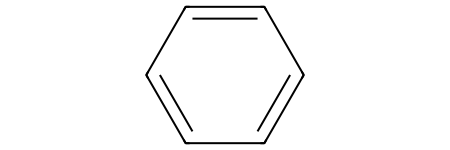

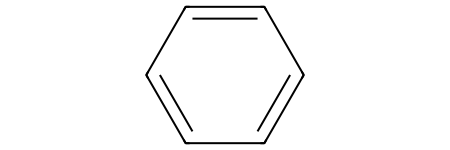

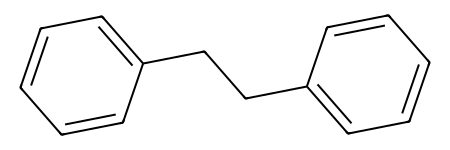

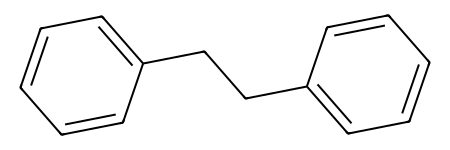

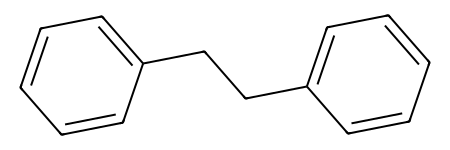

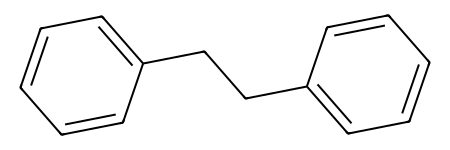

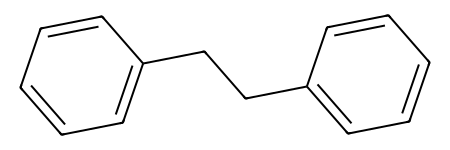

Numof bits: 1032  Bits set to 1: 18   Off Bits 1014 

    17      Aromatic Aromatic |0 1|1 0|                                               Aromatic Aromatic 
    20      Aromatic Hydrophobe |0 0|0 0|                                             Aromatic Hydrophobe 
    21      Aromatic Hydrophobe |0 1|1 0|                                             Aromatic Hydrophobe 
    23      Aromatic LumpedHydrophobe |0 1|1 0|                                       Aromatic LumpedHydrophobe 
    42      Hydrophobe Hydrophobe |0 0|0 0|                                           Hydrophobe Hydrophobe 
    43      Hydrophobe Hydrophobe |0 1|1 0|                                           Hydrophobe Hydrophobe 
    44      Hydrophobe LumpedHydrophobe |0 0|0 0|                                     Hydrophobe LumpedHydrophobe 
    45      Hydrophobe LumpedHydrophobe |0 1|1 0|                                     Hydrophobe LumpedHydrophobe 
    53      LumpedHydrophobe LumpedHydrophobe |0 1|1 0|           

In [95]:
# tmp = MolFromSmiles('c1ccc(CCCCCCCCCCCCCCCCCCc2ccccc2)cc1')

tmp = MolFromSmiles('c1ccccc1')
tmp
tmp = MolFromSmiles('c2ccccc2')
tmp
tmp = MolFromSmiles('c1ccccc1CCc2ccccc2')
tmp = MolFromSmiles('c1cc(CCc2ccccc2)ccc1')
tmp = MolFromSmiles('c1ccc(CCc2ccccc2)cc1')
tmp = MolFromSmiles('c1cccc(CCc2ccccc2)c1')
for smil in ['c1ccccc1CCc2ccccc2','c1c(CCc2ccccc2)cccc1', 'c1cc(CCc2ccccc2)ccc1','c1ccc(CCc2ccccc2)cc1', 'c1cccc(CCc2ccccc2)c1']:
    tmp = MolFromSmiles(smil)
    tmp
tmp = MolFromSmiles('c1cccc(CCc2ccccc2)c1')
fp = Generate.Gen2DFingerprint(tmp, sigFactory)
print( f"Numof bits: {fp.GetNumBits()}  Bits set to 1: {fp.GetNumOnBits()}   Off Bits {fp.GetNumOffBits()} \n")

# int_vector = np.zeros((1032))
# int_vector[:10]

int_vector =fp.GetOnBits()
# int_vector = (list(int_vector))
# len(int_vector)
for bit_id in sorted(int_vector):
    selected_label_descriptions.append(sigFactory.GetBitDescription(bit_id))
    print(f" {bit_id:5d}      {selected_label_descriptions[-1]:70s}    {selected_label_descriptions[-1].split('|')[0]}")

In [98]:
for bit_id in  ind_list:
    print(f" bit: {bit_id:5d}    desc: {sigFactory.GetBitDescription(bit_id)} ")

NameError: name 'ind_list' is not defined

In [319]:
for bit_id in  [134, 5941, 10462]:
    print(f" bit: {bit_id:5d}    desc: {sigFactory.GetBitDescription(bit_id)} ")

 bit:   134    desc: LumpedHydrophobe LumpedHydrophobe |0 4|4 0| 
 bit:  5941    desc: Aromatic Hydrophobe LumpedHydrophobe |0 4 4|4 0 3|4 3 0| 
 bit: 10462    desc: Hydrophobe LumpedHydrophobe LumpedHydrophobe |0 4 4|4 0 4|4 4 0| 


In [337]:
for bit_id in  [2053, 2191, 5252]:
    print(f" bit: {bit_id:5d}    desc: {sigFactory.GetBitDescription(bit_id)} ")

 bit:  2053    desc: Acceptor Donor Hydrophobe |0 2 4|2 0 3|4 3 0| 
 bit:  2191    desc: Acceptor Donor LumpedHydrophobe |0 3 4|3 0 4|4 4 0| 
 bit:  5252    desc: Aromatic Donor Hydrophobe |0 4 2|4 0 2|2 2 0| 


In [ ]:
from rdkit import RDConfig
from rdkit.Chem import ChemicalFeatures
from rdkit.Chem.Pharm2D.SigFactory import SigFactory
fdefName = os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef')
print(fdefName)
featFactory = ChemicalFeatures.BuildFeatureFactory(fdefName)
sigFactory = SigFactory(featFactory,minPointCount=2,maxPointCount=3)
sigFactory.SetBins([(0,3),(3,8)])
sigFactory.Init()
sigFactory.GetSigSize()
selected_bits_over60   = [23, 17, 53, 21, 509,  9, 52, 49, 163, 797,
                          39, 13, 267, 141, 285,  479, 677, 45, 127, 270,
                          767, 468, 271, 2, 165,  756, 27, 387, 26, 287,
                          390, 48, 231, 183, 383, 8]

selected_bits_50_to_55 = [200, 205, 211, 428, 642, 103,  98, 215, 100, 636,
                          150, 149, 144, 102, 207, 151, 206,   6, 147,  79,
                          83,  95, 203, 607, 603, 213, 208, 107,  99,  32,
                          431, 204, 96,  214,   4,   1, 637, 146, 429, 156,
                          417, 18, 244,  423, 84]
# for bit_id in range(11):
#     print(f" bit: {bit_id:4d}    desc: {sigFactory.GetBitDescription(bit_id)}")

for bit_id in sorted(selected_bits_50_to_55):
    print(f" bit: {bit_id:4d}    desc: {sigFactory.GetBitDescription(bit_id)}")

for bit_id in sorted(selected_bits_over60):
for bit_id in sorted(selected_bits_over60):
    print(f" bit: {bit_id:4d}    desc: {sigFactory.GetBitDescription(bit_id)} ")

In [126]:
# nPts, combo,scaffold = sigFactory.GetBitInfo(387)
nPts, combo,scaffold, labels, dMat = sigFactory._GetBitSummaryData(509)
nPts
combo
scaffold
labels
dMat

3

(1, 4, 4)

(1, 0, 1)

['Aromatic', 'LumpedHydrophobe', 'LumpedHydrophobe']

array([[0, 1, 0],
       [1, 0, 1],
       [0, 1, 0]])

### Selected Bit columns for 13740-B FP - Between 5% and 70%

In [14]:
# from rdkit.Chem.rdmolfiles import MolFromSmiles
from rdkit.Chem.Pharm2D import Generate
from rdkit import RDConfig
from rdkit.Chem import ChemicalFeatures
from rdkit.Chem.Pharm2D.SigFactory import SigFactory
# FINGERPRINT_BINS = [(0,3),(3,8)]
# FINGERPRINT_BINS = [(0,1),(1,2),(2,3),(3,4),(4,100)]
FINGERPRINT_BINS = [(0,3),(3,6),(6,9),(9,12),(12,100)]


fdefName = os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef')
featFactory = ChemicalFeatures.BuildFeatureFactory(fdefName)
sigFactory = SigFactory(featFactory,minPointCount=2,maxPointCount=3)
sigFactory.SetBins(FINGERPRINT_BINS)
sigFactory.Init()
FINGERPRINT_LENGTH = sigFactory.GetSigSize()
print(f" RDKit BaseFeatures.fdef : {FINGERPRINT_LENGTH}")

 RDKit BaseFeatures.fdef : 13740


In [15]:
# 13740-B Fingerprint with bins:  [(0,3),(3,6),(6,9),(9,12),(12,100)]
# indicies_pct_bw_05_70 
selected_label_indicies = np.array([
           0,     2,     3,     4,     8,     9,    10,    12,    13,    14,    18,    19,    22,    23,    24,    31,    32,    33,    40,    41,
          42,    43,    45,    47,    48,    50,    52,    53,    54,    55,    56,    57,    58,    65,    66,    67,    75,    76,    77,    78,
          80,    82,    83,    84,    85,    86,    87,    88,    96,    97,   105,   106,   107,   108,   109,   110,   111,   112,   113,   114,
         120,   121,   122,   123,   130,   131,   132,   133,   140,   141,   142,   203,   204,   227,   228,   232,   233,   256,   257,   258,
         261,   262,   280,   284,   285,   288,   289,   293,   296,   297,   301,   302,   307,   312,   316,   317,   321,   322,   323,   328,
         329,   333,   335,   340,   341,   345,   346,   350,   351,   352,   357,   364,   365,   369,   370,   374,   375,   380,   391,   392,
         396,   401,   406,   410,   414,   415,   420,   429,   430,   435,   436,   441,   453,   454,   458,   459,   464,   465,   470,   478,
         482,   483,   484,   487,   488,   505,   506,   510,   511,   519,   522,   523,   527,   528,   532,   533,   538,   542,   543,   547,
         548,   549,   553,   554,   555,   559,   566,   567,   571,   572,   576,   577,   578,   583,   584,   591,   595,   596,   600,   601,
         606,   607,   618,   619,   622,   623,   627,   628,   632,   635,   636,   641,   646,   651,   655,   656,   660,   661,   662,   667,
         668,   672,   674,   679,   680,   684,   685,   689,   690,   691,   696,   703,   704,   708,   713,   714,   719,   730,   731,   735,
         740,   887,   906,   935,  1084,  1085,  1103,  1104,  1105,  1108,  1109,  1126,  1127,  1128,  1131,  1132,  1133,  1134,  1151,  1152,
        1153,  1156,  1160,  1176,  1197,  1200,  1201,  1202,  1204,  1205,  1206,  1209,  1210,  1211,  1214,  1216,  1217,  1220,  1221,  1222,
        1225,  1226,  1227,  1228,  1230,  1231,  1240,  1241,  1244,  1245,  1246,  1247,  1249,  1250,  1254,  1266,  1269,  1270,  1273,  1274,
        1278,  1279,  1297,  1301,  1310,  1311,  1313,  1314,  1315,  1317,  1318,  1319,  1320,  1322,  1323,  1324,  1326,  1327,  1329,  1330,
        1331,  1333,  1334,  1335,  1338,  1339,  1340,  1341,  1344,  1346,  1349,  1353,  1354,  1357,  1358,  1359,  1360,  1362,  1363,  1365,
        1367,  1373,  1378,  1379,  1382,  1383,  1384,  1386,  1387,  1391,  1396,  1406,  1423,  1424,  1426,  1427,  1428,  1431,  1432,  1435,
        1436,  1437,  1440,  1442,  1443,  1444,  1447,  1448,  1451,  1452,  1453,  1454,  1457,  1466,  1467,  1471,  1472,  1473,  1480,  1490,
        1491,  1492,  1495,  1653,  1657,  1673,  1696,  1697,  1895,  1898,  1899,  1900,  1918,  1919,  1923,  1924,  1927,  1928,  1948,  1952,
        1988,  1989,  1991,  1992,  1996,  1997,  2001,  2002,  2007,  2008,  2009,  2011,  2012,  2013,  2016,  2017,  2018,  2019,  2022,  2023,
        2028,  2031,  2032,  2035,  2036,  2037,  2038,  2040,  2041,  2043,  2045,  2046,  2047,  2052,  2056,  2057,  2060,  2061,  2062,  2064,
        2065,  2069,  2070,  2075,  2084,  2101,  2104,  2105,  2109,  2110,  2115,  2120,  2121,  2122,  2124,  2125,  2126,  2129,  2130,  2131,
        2132,  2135,  2136,  2143,  2144,  2145,  2148,  2149,  2150,  2151,  2153,  2154,  2158,  2159,  2165,  2168,  2169,  2170,  2182,  2183,
        2331,  2356,  2375,  2553,  2554,  2572,  2573,  2574,  2576,  2577,  2578,  2596,  2597,  2598,  2600,  2601,  2602,  2603,  2605,  2606,
        2608,  2621,  2622,  2625,  2626,  2627,  2628,  2629,  2630,  2634,  2645,  2648,  2649,  2652,  2653,  2656,  2657,  2661,  2666,  2667,
        2669,  2670,  2671,  2674,  2675,  2679,  2680,  2685,  2686,  2687,  2689,  2690,  2691,  2694,  2695,  2696,  2697,  2700,  2701,  2702,
        2706,  2708,  2709,  2710,  2713,  2714,  2715,  2716,  2718,  2721,  2723,  2724,  2733,  2734,  2735,  2738,  2740,  2747,  2758,  2895,
        2896,  2901,  2915,  2917,  2920,  2921,  2939,  2940,  2944,  3138,  3142,  3143,  3161,  3162,  3166,  3167,  3168,  3186,  3187,  3190,
        4267,  4295,  4324,  4364,  4369,  4380,  4384,  4385,  4389,  4395,  4408,  4409,  4413,  4414,  4438,  4477,  4482,  4487,  4493,  4497,
        4502,  4503,  4508,  4521,  4522,  4526,  4531,  4551,  4590,  4595,  4615,  4644,  5039,  5040,  5058,  5059,  5060,  5062,  5063,  5082,
        5083,  5087,  5088,  5091,  5112,  5116,  5153,  5154,  5155,  5156,  5157,  5160,  5161,  5162,  5165,  5171,  5172,  5173,  5175,  5176,
        5177,  5178,  5180,  5181,  5182,  5186,  5187,  5195,  5196,  5197,  5199,  5200,  5204,  5205,  5210,  5225,  5228,  5229,  5266,  5268,
        5269,  5270,  5273,  5274,  5286,  5288,  5289,  5293,  5294,  5295,  5300,  5312,  5317,  5318,  5323,  5717,  5718,  5736,  5737,  5738,
        5740,  5741,  5743,  5760,  5761,  5762,  5764,  5765,  5769,  5785,  5789,  5790,  5793,  5794,  5798,  5831,  5833,  5834,  5835,  5838,
        5839,  5840,  5851,  5853,  5856,  5858,  5859,  5865,  5875,  5882,  5888,  6303,  7435,  7525,  7528,  7529,  7534,  7544,  7548,  7549,
        7553,  7554,  7560,  7572,  7573,  7577,  7578,  7583,  7641,  7642,  7661,  7662,  7666,  7667,  7685,  7690,  7696,  8090,  8091,  8109,
        8110,  8111,  8113,  8114,  8115,  8133,  8134,  8135,  8137,  8138,  8139,  8140,  8142,  8158,  8159,  8162,  8163,  8166,  8167,  8171,
        8204,  8206,  8207,  8208,  8211,  8212,  8216,  8222,  8223,  8224,  8226,  8227,  8228,  8231,  8232,  8233,  8234,  8238,  8246,  8247,
        8252,  8253,  8255,  8261,  8433,  8452,  8454,  8656,  8675,  8676,  8679,  8680,  8698,  8699,  8704,  8705,  9785,  9804,  9808,  9832,
        9833,  9837,  9857,  9861,  9862,  9866,  9898,  9901,  9902,  9906,  9907,  9911,  9912,  9921,  9926,  9927,  9932,  9933,  9950,  9956,
       10127, 10370, 10375])

len(selected_label_indicies)
str_selected_label_indicies  = [str(x) for x in selected_label_indicies ]
# str_selected_label_indicies 

803

In [16]:
# selected_label_descriptions = []
for bit_id in sorted(selected_label_indicies):
    selected_label_descriptions.append(sigFactory.GetBitDescription(bit_id))
    print(f" {bit_id:5d}      {selected_label_descriptions[-1]:60s}    {selected_label_descriptions[-1].split('|')[0]}")

     0      Acceptor Acceptor |0 0|0 0|                                     Acceptor Acceptor 
     2      Acceptor Acceptor |0 2|2 0|                                     Acceptor Acceptor 
     3      Acceptor Acceptor |0 3|3 0|                                     Acceptor Acceptor 
     4      Acceptor Acceptor |0 4|4 0|                                     Acceptor Acceptor 
     8      Acceptor Aromatic |0 3|3 0|                                     Acceptor Aromatic 
     9      Acceptor Aromatic |0 4|4 0|                                     Acceptor Aromatic 
    10      Acceptor Donor |0 0|0 0|                                        Acceptor Donor 
    12      Acceptor Donor |0 2|2 0|                                        Acceptor Donor 
    13      Acceptor Donor |0 3|3 0|                                        Acceptor Donor 
    14      Acceptor Donor |0 4|4 0|                                        Acceptor Donor 
    18      Acceptor Hydrophobe |0 3|3 0|                     

# 13740 Fingerprint-B - Bins `[(0, 3), (3, 6), (6, 9), (9, 12), (12, 100)]`  -  5 % and 70%

Bits with a frequency between 5% and 70% of total compounds (number of bits > 70% is 4 bits and are included)

Total bits : 803 Bits 
    
    Fingerprint Bits with ROC AUC improvement under Embedding Model: 
    
      improvement < 0%      :   297        36.99 %
      improvement > 0%      :   506        63.01 %
      Improvment Ratio      :  1.90
    
     Fingerprint Bits with ROC AUC improvement under Embedding Model: 
    
      improvement <= -5.0 %  :    11        1.37 % 
      improvement -5% to 0%  :   281       34.99 %
      improvement  0% to 5%  :   401       49.94 %
      improvement  5% to 10% :    89       11.08 %
      improvement >= 10%     :    21        2.62 %

## Setup

In [17]:
FINGERPRINT_BINS

[(0, 3), (3, 6), (6, 9), (9, 12), (12, 100)]

In [18]:
FP_SUFFIX = 'B'
SEL_COLS = 'selcols0570'
EMBEDDED_METRICS_PATH = '../saved_fingerprint_models/embedded_models'
PROFILES_METRICS_PATH = '../saved_fingerprint_models/profile_models'
EMBEDDED_METRICS_FILENAME = f'PFP_LogReg_embeddings_13740-{FP_SUFFIX}_quickscan_metrics_{SEL_COLS}_20241220_0000.csv'
PROFILES_METRICS_FILENAME = f'PFP_LogReg_profiles_13740-{FP_SUFFIX}_quickscan_metrics_{SEL_COLS}_20241222_0000.csv'
EMBEDDED_METRICS_FILENAME
PROFILES_METRICS_FILENAME

'PFP_LogReg_embeddings_13740-B_quickscan_metrics_selcols0570_20241220_0000.csv'

'PFP_LogReg_profiles_13740-B_quickscan_metrics_selcols0570_20241222_0000.csv'

In [20]:
embedded_metrics = pd.read_csv(os.path.join(EMBEDDED_METRICS_PATH, EMBEDDED_METRICS_FILENAME))
profile_metrics  = pd.read_csv(os.path.join(PROFILES_METRICS_PATH, PROFILES_METRICS_FILENAME))
embedded_metrics.info()
profile_metrics.info()
embedded_metrics.head()
profile_metrics.head()
# embedded_metrics.drop('Unnamed: 0',axis = 1, inplace = True)
# profile_metrics.drop('Unnamed: 0',axis = 1, inplace = True)
# embedded_metrics.info()
# profile_metrics.info()
embedded_metrics.reset_index(inplace = True)
profile_metrics.reset_index(inplace = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 803 entries, 0 to 802
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Y_bit              803 non-null    int64  
 1   Y_bit_pct          803 non-null    float64
 2   param_C            803 non-null    float64
 3   param_solver       803 non-null    object 
 4   mean_test_score    803 non-null    float64
 5   precision          803 non-null    float64
 6   accuracy           803 non-null    float64
 7   recall             803 non-null    float64
 8   f1                 803 non-null    float64
 9   Y_bit_description  803 non-null    object 
 10  params             803 non-null    object 
 11  random_seed        803 non-null    int64  
dtypes: float64(7), int64(2), object(3)
memory usage: 75.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 803 entries, 0 to 802
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  --

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1            Y_bit_description  \
0      0   0.511829    0.025        lbfgs         0.558431   0.518094  0.530794  0.856075  0.645521  Acceptor Acceptor |0 0|0 0|   
1      2   0.697338    0.025        lbfgs         0.525606   0.689559  0.689048  0.998042  0.815606  Acceptor Acceptor |0 2|2 0|   
2      3   0.446742    0.025        lbfgs         0.529650   0.561271  0.573095  0.067949  0.121222  Acceptor Acceptor |0 3|3 0|   
3      4   0.208149    0.025        lbfgs         0.547004   0.083333  0.793254  0.000385  0.000767  Acceptor Acceptor |0 4|4 0|   
4      8   0.442684    0.025        lbfgs         0.558150   0.567288  0.572222  0.099275  0.168979  Acceptor Aromatic |0 3|3 0|   

  params  random_seed  
0   none         6666  
1   none         6666  
2   none         6666  
3   none         6666  
4   none         6666

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1            Y_bit_description  \
0      0   0.511829    0.025        lbfgs         0.550693   0.528443  0.536587  0.663327  0.588252  Acceptor Acceptor |0 0|0 0|   
1      2   0.697338    0.025        lbfgs         0.542591   0.690796  0.690000  0.995853  0.815737  Acceptor Acceptor |0 2|2 0|   
2      3   0.446742    0.025        lbfgs         0.538184   0.480121  0.560397  0.174725  0.256211  Acceptor Acceptor |0 3|3 0|   
3      4   0.208149    0.025        lbfgs         0.564437   0.040000  0.792222  0.000385  0.000763  Acceptor Acceptor |0 4|4 0|   
4      8   0.442684    0.025        lbfgs         0.578306   0.562270  0.586111  0.249457  0.345589  Acceptor Aromatic |0 3|3 0|   

  params  random_seed  
0   none         6666  
1   none         6666  
2   none         6666  
3   none         6666  
4   none         6666

In [21]:
for col in ['Y_bit', 'Y_bit_description', 'Y_bit_pct']:
    print(f" {col:20s}  - {(embedded_metrics[col] == profile_metrics[col]).sum()}")

 Y_bit                 - 803
 Y_bit_description     - 803
 Y_bit_pct             - 803


## Join Profile and Embeded metrics 

In [22]:
df_metrics= profile_metrics.merge(embedded_metrics,
                                  left_on =['Y_bit', 'Y_bit_description', 'Y_bit_pct'],
                                  right_on = ['Y_bit', 'Y_bit_description', 'Y_bit_pct'],
                                  suffixes=('_p', '_e'), how= 'inner', 
                                  indicator = True,  left_index=False, right_index=False, )
# df_metrics= profile_best_metrics.merge(embedded_best_metrics,left_on =['Y_bit'], right_on = ['Y_bit'], suffixes=('_p', '_e'), how= 'inner', indicator = True,  left_index=False, right_index=False, )
# df_metrics.info()
df_metrics.drop(['index_e','param_C_p', 'param_C_e', 'param_solver_p', 'param_solver_e',
                 'params_p', 'params_e', 'random_seed_p', 'random_seed_e', '_merge'], axis = 1, inplace = True)
df_metrics.info()
df_metrics.shape
df_metrics.head(20)
# df_metrics= profile_best_metrics.merge(embedded_best_metrics,on ='Y_bit', rsuffix='_e', how= 'inner')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 803 entries, 0 to 802
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index_p            803 non-null    int64  
 1   Y_bit              803 non-null    int64  
 2   Y_bit_pct          803 non-null    float64
 3   mean_test_score_p  803 non-null    float64
 4   precision_p        803 non-null    float64
 5   accuracy_p         803 non-null    float64
 6   recall_p           803 non-null    float64
 7   f1_p               803 non-null    float64
 8   Y_bit_description  803 non-null    object 
 9   mean_test_score_e  803 non-null    float64
 10  precision_e        803 non-null    float64
 11  accuracy_e         803 non-null    float64
 12  recall_e           803 non-null    float64
 13  f1_e               803 non-null    float64
dtypes: float64(11), int64(2), object(1)
memory usage: 88.0+ KB


(803, 14)

index_p  Y_bit  Y_bit_pct  mean_test_score_p  precision_p  accuracy_p  recall_p      f1_p  \
0         0      0   0.511829           0.550693     0.528443    0.536587  0.663327  0.588252   
1         1      2   0.697338           0.542591     0.690796    0.690000  0.995853  0.815737   
2         2      3   0.446742           0.538184     0.480121    0.560397  0.174725  0.256211   
3         3      4   0.208149           0.564437     0.040000    0.792222  0.000385  0.000763   
4         4      8   0.442684           0.578306     0.562270    0.586111  0.249457  0.345589   
5         5      9   0.149275           0.593323     0.205882    0.850556  0.003757  0.007380   
6         6     10   0.530487           0.546499     0.539697    0.539921  0.788808  0.640897   
7         7     12   0.636277           0.566188     0.624441    0.622143  0.982234  0.763499   
8         8     13   0.329307           0.568534     0.579646    0.683333  0.032538  0.061618   
9         9     14   0.120758           0.574495     0.333333    0.879206  0.004620  0.009115   
10       10     18   0.544567           0.581002     0.563643    0.557143  0.744633  0.641618   
11       11     19   0.235054           0.584835     0.401316    0.774286  0.021677  0.041133   
12       12     22   0.641299           0.578635     0.638875    0.634048  0.977553  0.772734   
13       13     23   0.397294           0.579387     0.563038    0.613254  0.142829  0.227856   
14       14     24   0.146861           0.592787     0.250000    0.856032  0.005574  0.010905   
15       15     31   0.214372           0.599040     0.597561    0.794365  0.018796  0.036445   
16       16     32   0.164134           0.602878     0.428571    0.841032  0.012030  0.023403   
17       17     33   0.085000           0.630579     0.352941    0.909206  0.010582  0.020548   
18       18     40   0.386266           0.604261     0.604580    0.638889  0.164179  0.258233   
19       19     41   0.521807           0.614742     0.606078    0.581032  0.611583  0.608818   

                      Y_bit_description  mean_test_score_e  precision_e  accuracy_e  recall_e      f1_e  
0           Acceptor Acceptor |0 0|0 0|           0.558431     0.518094    0.530794  0.856075  0.645521  
1           Acceptor Acceptor |0 2|2 0|           0.525606     0.689559    0.689048  0.998042  0.815606  
2           Acceptor Acceptor |0 3|3 0|           0.529650     0.561271    0.573095  0.067949  0.121222  
3           Acceptor Acceptor |0 4|4 0|           0.547004     0.083333    0.793254  0.000385  0.000767  
4           Acceptor Aromatic |0 3|3 0|           0.558150     0.567288    0.572222  0.099275  0.168979  
5           Acceptor Aromatic |0 4|4 0|           0.572174     0.200000    0.850952  0.002684  0.005297  
6              Acceptor Donor |0 0|0 0|           0.543749     0.525637    0.527460  0.944190  0.675319  
7              Acceptor Donor |0 2|2 0|           0.543273     0.622183    0.622619  0.998722  0.766717  
8              Acceptor Donor |0 3|3 0|           0.555777     0.619048    0.682857  0.019374  0.037572  
9              Acceptor Donor |0 4|4 0|           0.583487     0.379310    0.879206  0.007261  0.014249  
10        Acceptor Hydrophobe |0 3|3 0|           0.560258     0.539322    0.539048  0.920095  0.680035  
11        Acceptor Hydrophobe |0 4|4 0|           0.581933     0.441176    0.776032  0.010661  0.020819  
12  Acceptor LumpedHydrophobe |0 2|2 0|           0.568374     0.636400    0.635159  0.995511  0.776443  
13  Acceptor LumpedHydrophobe |0 3|3 0|           0.572296     0.571072    0.605000  0.045491  0.084269  
14  Acceptor LumpedHydrophobe |0 4|4 0|           0.570095     0.153846    0.856190  0.002230  0.004396  
15      Acceptor PosIonizable |0 1|1 0|           0.609247     0.521739    0.793254  0.009206  0.018093  
16      Acceptor PosIonizable |0 2|2 0|           0.621206     0.250000    0.840556  0.003509  0.006920  
17      Acceptor PosIonizable |0 3|3 0|           0.626966

In [23]:
df_metrics['ms_diff'] = (df_metrics.mean_test_score_e - df_metrics.mean_test_score_p)
df_metrics['ms_diff_grp'] = round(df_metrics.ms_diff * 100,0)
df_metrics['ms_diff_pct'] = round(((df_metrics.mean_test_score_e - df_metrics.mean_test_score_p)  / df_metrics.mean_test_score_p) * 100.0,1)
df_metrics['ms_diff_pct_grp'] = round(df_metrics.ms_diff_pct,0)
df_metrics['roc_avg'] = (df_metrics.mean_test_score_e + df_metrics.mean_test_score_p) / 2

# df_metrics['ms_diff_norm'] = (df_metrics.ms_diff - np.average(df_metrics.ms_diff)) / (df_metrics.ms_diff.max() - df_metrics.ms_diff.min())
df_metrics['Y_bit_pct_grp'] = round(df_metrics.Y_bit_pct * 10,0)
df_metrics['fp_groups'] = df_metrics.Y_bit_description.apply(lambda x: x.split('|')[0].strip())
col_reorder = ['index_p', 'Y_bit', 'Y_bit_pct','Y_bit_pct_grp', 'mean_test_score_p', 'mean_test_score_e','ms_diff',  'roc_avg',  'ms_diff_pct',
               'ms_diff_grp','ms_diff_pct_grp',
               'fp_groups', 'Y_bit_description',
               'precision_p', 'accuracy_p', 'recall_p', 'f1_p',
               'precision_e', 'accuracy_e', 'recall_e', 'f1_e',
            ]
df_metrics = df_metrics[col_reorder]

In [24]:
df_metrics.loc[334]
df_metrics.columns

index_p                                                            334
Y_bit                                                             1426
Y_bit_pct                                                     0.185292
Y_bit_pct_grp                                                      2.0
mean_test_score_p                                              0.56497
mean_test_score_e                                             0.581413
ms_diff                                                       0.016443
roc_avg                                                       0.573192
ms_diff_pct                                                        2.9
ms_diff_grp                                                        2.0
ms_diff_pct_grp                                                    3.0
fp_groups                           Acceptor Aromatic LumpedHydrophobe
Y_bit_description    Acceptor Aromatic LumpedHydrophobe |0 0 1|0 0 ...
precision_p                                                   0.606061
accura

Index(['index_p', 'Y_bit', 'Y_bit_pct', 'Y_bit_pct_grp', 'mean_test_score_p', 'mean_test_score_e', 'ms_diff', 'roc_avg',
       'ms_diff_pct', 'ms_diff_grp', 'ms_diff_pct_grp', 'fp_groups', 'Y_bit_description', 'precision_p', 'accuracy_p', 'recall_p',
       'f1_p', 'precision_e', 'accuracy_e', 'recall_e', 'f1_e'],
      dtype='object')

In [25]:
sort_col = 'ms_diff_pct'
sort_col = 'roc_avg'
df_metrics.sort_values(sort_col).head(10)
df_metrics.sort_values(sort_col).tail(10)
# df_metrics

index_p  Y_bit  Y_bit_pct  Y_bit_pct_grp  mean_test_score_p  mean_test_score_e   ms_diff   roc_avg  ms_diff_pct  ms_diff_grp  \
88        88    296   0.099253            1.0           0.512885           0.499839 -0.013046  0.506362         -2.5         -1.0   
432      432   2121   0.226017            2.0           0.519352           0.498229 -0.021123  0.508790         -4.1         -2.0   
439      439   2131   0.079773            1.0           0.524599           0.496291 -0.028308  0.510445         -5.4         -3.0   
189      189    635   0.081255            1.0           0.512162           0.508828 -0.003333  0.510495         -0.7         -0.0   
393      393   2013   0.275065            3.0           0.524619           0.505850 -0.018769  0.515234         -3.6         -2.0   
246      246   1201   0.300866            3.0           0.527568           0.503649 -0.023918  0.515608         -4.5         -2.0   
175      175    591   0.138788            1.0           0.512331           0.519668  0.007337  0.516000          1.4          1.0   
166      166    566   0.400833            4.0           0.526287           0.510875 -0.015412  0.518581         -2.9         -2.0   
447      447   2149   0.057262            1.0           0.534469           0.504737 -0.029732  0.519603         -5.6         -3.0   
150      150    522   0.116504            1.0           0.517058           0.522275  0.005217  0.519666          1.0          1.0   

     ...                           fp_groups                                  Y_bit_description precision_p  accuracy_p  recall_p  \
88   ...          Acceptor Acceptor Aromatic     Acceptor Acceptor Aromatic |0 0 1|0 0 0|1 0 0|    0.000000    0.902063  0.000000   
432  ...     Acceptor Donor LumpedHydrophobe  Acceptor Donor LumpedHydrophobe |0 1 0|1 0 1|0...    0.461538    0.789683  0.002265   
439  ...     Acceptor Donor LumpedHydrophobe  Acceptor Donor LumpedHydrophobe |0 1 2|1 0 2|2...    0.000000    0.924841  0.000000   
189  ...  Acceptor Acceptor LumpedHydrophobe  Acceptor Acceptor LumpedHydrophobe |0 0 1|0 0 ...    0.000000    0.920397  0.000000   
393  ...           Acceptor Donor Hydrophobe      Acceptor Donor Hydrophobe |0 1 1|1 0 2|1 2 0|    0.264706    0.726825  0.002627   
246  ...             Acceptor Aromatic Donor        Acceptor Aromatic Donor |0 0 1|0 0 1|1 1 0|    0.277778    0.714444  0.002792   
175  ...        Acceptor Acceptor Hydrophobe   Acceptor Acceptor Hydrophobe |0 3 1|3 0 1|1 1 0|    0.125000    0.862143  0.000578   
166  ...        Acceptor Acceptor Hydrophobe   Acceptor Acceptor Hydrophobe |0 2 1|2 0 0|1 0 0|    0.434298    0.607698  0.039926   
447  ...     Acceptor Donor LumpedHydrophobe  Acceptor Donor LumpedHydrophobe |0 2 1|2 0 1|1...    0.285714    0.940238  0.002667   
150  ...        Acceptor Acceptor Hydrophobe   Acceptor Acceptor Hydrophobe |0 0 1|0 0 0|1 0 0|    0.000000    0.883413  0.000000   

         f1_p  precision_e  accuracy_e  recall_e      f1_e  
88   0.000000     0.000000    0.902619  0.000000  0.000000  
432  0.004508     0.000000    0.789683  0.000000  0.000000  
439  0.000000     0.000000    0.924921  0.000000  0.000000  
189  0.000000     0.000000    0.920476  0.000000  0.000000  
393  0.005202     0.500000    0.728095  0.003503  0.006957  
246  0.005528     0.666667    0.715794  0.000558  0.001116  
175  0.001150     0.000000    0.862540  0.000000  0.000000  
166  0.073130     0.428571    0.611429  0.007371  0.014493  
447  0.005284     0.000000    0.940476  0.000000  0.000000  
150  0.000000     0.000000    0.883810  0.000000  0.000000  

[10 rows x 21 columns]

index_p  Y_bit  Y_bit_pct  Y_bit_pct_grp  mean_test_score_p  mean_test_score_e   ms_diff   roc_avg  ms_diff_pct  ms_diff_grp  \
799      799   9956   0.084632            1.0           0.617975           0.637737  0.019761  0.627856          3.2          2.0   
17        17     33   0.085000            1.0           0.630579           0.626966 -0.003613  0.628773         -0.6         -0.0   
662      662   5743   0.063377            1.0           0.637935           0.619909 -0.018026  0.628922         -2.8         -2.0   
582      582   4508   0.083658            1.0           0.629425           0.631947  0.002522  0.630686          0.4          0.0   
802      802  10375   0.066937            1.0           0.623472           0.639403  0.015930  0.631437          2.6          2.0   
35        35     67   0.103604            1.0           0.637304           0.630470 -0.006834  0.633887         -1.1         -1.0   
581      581   4503   0.056407            1.0           0.628656           0.640425  0.011769  0.634540          1.9          1.0   
63        63    123   0.056039            1.0           0.637659           0.638103  0.000444  0.637881          0.1          0.0   
59        59    114   0.066429            1.0           0.625867           0.650090  0.024223  0.637979          3.9          2.0   
676      676   5833   0.055985            1.0           0.627805           0.652056  0.024252  0.639931          3.9          2.0   

     ...                                     fp_groups                                  Y_bit_description precision_p  accuracy_p  \
799  ...        Hydrophobe Hydrophobe LumpedHydrophobe  Hydrophobe Hydrophobe LumpedHydrophobe |0 2 3|...    0.352941    0.914841   
17   ...                         Acceptor PosIonizable                    Acceptor PosIonizable |0 3|3 0|    0.352941    0.909206   
662  ...                Aromatic Hydrophobe Hydrophobe  Aromatic Hydrophobe Hydrophobe |0 1 1|1 0 3|1 ...    0.250000    0.936905   
582  ...                  Aromatic Aromatic Hydrophobe   Aromatic Aromatic Hydrophobe |0 1 3|1 0 1|3 1 0|    0.291667    0.918492   
802  ...  Hydrophobe LumpedHydrophobe LumpedHydrophobe  Hydrophobe LumpedHydrophobe LumpedHydrophobe |...    0.384615    0.931190   
35   ...                         Aromatic PosIonizable                    Aromatic PosIonizable |0 2|2 0|    0.645161    0.893095   
581  ...                  Aromatic Aromatic Hydrophobe   Aromatic Aromatic Hydrophobe |0 1 2|1 0 1|2 1 0|    0.235294    0.945714   
63   ...                       Hydrophobe PosIonizable                  Hydrophobe PosIonizable |0 3|3 0|    0.684211    0.942778   
59   ...                   Hydrophobe LumpedHydrophobe              Hydrophobe LumpedHydrophobe |0 4|4 0|    0.461538    0.931825   
676  ...          Aromatic Hydrophobe LumpedHydrophobe  Aromatic Hydrophobe LumpedHydrophobe |0 0 1|0 ...    0.600000    0.942063   

     recall_p      f1_p  precision_e  accuracy_e  recall_e      f1_e  
799  0.005618  0.011060     0.181818    0.914683  0.001873  0.003707  
17   0.010582  0.020548     0.666667    0.910397  0.008818  0.017406  
662  0.003802  0.007491     0.166667    0.937063  0.001267  0.002516  
582  0.006883  0.013449     0.277778    0.918651  0.004916  0.009662  
802  0.005787  0.011403     0.333333    0.931270  0.002315  0.004598  
35   0.029304  0.056062     0.696970    0.892698  0.016850  0.032904  
581  0.005926  0.011561     0.111111    0.945873  0.001481  0.002924  
63   0.035374  0.067270     0.625000    0.942143  0.020408  0.039526  
59   0.006993  0.013777     0.333333    0.931587  0.004662  0.009195  
676  0.008197  0.016173     0.333333    0.941825  0.001366  0.002721  

[10 rows x 21 columns]

In [31]:
for col in ['mean_test_score_p', 'mean_test_score_e' ]:
    print(f"{col:20s}:    MIN: {df_metrics[col].min():8.5f}    mean: {df_metrics[col].mean():8.5f}   std: {df_metrics[col].std():8.5f}    MAX: {df_metrics[col].max():8.5f}")
print()
for col in ['Y_bit_pct',  'Y_bit_pct_grp', 'ms_diff', 'ms_diff_grp', 'ms_diff_pct',  'ms_diff_pct_grp', 'roc_avg']:
    print(f"{col:20s}:    MIN: {df_metrics[col].min():8.5f}    mean: {df_metrics[col].mean():8.5f}   std: {df_metrics[col].std():8.5f}    MAX: {df_metrics[col].max():8.5f}")
print()

df_metrics.ms_diff_grp.value_counts().sort_index()
df_metrics.Y_bit_pct_grp.value_counts()
df_metrics.fp_groups.value_counts()
FP_GROUPS = df_metrics.fp_groups.value_counts().index.to_list()
FP_GROUPS[:10]
len(FP_GROUPS)

mean_test_score_p   :    MIN:  0.51041    mean:  0.56420   std:  0.02686    MAX:  0.63793
mean_test_score_e   :    MIN:  0.49629    mean:  0.57207   std:  0.02941    MAX:  0.65708

Y_bit_pct           :    MIN:  0.05018    mean:  0.14818   std:  0.10788    MAX:  0.69734
Y_bit_pct_grp       :    MIN:  1.00000    mean:  1.58655   std:  1.00170    MAX:  7.00000
ms_diff             :    MIN: -0.04962    mean:  0.00787   std:  0.02037    MAX:  0.10545
ms_diff_grp         :    MIN: -5.00000    mean:  0.78331   std:  2.05604    MAX: 11.00000
ms_diff_pct         :    MIN: -9.10000    mean:  1.43948   std:  3.68265    MAX: 20.10000
ms_diff_pct_grp     :    MIN: -9.00000    mean:  1.43587   std:  3.68312    MAX: 20.00000
roc_avg             :    MIN:  0.50636    mean:  0.56814   std:  0.02626    MAX:  0.63993



ms_diff_grp
-5.0       2
-4.0       4
-3.0      16
-2.0      63
-1.0     118
-0.0     186
 1.0     170
 2.0     113
 3.0      58
 4.0      31
 5.0      22
 6.0      10
 7.0       3
 8.0       4
 9.0       1
 10.0      1
 11.0      1
Name: count, dtype: int64

Y_bit_pct_grp
1.0    521
2.0    168
3.0     69
4.0     25
5.0     11
6.0      8
7.0      1
Name: count, dtype: int64

fp_groups
Acceptor Aromatic Hydrophobe                    48
Acceptor Donor Hydrophobe                       45
Acceptor Hydrophobe LumpedHydrophobe            41
Acceptor Aromatic Donor                         40
Acceptor Acceptor Hydrophobe                    39
Acceptor Donor LumpedHydrophobe                 35
Acceptor Hydrophobe Hydrophobe                  35
Acceptor Acceptor Aromatic                      35
Acceptor Acceptor LumpedHydrophobe              33
Aromatic Donor Hydrophobe                       32
Acceptor Aromatic LumpedHydrophobe              31
Acceptor Acceptor Donor                         27
Donor Hydrophobe LumpedHydrophobe               24
Donor Hydrophobe Hydrophobe                     23
Aromatic Hydrophobe Hydrophobe                  20
Acceptor Aromatic Aromatic                      20
Aromatic Donor LumpedHydrophobe                 17
Aromatic Hydrophobe LumpedHydrophobe            16
Acceptor Acceptor Acceptor                      16
Donor Donor Hydrophob

['Acceptor Aromatic Hydrophobe',
 'Acceptor Donor Hydrophobe',
 'Acceptor Hydrophobe LumpedHydrophobe',
 'Acceptor Aromatic Donor',
 'Acceptor Acceptor Hydrophobe',
 'Acceptor Donor LumpedHydrophobe',
 'Acceptor Hydrophobe Hydrophobe',
 'Acceptor Acceptor Aromatic',
 'Acceptor Acceptor LumpedHydrophobe',
 'Aromatic Donor Hydrophobe']

60

In [42]:
# df_metrics[['Y_bit', 'Y_bit_pct_p','mean_test_score_p', 'mean_test_score_e','mean_score_diff','mean_score_diff_pct','Y_bit_description_e']].sort_values('mean_score_diff_pct', ascending = False)[-30:]
# df_metrics[['Y_bit', 'Y_bit_pct_p','mean_test_score_p', 'mean_test_score_e','ms_diff','ms_diff_pct','ms_diff_norm','ms_diff_grp','bit_freq_grp','Y_bit_description_e']].sort_values('Y_bit_pct_p', ascending = False)[:10]

## Improvement Frequencies

In [ ]:
# len(df_metrics)
ttl_rows = len(df_metrics) / 100.0 
print(f" Fingerprint Bits with ROC AUC improvement under Embedding Model: \n")
print(f"  improvement < 0%      : {(df_metrics.ms_diff_pct<= 0.00).sum():5d}       {(df_metrics.ms_diff_pct<= 0.00).sum()/ttl_rows:6.2f} %")
print(f"  improvement > 0%      : {(df_metrics.ms_diff_pct > 0.00).sum():5d}       {(df_metrics.ms_diff_pct > 0.00).sum()/ttl_rows:6.2f} %")
print(f"  Improvment Ratio      : {349/184:5.2f}")
print()
print(f" Fingerprint Bits with ROC AUC improvement under Embedding Model: \n")
print(f"  improvement <= -5.0 %  : {(df_metrics.ms_diff_pct< -5.00).sum():5d}      {(df_metrics.ms_diff_pct< -5.00).sum()/ttl_rows:6.2f} % ")
print(f"  improvement -5% to 0%  : {df_metrics.ms_diff_pct.between(-5.0,  0.0, inclusive = 'left').sum():5d}      {df_metrics.ms_diff_pct.between(-5.0,  0.0, inclusive = 'left').sum()/ttl_rows:6.2f} %")
print(f"  improvement  0% to 5%  : {df_metrics.ms_diff_pct.between( 0.0,  5.0, inclusive = 'left').sum():5d}      {df_metrics.ms_diff_pct.between( 0.0,  5.0, inclusive = 'left').sum()/ttl_rows:6.2f} %")
print(f"  improvement  5% to 10% : {df_metrics.ms_diff_pct.between( 5.0, 10.00,inclusive = 'left').sum():5d}      {df_metrics.ms_diff_pct.between( 5.0, 10.00,inclusive = 'left').sum()/ttl_rows:6.2f} %")
print(f"  improvement >= 10%     : {(df_metrics.ms_diff_pct >= 10.00).sum():5d}      {(df_metrics.ms_diff_pct >= 10.00).sum()/ttl_rows:6.2f} %")
print()
# print(f" num of bits where Profile Score > Embedded score : {df_metrics2[df_metrics2.mean_test_score.between(0.60, 1.01, inclusive = 'both')]})

ROC AUC Change %    :    mean:  1.43948   std:  3.68265   min: -9.10000   max: 20.10000
ROC AUC Profiles    :    mean:  0.56420   std:  0.02686   min:  0.51041   max:  0.63793
ROC_AUC Emebdding   :    mean:  0.57207   std:  0.02941   min:  0.49629   max:  0.65708




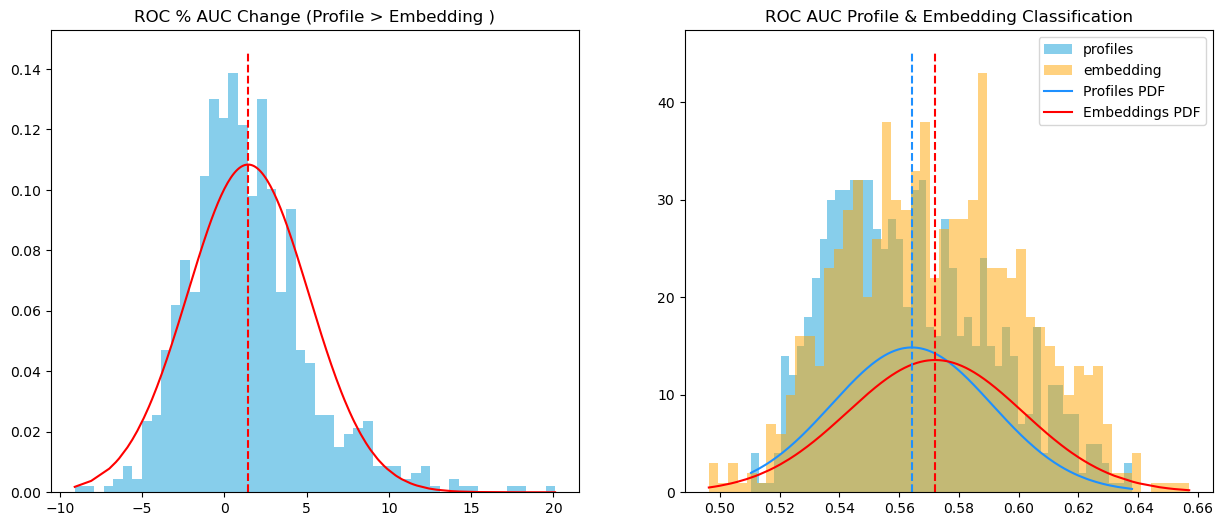

In [38]:
fig, axes = plt.subplots(1,2, figsize=(15,6))
bins_d = df_metrics.ms_diff_pct
bins_p = df_metrics.mean_test_score_p.to_numpy()
bins_e = df_metrics.mean_test_score_e.to_numpy()

bins = axes[0].hist(df_metrics.ms_diff_pct, color ='skyblue', bins=50, density = True )
y0,y1 = axes[0].get_ylim()
plot_norm(df_metrics.ms_diff_pct, axes[0], label = 'pdf')
_ = axes[0].set_title('ROC % AUC Change (Profile > Embedding )')
_ = axes[0].vlines(df_metrics.ms_diff_pct.mean(), y0,y1, linestyle = 'dashed', color = 'red')

_ = axes[1].hist(df_metrics.mean_test_score_p, color ='skyblue', label= 'profiles', bins=50, density = False)
_ = axes[1].hist(df_metrics.mean_test_score_e, color = 'orange', label='embedding', bins=50, alpha = 0.5, density = False)
y0,y1 = axes[1].get_ylim()
plot_norm(df_metrics.mean_test_score_p, axes[1], color = 'dodgerblue', label = 'Profiles PDF')
plot_norm(df_metrics.mean_test_score_e, axes[1], color = 'red', label = 'Embeddings PDF')
_ = axes[1].vlines(df_metrics.mean_test_score_p.mean(), y0,y1, linestyle = 'dashed', color = 'dodgerblue')
_ = axes[1].vlines(df_metrics.mean_test_score_e.mean(), y0,y1, linestyle = 'dashed', color = 'red')
_ = axes[1].set(title='ROC AUC Profile & Embedding Classification')
_ = axes[1].legend()

for col, name in [('ms_diff_pct', 'ROC AUC Change %'), ('mean_test_score_p', 'ROC AUC Profiles'), ('mean_test_score_e', 'ROC_AUC Emebdding') ]:
    print(f"{name:20s}:    mean: {df_metrics[col].mean():8.5f}   std: {df_metrics[col].std():8.5f}   min: {df_metrics[col].min():8.5f}   max: {df_metrics[col].max():8.5f}")
print('\n')

In [45]:
# grp = -5
# indicies =df_metrics[df_metrics.ms_diff_grp == grp].index
# print(indicies)
# df_metrics.loc[indicies]
# df_metrics.loc[indicies, ['Y_bit', 'mean_test_score_p', 'mean_test_score_e','Y_bit_pct', 'ms_diff']]

## Histograms 

-5 11


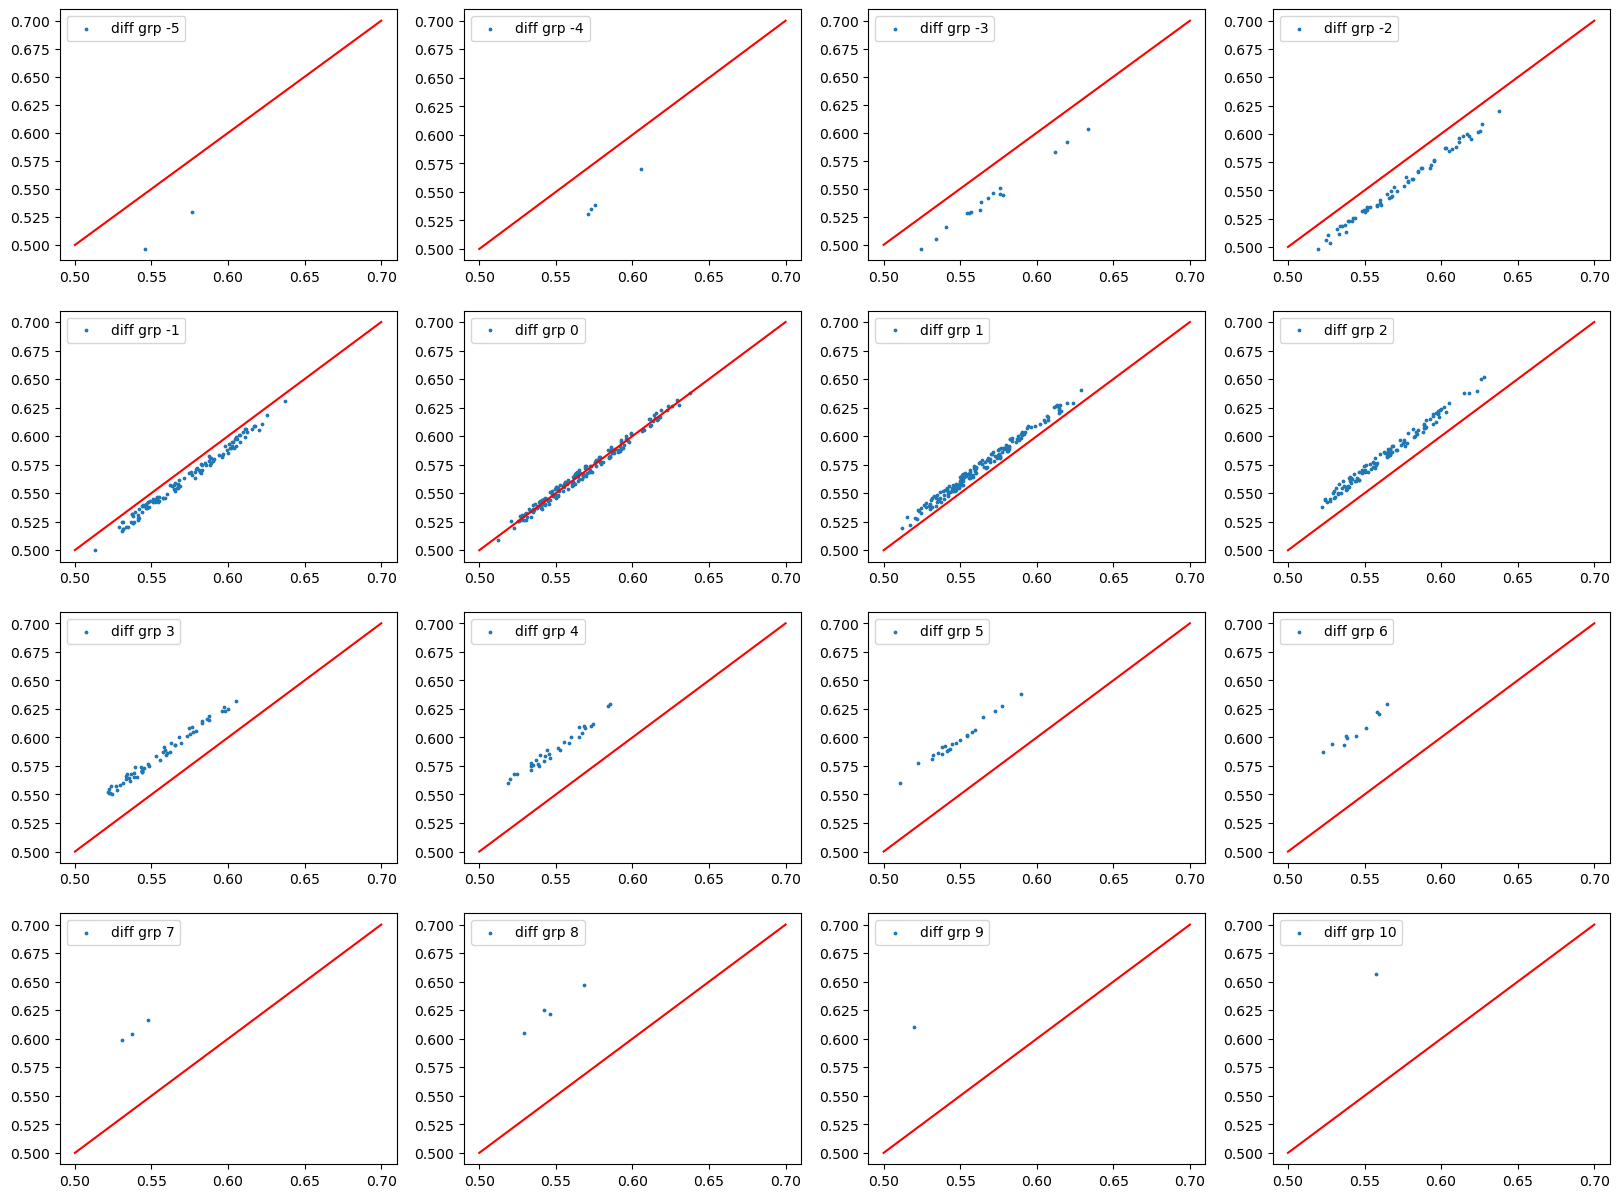

In [47]:
# _ = plt.figure(figsize = (15,15))
col = 'ms_diff_grp'
MIN = df_metrics[col].min().astype(np.int8)
MAX = df_metrics[col].max().astype(np.int8)
print(MIN, MAX)
fig, axes = plt.subplots(4,4, figsize=(20,15))
# type(fig), type(axes), axes.shape, type(axes.flat)
for ax, grp in zip(axes.flat, range(MIN,MAX)):
    indicies = (df_metrics.ms_diff_grp == grp)
 
    _ = ax.scatter(df_metrics[indicies].mean_test_score_p, df_metrics[indicies].mean_test_score_e, s= 3.0, label = f'diff grp {grp}')
    _ = ax.plot([0.5,0.7],[0.5,0.7], color = 'r')
    _ = ax.legend()

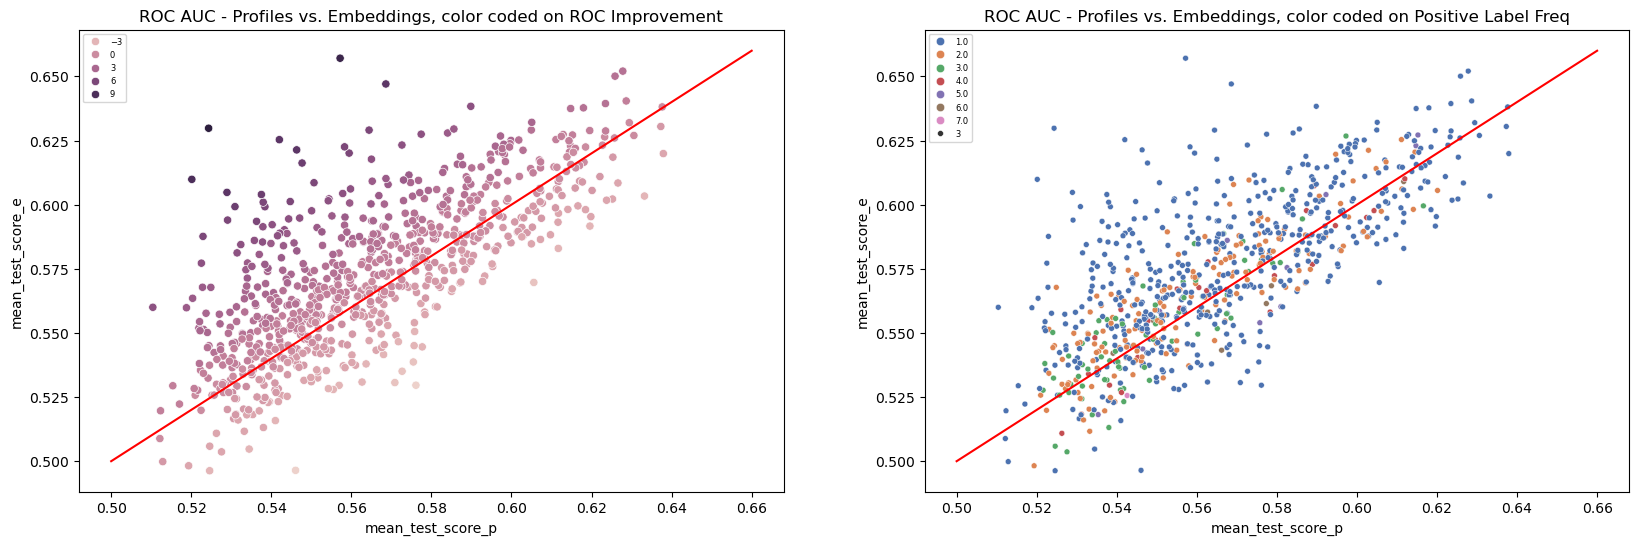

In [49]:
# plt.figure(figsize = (10,6))
fig, axes = plt.subplots(1,2, figsize=(20,6))
_ = sns.scatterplot(data= df_metrics, x = 'mean_test_score_p', y = 'mean_test_score_e', hue = 'ms_diff_grp', legend ='brief', ax = axes[0])
_ = sns.scatterplot(data= df_metrics, x = 'mean_test_score_p', y = 'mean_test_score_e', hue = 'Y_bit_pct_grp', palette = 'deep', legend ='brief',size = 3, ax = axes[1])
_ = axes[0].set_title('ROC AUC - Profiles vs. Embeddings, color coded on ROC Improvement')
_ = axes[0].legend(fontsize='6', title_fontsize='12')
_ = axes[0].plot([0.5,0.66],[0.5,0.66], color = 'r')
_ = axes[1].set_title('ROC AUC - Profiles vs. Embeddings, color coded on Positive Label Freq')
_ = axes[1].legend(fontsize='6', title_fontsize='12')
_ = axes[1].plot([0.5,0.66],[0.5,0.66], color = 'r')
# plt.plot([0.5,0.65],[0.5,0.65], color = 'r')

In [42]:
# _ = plt.figure(figsize = (12,12))
# _ = sns.scatterplot(data= df_metrics, x = 'mean_test_score_p', y = 'mean_test_score_e', hue = 'ms_diff_grp', palette = 'deep', legend ='brief', size = 3)
# _ = plt.legend(fontsize='6', title_fontsize='14')
# _ = plt.title('ROC AUC - Profiles vs. Embeddings, grouped by ROC_AUC Difference')
# _ = plt.plot([0.5,0.65],[0.5,0.65], color = 'r')

## List Metrics - ROC_AVG 

In [48]:
# df_metrics.loc[indicies,['Y_bit', 'Y_bit_pct', 'mean_test_score_p', 'mean_test_score_e', 'ms_diff', 'ms_diff_grp', 'ms_diff_pct',  'ms_diff_pct_grp', 'Y_bit_description']]
indicies_all = df_metrics.sort_values('roc_avg', ascending = False).index
df_metrics.loc[indicies_all][[	'Y_bit',	'Y_bit_pct',	'Y_bit_pct_grp',	'mean_test_score_p',	'mean_test_score_e',		'roc_avg','fp_groups', 'Y_bit_description', 'ms_diff',]]

Y_bit  Y_bit_pct  Y_bit_pct_grp  mean_test_score_p  mean_test_score_e   roc_avg                             fp_groups  \
676   5833   0.055985            1.0           0.627805           0.652056  0.639931  Aromatic Hydrophobe LumpedHydrophobe   
59     114   0.066429            1.0           0.625867           0.650090  0.637979           Hydrophobe LumpedHydrophobe   
63     123   0.056039            1.0           0.637659           0.638103  0.637881               Hydrophobe PosIonizable   
581   4503   0.056407            1.0           0.628656           0.640425  0.634540          Aromatic Aromatic Hydrophobe   
35      67   0.103604            1.0           0.637304           0.630470  0.633887                 Aromatic PosIonizable   
..     ...        ...            ...                ...                ...       ...                                   ...   
393   2013   0.275065            3.0           0.524619           0.505850  0.515234             Acceptor Donor Hydrophobe   
189    635   0.081255            1.0           0.512162           0.508828  0.510495    Acceptor Acceptor LumpedHydrophobe   
439   2131   0.079773            1.0           0.524599           0.496291  0.510445       Acceptor Donor LumpedHydrophobe   
432   2121   0.226017            2.0           0.519352           0.498229  0.508790       Acceptor Donor LumpedHydrophobe   
88     296   0.099253            1.0           0.512885           0.499839  0.506362            Acceptor Acceptor Aromatic   

                                     Y_bit_description   ms_diff  
676  Aromatic Hydrophobe LumpedHydrophobe |0 0 1|0 ...  0.024252  
59               Hydrophobe LumpedHydrophobe |0 4|4 0|  0.024223  
63                   Hydrophobe PosIonizable |0 3|3 0|  0.000444  
581   Aromatic Aromatic Hydrophobe |0 1 2|1 0 1|2 1 0|  0.011769  
35                     Aromatic PosIonizable |0 2|2 0| -0.006834  
..                                                 ...       ...  
393      Acceptor Donor Hydrophobe |0 1 1|1 0 2|1 2 0| -0.018769  
189  Acceptor Acceptor LumpedHydrophobe |0 0 1|0 0 ... -0.003333  
439  Acceptor Donor LumpedHydrophobe |0 1 2|1 0 2|2... -0.028308  
432  Acceptor Donor LumpedHydrophobe |0 1 0|1 0 1|0... -0.021123  
88      Acceptor Acceptor Aromatic |0 0 1|0 0 0|1 0 0| -0.013046  

[803 rows x 9 columns]

In [49]:
indicies_1 = indicies_all[:50]
indicies_2 = indicies_all[-50:]
indicies_1
indicies_2
# indicies = df_metrics[df_metrics.ms_diff_pct_grp <= -5.0].sort_values('ms_diff_pct').index
# display_metrics(df_metrics, indicies)
df_sav =df_metrics.loc[indicies_1][[	'Y_bit',	'Y_bit_pct',	'Y_bit_pct_grp',	'mean_test_score_p',	'mean_test_score_e', 'roc_avg','fp_groups', 'Y_bit_description', 'ms_diff',]]
df_sav.info()
df_sav
df_sav.to_csv("best_fifty_bins_0_3_6.csv", index = False)


df_sav =df_metrics.loc[indicies_2][[	'Y_bit',	'Y_bit_pct',	'Y_bit_pct_grp',	'mean_test_score_p',	'mean_test_score_e', 'roc_avg','fp_groups', 'Y_bit_description', 'ms_diff',]]
df_sav
df_sav.to_csv("worst_fifty_bins_0_3_6.csv", index = False)

Index([676,  59,  63, 581,  35, 802, 582, 662,  17, 799,  28, 684,  67, 558, 791, 671, 331,  30, 562,  54, 691, 556, 578,  19, 784,
       792,  66, 688, 538,  65, 341, 330, 589, 461, 672, 797, 687, 787, 614, 544, 560, 587, 541, 785,  58, 674,  62,  64, 643,
        16],
      dtype='int64')

Index([ 98, 398, 102, 517, 256, 395, 258, 244,  79, 267, 616, 427, 118, 438, 389, 161, 711, 113, 176, 434, 404, 598, 157, 206, 380,
       719, 407, 396, 160, 383, 741, 324, 429, 257, 198, 156, 401, 152, 261, 615, 150, 447, 166, 175, 246, 393, 189, 439, 432,
        88],
      dtype='int64')

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, 676 to 16
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Y_bit              50 non-null     int64  
 1   Y_bit_pct          50 non-null     float64
 2   Y_bit_pct_grp      50 non-null     float64
 3   mean_test_score_p  50 non-null     float64
 4   mean_test_score_e  50 non-null     float64
 5   roc_avg            50 non-null     float64
 6   fp_groups          50 non-null     object 
 7   Y_bit_description  50 non-null     object 
 8   ms_diff            50 non-null     float64
dtypes: float64(6), int64(1), object(2)
memory usage: 3.9+ KB


Y_bit  Y_bit_pct  Y_bit_pct_grp  mean_test_score_p  mean_test_score_e   roc_avg  \
676   5833   0.055985            1.0           0.627805           0.652056  0.639931   
59     114   0.066429            1.0           0.625867           0.650090  0.637979   
63     123   0.056039            1.0           0.637659           0.638103  0.637881   
581   4503   0.056407            1.0           0.628656           0.640425  0.634540   
35      67   0.103604            1.0           0.637304           0.630470  0.633887   
802  10375   0.066937            1.0           0.623472           0.639403  0.631437   
582   4508   0.083658            1.0           0.629425           0.631947  0.630686   
662   5743   0.063377            1.0           0.637935           0.619909  0.628922   
17      33   0.085000            1.0           0.630579           0.626966  0.628773   
799   9956   0.084632            1.0           0.617975           0.637737  0.627856   
28      54   0.073268            1.0           0.614782           0.637469  0.626126   
684   5856   0.068539            1.0           0.623512           0.628737  0.626124   
67     133   0.096472            1.0           0.625737           0.625996  0.625867   
558   3187   0.054827            1.0           0.623280           0.626415  0.624847   
791   9911   0.068106            1.0           0.619545           0.628883  0.624214   
671   5790   0.100032            1.0           0.622732           0.623190  0.622961   
331   1406   0.054361            1.0           0.625330           0.618514  0.621922   
30      56   0.503755            5.0           0.615236           0.627155  0.621195   
562   4324   0.053268            1.0           0.618510           0.622478  0.620494   
54     109   0.072814            1.0           0.612903           0.627345  0.620124   
691   6303   0.094773            1.0           0.614366           0.624897  0.619631   
556   3168   0.071450            1.0           0.612452           0.626635  0.619543   
578   4493   0.061061            1.0           0.615934           0.621932  0.618933   
19      41   0.521807            5.0           0.614742           0.622969  0.618856   
784   9862   0.124643            1.0           0.605063           0.632088  0.618576   
792   9912   0.059275            1.0           0.633217           0.603351  0.618284   
66     132   0.200898            2.0           0.611112           0.625372  0.618242   
688   5875   0.078539            1.0           0.615454           0.620403  0.617929   
538   2758   0.076169            1.0           0.626594           0.608445  0.617520   
65     131   0.239675            2.0           0.614493           0.620492  0.617493   
341   1437   0.071710            1.0           0.618120           0.616550  0.617335   
330   1396   0.050216            1.0           0.604948           0.629100  0.617024   
589   4595   0.115476            1.0           0.622089           0.610946  0.616517   
461   2356   0.060498            1.0           0.613858           0.618638  0.616248   
672   5793   0.093918            1.0           0.617006           0.615229  0.616118   
797   9933   0.087738            1.0           0.614824           0.615657  0.615240   
687   5865   0.059199            1.0           0.616037           0.614345  0.615191   
787   9901   0.077186            1.0           0.589837           0.638330  0.614083   
614   5165   0.062857            1.0           0.625229           0.602195  0.613712   
544   2920   0.058128            1.0           0.601822           0.625192  0.613507   
560   4267   0.057933            1.0           0.613724           0.612939  0.613332   
587   4551   0.065660            1.0           0.617705           0.608839  0.613272   
541   2901   0.051439            1.0           0.617017           0.609183  0.613100   
785   9866   0.086753            1.0           0.611347           0.614577  0.612962   
58     113   0.232121            2.0         

Y_bit  Y_bit_pct  Y_bit_pct_grp  mean_test_score_p  mean_test_score_e   roc_avg                             fp_groups  \
98     323   0.164069            2.0           0.538161           0.523720  0.530941            Acceptor Acceptor Aromatic   
398   2022   0.111602            1.0           0.537903           0.523648  0.530776             Acceptor Donor Hydrophobe   
102    335   0.150368            2.0           0.529812           0.531706  0.530759            Acceptor Acceptor Aromatic   
517   2700   0.097706            1.0           0.536435           0.525036  0.530735  Acceptor Hydrophobe LumpedHydrophobe   
256   1217   0.280390            3.0           0.531413           0.529292  0.530353               Acceptor Aromatic Donor   
395   2017   0.347879            3.0           0.522036           0.538081  0.530059             Acceptor Donor Hydrophobe   
258   1221   0.241374            2.0           0.527970           0.530539  0.529254               Acceptor Aromatic Donor   
244   1197   0.270433            3.0           0.528523           0.529950  0.529236               Acceptor Aromatic Donor   
79     258   0.112186            1.0           0.522325           0.535457  0.528891            Acceptor Acceptor Acceptor   
267   1241   0.178918            2.0           0.527766           0.529891  0.528828               Acceptor Aromatic Donor   
616   5172   0.187348            2.0           0.523040           0.534271  0.528655             Aromatic Donor Hydrophobe   
427   2105   0.207911            2.0           0.530319           0.526753  0.528536       Acceptor Donor LumpedHydrophobe   
118    391   0.067976            1.0           0.541019           0.515827  0.528423            Acceptor Acceptor Aromatic   
438   2130   0.236840            2.0           0.536987           0.519625  0.528306       Acceptor Donor LumpedHydrophobe   
389   2008   0.328701            3.0           0.524201           0.532392  0.528297             Acceptor Donor Hydrophobe   
161    549   0.193052            2.0           0.526323           0.529985  0.528154          Acceptor Acceptor Hydrophobe   
711   7662   0.075747            1.0           0.529370           0.526812  0.528091          Donor Donor LumpedHydrophobe   
113    369   0.266190            3.0           0.531293           0.524346  0.527820            Acceptor Acceptor Aromatic   
176    595   0.200736            2.0           0.527203           0.528260  0.527731          Acceptor Acceptor Hydrophobe   
434   2124   0.165357            2.0           0.530881           0.524443  0.527662       Acceptor Donor LumpedHydrophobe   
404   2036   0.276331            3.0           0.528040           0.526759  0.527400             Acceptor Donor Hydrophobe   
598   5063   0.086180            1.0           0.534339           0.520023  0.527181                  Aromatic Donor Donor   
157    542   0.457468            5.0           0.535351           0.518172  0.526761          Acceptor Acceptor Hydrophobe   
206    685   0.239426            2.0           0.533082           0.520307  0.526695    Acceptor Acceptor LumpedHydrophobe   
380   1988   0.299870            3.0           0.533878           0.518084  0.525981             Acceptor Donor Hydrophobe   
719   8109   0.331721            3.0           0.525724           0.525762  0.525743           Donor Hydrophobe Hydrophobe   
407   2040   0.271829            3.0           0.538032           0.513132  0.525582             Acceptor Donor Hydrophobe   
396   2018   0.135173            1.0           0.525202           0.525742  0.525472             Acceptor Donor Hydrophobe   
160    548   0.437944            4.0           0.531178           0.518343  0.524761          Acceptor Acceptor Hydrophobe   
383   1992   0.335368            3.0           0.521608           0.527681  0.524644             Acceptor Donor Hydrophobe   
741   8206   0.144805            1.0           0.529030           0.520167  0.524598     Donor Hydr

In [50]:
df_sav = pd.read_csv("best_fifty_bins_0_3_6.csv")
df_sav
df_sav = pd.read_csv("worst_fifty_bins_0_3_6.csv")
df_sav

Y_bit  Y_bit_pct  Y_bit_pct_grp  mean_test_score_p  mean_test_score_e   roc_avg                                     fp_groups  \
0    5833   0.055985            1.0           0.627805           0.652056  0.639931          Aromatic Hydrophobe LumpedHydrophobe   
1     114   0.066429            1.0           0.625867           0.650090  0.637979                   Hydrophobe LumpedHydrophobe   
2     123   0.056039            1.0           0.637659           0.638103  0.637881                       Hydrophobe PosIonizable   
3    4503   0.056407            1.0           0.628656           0.640425  0.634540                  Aromatic Aromatic Hydrophobe   
4      67   0.103604            1.0           0.637304           0.630470  0.633887                         Aromatic PosIonizable   
5   10375   0.066937            1.0           0.623472           0.639403  0.631437  Hydrophobe LumpedHydrophobe LumpedHydrophobe   
6    4508   0.083658            1.0           0.629425           0.631947  0.630686                  Aromatic Aromatic Hydrophobe   
7    5743   0.063377            1.0           0.637935           0.619909  0.628922                Aromatic Hydrophobe Hydrophobe   
8      33   0.085000            1.0           0.630579           0.626966  0.628773                         Acceptor PosIonizable   
9    9956   0.084632            1.0           0.617975           0.637737  0.627856        Hydrophobe Hydrophobe LumpedHydrophobe   
10     54   0.073268            1.0           0.614782           0.637469  0.626126                           Aromatic Hydrophobe   
11   5856   0.068539            1.0           0.623512           0.628737  0.626124          Aromatic Hydrophobe LumpedHydrophobe   
12    133   0.096472            1.0           0.625737           0.625996  0.625867             LumpedHydrophobe LumpedHydrophobe   
13   3187   0.054827            1.0           0.623280           0.626415  0.624847    Acceptor LumpedHydrophobe LumpedHydrophobe   
14   9911   0.068106            1.0           0.619545           0.628883  0.624214        Hydrophobe Hydrophobe LumpedHydrophobe   
15   5790   0.100032            1.0           0.622732           0.623190  0.622961                Aromatic Hydrophobe Hydrophobe   
16   1406   0.054361            1.0           0.625330           0.618514  0.621922                  Acceptor Aromatic Hydrophobe   
17     56   0.503755            5.0           0.615236           0.627155  0.621195                     Aromatic LumpedHydrophobe   
18   4324   0.053268            1.0           0.618510           0.622478  0.620494                    Aromatic Aromatic Aromatic   
19    109   0.072814            1.0           0.612903           0.627345  0.620124                         Hydrophobe Hydrophobe   
20   6303   0.094773            1.0           0.614366           0.624897  0.619631    Aromatic LumpedHydrophobe LumpedHydrophobe   
21   3168   0.071450            1.0           0.612452           0.626635  0.619543    Acceptor LumpedHydrophobe LumpedHydrophobe   
22   4493   0.061061            1.0           0.615934           0.621932  0.618933                  Aromatic Aromatic Hydrophobe   
23     41   0.521807            5.0           0.614742           0.622969  0.618856                             Aromatic Aromatic   
24   9862   0.124643            1.0           0.605063           0.632088  0.618576              Hydrophobe Hydrophobe Hydrophobe   
25   9912   0.059275            1.0           0.633217           0.603351  0.618284        Hydrophobe Hydrophobe LumpedHydrophobe   
26    132   0.200898            2.0           0.611112           0.625372  0.618242             LumpedHydrophobe LumpedHydrophobe   
27   5875   0.078539            1.0           0.615454           0.620403  0.617929          Aromatic Hydrophobe LumpedHydrophobe   
28   2758   0.076169            1.0           0.626594           0.608445  0.617520          Acceptor Hydrophobe LumpedHydrophobe   
29    131   0.

Y_bit  Y_bit_pct  Y_bit_pct_grp  mean_test_score_p  mean_test_score_e   roc_avg                             fp_groups  \
0     323   0.164069            2.0           0.538161           0.523720  0.530941            Acceptor Acceptor Aromatic   
1    2022   0.111602            1.0           0.537903           0.523648  0.530776             Acceptor Donor Hydrophobe   
2     335   0.150368            2.0           0.529812           0.531706  0.530759            Acceptor Acceptor Aromatic   
3    2700   0.097706            1.0           0.536435           0.525036  0.530735  Acceptor Hydrophobe LumpedHydrophobe   
4    1217   0.280390            3.0           0.531413           0.529292  0.530353               Acceptor Aromatic Donor   
5    2017   0.347879            3.0           0.522036           0.538081  0.530059             Acceptor Donor Hydrophobe   
6    1221   0.241374            2.0           0.527970           0.530539  0.529254               Acceptor Aromatic Donor   
7    1197   0.270433            3.0           0.528523           0.529950  0.529236               Acceptor Aromatic Donor   
8     258   0.112186            1.0           0.522325           0.535457  0.528891            Acceptor Acceptor Acceptor   
9    1241   0.178918            2.0           0.527766           0.529891  0.528828               Acceptor Aromatic Donor   
10   5172   0.187348            2.0           0.523040           0.534271  0.528655             Aromatic Donor Hydrophobe   
11   2105   0.207911            2.0           0.530319           0.526753  0.528536       Acceptor Donor LumpedHydrophobe   
12    391   0.067976            1.0           0.541019           0.515827  0.528423            Acceptor Acceptor Aromatic   
13   2130   0.236840            2.0           0.536987           0.519625  0.528306       Acceptor Donor LumpedHydrophobe   
14   2008   0.328701            3.0           0.524201           0.532392  0.528297             Acceptor Donor Hydrophobe   
15    549   0.193052            2.0           0.526323           0.529985  0.528154          Acceptor Acceptor Hydrophobe   
16   7662   0.075747            1.0           0.529370           0.526812  0.528091          Donor Donor LumpedHydrophobe   
17    369   0.266190            3.0           0.531293           0.524346  0.527820            Acceptor Acceptor Aromatic   
18    595   0.200736            2.0           0.527203           0.528260  0.527731          Acceptor Acceptor Hydrophobe   
19   2124   0.165357            2.0           0.530881           0.524443  0.527662       Acceptor Donor LumpedHydrophobe   
20   2036   0.276331            3.0           0.528040           0.526759  0.527400             Acceptor Donor Hydrophobe   
21   5063   0.086180            1.0           0.534339           0.520023  0.527181                  Aromatic Donor Donor   
22    542   0.457468            5.0           0.535351           0.518172  0.526761          Acceptor Acceptor Hydrophobe   
23    685   0.239426            2.0           0.533082           0.520307  0.526695    Acceptor Acceptor LumpedHydrophobe   
24   1988   0.299870            3.0           0.533878           0.518084  0.525981             Acceptor Donor Hydrophobe   
25   8109   0.331721            3.0           0.525724           0.525762  0.525743           Donor Hydrophobe Hydrophobe   
26   2040   0.271829            3.0           0.538032           0.513132  0.525582             Acceptor Donor Hydrophobe   
27   2018   0.135173            1.0           0.525202           0.525742  0.525472             Acceptor Donor Hydrophobe   
28    548   0.437944            4.0           0.531178           0.518343  0.524761          Acceptor Acceptor Hydrophobe   
29   1992   0.335368            3.0           0.521608           0.527681  0.524644             Acceptor Donor Hydrophobe   
30   8206   0.144805            1.0           0.529030           0.520167  0.524598     Donor Hydrophobe LumpedHydrophobe   
31  

## List Metrics - ROC Diff Pct

In [50]:
# df_metrics.loc[indicies,['Y_bit', 'Y_bit_pct', 'mean_test_score_p', 'mean_test_score_e', 'ms_diff', 'ms_diff_grp', 'ms_diff_pct',  'ms_diff_pct_grp', 'Y_bit_description']]
# df_metrics.loc[indicies,['Y_bit', 'Y_bit_pct', 'mean_test_score_p', 'mean_test_score_e', 'ms_diff', 'ms_diff_grp', 'ms_diff_pct',  'ms_diff_pct_grp', 'Y_bit_description']]
indicies = df_metrics[df_metrics.ms_diff_pct_grp <= -5.0].sort_values('ms_diff_pct').index
display_metrics(df_metrics, indicies)

 Number of rows: 20
                                         Profile       Embedding       ROC Diff   
   index      FP bit       Freq %        ROC AUC        ROC AUC           Pct         Description 
   -----      ------     ----------     ---------      ---------       --------       ----------------------------------
     261      1226        0.07478        0.54606        0.49644         -9.10         Acceptor Aromatic Donor |0 1 2|1 0 1|2 1 0|       
     146       506        0.08351        0.57613        0.52962         -8.10         Acceptor Acceptor Donor |0 4 2|4 0 2|2 2 0|       
     117       380        0.07400        0.57087        0.53065         -7.00         Acceptor Acceptor Aromatic |0 3 4|3 0 1|4 1 0|    
     458      2182        0.06241        0.57268        0.53507         -6.60         Acceptor Donor LumpedHydrophobe |0 3 3|3 0 0|3 0 0|
     712      7666        0.05420        0.57548        0.53868         -6.40         Donor Donor LumpedHydrophobe |0 1 2|1 0 0|

In [45]:
indicies = df_metrics[df_metrics.ms_diff_pct_grp >= 10].sort_values('ms_diff_pct').index
display_metrics(df_metrics, indicies)

 Number of rows: 25
                                         Profile       Embedding       ROC Diff   
   index      FP bit       Freq %        ROC AUC        ROC AUC           Pct         Description 
   -----      ------     ----------     ---------      ---------       --------       ----------------------------------
     378      1948        0.08423        0.54021        0.59218          9.60         Acceptor Donor Donor |0 3 1|3 0 2|1 2 0|          
     154       532        0.05603        0.51041        0.56000          9.70         Acceptor Acceptor Hydrophobe |0 0 3|0 0 2|3 2 0|  
     757      8238        0.05054        0.53238        0.58444          9.80         Donor Hydrophobe LumpedHydrophobe |0 1 3|1 0 2|3 2 0|
     736      8163        0.08557        0.53790        0.59138          9.90         Donor Hydrophobe Hydrophobe |0 3 1|3 0 2|1 2 0|   
     457      2170        0.05584        0.54473        0.60121         10.40         Acceptor Donor LumpedHydrophobe |0 3 0|3

In [51]:
indicies = df_metrics[df_metrics.ms_diff_pct_grp.between(5.0, 10.0, 'right')].sort_values('ms_diff_pct').index
display_metrics(df_metrics, indicies)

 Number of rows: 74
                                         Profile       Embedding       ROC Diff   
   index      FP bit       Freq %        ROC AUC        ROC AUC           Pct         Description 
   -----      ------     ----------     ---------      ---------       --------       ----------------------------------
     746      8216        0.05090        0.52220        0.55087          5.50         Donor Hydrophobe LumpedHydrophobe |0 0 3|0 0 2|3 2 0|
     394      2016        0.18118        0.53500        0.56437          5.50         Acceptor Donor Hydrophobe |0 1 2|1 0 0|2 0 0|     
     742      8207        0.20260        0.56824        0.60022          5.60         Donor Hydrophobe LumpedHydrophobe |0 0 1|0 0 1|1 1 0|
     463      2553        0.09924        0.53327        0.56330          5.60         Acceptor Hydrophobe Hydrophobe |0 0 0|0 0 0|0 0 0|
     734      8159        0.06907        0.56294        0.59474          5.60         Donor Hydrophobe Hydrophobe |0 3 0|3 

In [52]:
indicies = df_metrics[df_metrics.ms_diff_pct_grp.between(-5.0, 0, 'right')].sort_values('ms_diff_pct').index
display_metrics(df_metrics, indicies)

 Number of rows: 334
                                         Profile       Embedding       ROC Diff   
   index      FP bit       Freq %        ROC AUC        ROC AUC           Pct         Description 
   -----      ------     ----------     ---------      ---------       --------       ----------------------------------
     246      1201        0.30087        0.52757        0.50365         -4.50         Acceptor Aromatic Donor |0 0 1|0 0 1|1 1 0|       
     225      1085        0.06741        0.61959        0.59165         -4.50         Acceptor Aromatic Aromatic |0 0 0|0 0 1|0 1 0|    
     642      5273        0.08622        0.57175        0.54658         -4.40         Aromatic Donor LumpedHydrophobe |0 0 2|0 0 1|2 1 0|
     680      5839        0.07575        0.57581        0.55055         -4.40         Aromatic Hydrophobe LumpedHydrophobe |0 0 2|0 0 2|2 2 0|
     595      5059        0.13869        0.56104        0.53743         -4.20         Aromatic Donor Donor |0 1 0|1 0 1|0

In [53]:
indicies = df_metrics[df_metrics.ms_diff_pct_grp.between(-5.0, 0, 'right')].index
display_metrics(df_metrics, indicies)

 Number of rows: 334
                                         Profile       Embedding       ROC Diff   
   index      FP bit       Freq %        ROC AUC        ROC AUC           Pct         Description 
   -----      ------     ----------     ---------      ---------       --------       ----------------------------------
       1         2        0.69734        0.54259        0.52561         -3.10         Acceptor Acceptor |0 2|2 0|                       
       2         3        0.44674        0.53818        0.52965         -1.60         Acceptor Acceptor |0 3|3 0|                       
       3         4        0.20815        0.56444        0.54700         -3.10         Acceptor Acceptor |0 4|4 0|                       
       4         8        0.44268        0.57831        0.55815         -3.50         Acceptor Aromatic |0 3|3 0|                       
       5         9        0.14927        0.59332        0.57217         -3.60         Acceptor Aromatic |0 4|4 0|               

In [54]:
indicies = df_metrics.sort_values(['fp_groups', 'ms_diff_pct']).index
display_metrics(df_metrics, indicies)

 Number of rows: 803
                                         Profile       Embedding       ROC Diff   
   index      FP bit       Freq %        ROC AUC        ROC AUC           Pct         Description 
   -----      ------     ----------     ---------      ---------       --------       ----------------------------------
       1         2        0.69734        0.54259        0.52561         -3.10         Acceptor Acceptor |0 2|2 0|                       
       3         4        0.20815        0.56444        0.54700         -3.10         Acceptor Acceptor |0 4|4 0|                       
       2         3        0.44674        0.53818        0.52965         -1.60         Acceptor Acceptor |0 3|3 0|                       
       0         0        0.51183        0.55069        0.55843          1.40         Acceptor Acceptor |0 0|0 0|                       
      74       228        0.23953        0.55799        0.53717         -3.70         Acceptor Acceptor Acceptor |0 2 1|2 0 1|1 

## Group by fp_groups

In [ ]:
grouped_data = df_metrics.sort_values(['fp_groups', 'ms_diff_pct'], ascending=True).groupby('fp_groups')   # group_keys = 'ms_diff_pct')
grouped_data_indicies = grouped_data.groups
pp.pprint(grouped_data_indicies)

In [64]:
for grp in grouped_data:
    print(len(grp), grp[0], '\n')
    df_data = grp[1]
    df_data[['index_p', 'Y_bit', 'Y_bit_pct', 'mean_test_score_p', 'mean_test_score_e', 'ms_diff', 'ms_diff_pct', 'Y_bit_description']]

2 Acceptor Acceptor 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct            Y_bit_description
1        1      2   0.697338           0.542591           0.525606 -0.016985         -3.1  Acceptor Acceptor |0 2|2 0|
3        3      4   0.208149           0.564437           0.547004 -0.017433         -3.1  Acceptor Acceptor |0 4|4 0|
2        2      3   0.446742           0.538184           0.529650 -0.008534         -1.6  Acceptor Acceptor |0 3|3 0|
0        0      0   0.511829           0.550693           0.558431  0.007738          1.4  Acceptor Acceptor |0 0|0 0|

2 Acceptor Acceptor Acceptor 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct  \
74       74    228   0.239535           0.557991           0.537175 -0.020816         -3.7   
76       76    233   0.222110           0.539534           0.523175 -0.016359         -3.0   
77       77    256   0.067597           0.539202           0.522894 -0.016308         -3.0   
82       82    280   0.113463           0.546400           0.537184 -0.009216         -1.7   
78       78    257   0.311861           0.537546           0.531654 -0.005892         -1.1   
81       81    262   0.119123           0.535159           0.533730 -0.001429         -0.3   
71       71    203   0.256039           0.572902           0.573912  0.001010          0.2   
83       83    284   0.117706           0.542658           0.545369  0.002711          0.5   
84       84    285   0.092100           0.552524           0.557025  0.004501          0.8   
72       72    204   0.120022           0.541617           0.552687  0.011070          2.0   
75       75    232   0.304470           0.527978           0.541003  0.013025          2.5   
79       79    258   0.112186           0.522325           0.535457  0.013133          2.5   
80       80    261   0.161699           0.536143           0.560716  0.024573          4.6   
73       73    227   0.101861           0.527193           0.553532  0.026339          5.0   
85       85    288   0.069578           0.558409           0.595135  0.036726          6.6   
86       86    289   0.064026           0.555147           0.595607  0.040460          7.3   

                                 Y_bit_description  
74  Acceptor Acceptor Acceptor |0 2 1|2 0 1|1 1 0|  
76  Acceptor Acceptor Acceptor |0 2 2|2 0 1|2 1 0|  
77  Acceptor Acceptor Acceptor |0 3 2|3 0 0|2 0 0|  
82  Acceptor Acceptor Acceptor |0 4 2|4 0 2|2 2 0|  
78  Acceptor Acceptor Acceptor |0 3 2|3 0 1|2 1 0|  
81  Acceptor Acceptor Acceptor |0 3 3|3 0 1|3 1 0|  
71  Acceptor Acceptor Acceptor |0 1 1|1 0 0|1 0 0|  
83  Acceptor Acceptor Acceptor |0 4 3|4 0 1|3 1 0|  
84  Acceptor Acceptor Acceptor |0 4 3|4 0 2|3 2 0|  
72  Acceptor Acceptor Acceptor |0 1 1|1 0 1|1 1 0|  
75  Acceptor Acceptor Acceptor |0 2 2|2 0 0|2 0 0|  
79  Acceptor Acceptor Acceptor |0 3 2|3 0 2|2 2 0|  
80  Acceptor Acceptor Acceptor |0 3 3|3 0 0|3 0 0|  
73  Acceptor Acceptor Acceptor |0 2 1|2 0 0|1 0 0|  
85  Acceptor Acceptor Acceptor |0 4 4|4 0 0|4 0 0|  
86  Acceptor Acceptor Acceptor |0 4 4|4 0 1|4 1 0|

2 Acceptor Acceptor Aromatic 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct  \
117      117    380   0.074004           0.570867           0.530646 -0.040221         -7.0   
96        96    321   0.107771           0.556941           0.529571 -0.027370         -4.9   
118      118    391   0.067976           0.541019           0.515827 -0.025192         -4.7   
114      114    370   0.060801           0.567450           0.549569 -0.017882         -3.2   
98        98    323   0.164069           0.538161           0.523720 -0.014441         -2.7   
88        88    296   0.099253           0.512885           0.499839 -0.013046         -2.5   
116      116    375   0.124675           0.548110           0.537394 -0.010716         -2.0   
120      120    396   0.126548           0.551116           0.542352 -0.008764         -1.6   
107      107    350   0.070292           0.565014           0.557112 -0.007902         -1.4   
113      113    369   0.266190           0.531293           0.524346 -0.006946         -1.3   
119      119    392   0.101970           0.565629           0.558633 -0.006996         -1.2   
104      104    341   0.079177           0.544255           0.538520 -0.005735         -1.1   
106      106    346   0.283355           0.536974           0.531791 -0.005183         -1.0   
97        97    322   0.363539           0.545252           0.540439 -0.004813         -0.9   
115      115    374   0.178387           0.554739           0.552009 -0.002730         -0.5   
111      111    364   0.122110           0.539640           0.538820 -0.000820         -0.2   
94        94    316   0.368799           0.532950           0.533987  0.001037          0.2   
102      102    335   0.150368           0.529812           0.531706  0.001894          0.4   
110      110    357   0.084297           0.556113           0.558715  0.002602          0.5   
99        99    328   0.195736           0.542099           0.547106  0.005006          0.9   
108      108    351   0.254145           0.550313           0.555111  0.004798          0.9   
112      112    365   0.128734           0.547375           0.553081  0.005706          1.0   
105      105    345   0.362197           0.547795           0.554723  0.006929          1.3   
121      121    401   0.070909           0.588390           0.596672  0.008283          1.4   
109      109    352   0.112024           0.541795           0.550763  0.008968          1.7   
89        89    297   0.243496           0.534451           0.545706  0.011255          2.1   
91        91    302   0.219351           0.526410           0.539698  0.013288          2.5   
93        93    312   0.295952           0.531370           0.545940  0.014570          2.7   
92        92    307   0.103701           0.551959           0.568208  0.016249          2.9   
95        95    317   0.249405           0.530844           0.546304  0.015460          2.9   
90        90    301   0.060292           0.525709           0.542352  0.016644          3.2   
87        87    293   0.269134           0.537600           0.555172  0.017571          3.3   
103      103    340   0.420639           0.541036           0.559105  0.018069          3.3   
101      101    333   0.053907           0.548298           0.567325  0.019027          3.5   
100      100    329   0.065260           0.543942           0.571443  0.027501          5.1   

                                  Y_bit_description  
117  Acceptor Acceptor Aromatic |0 3 4|3 0 1|4 1 0|  
96   Acceptor Acceptor Aromatic |0 1 2|1 0 0|2 0 0|  
118  Acceptor Acceptor Aromatic |0 4 2|4 0 0|2 0 0|  
114  Acceptor Acceptor Aromatic |0 3 2|3 0 1|2 1 0|  
98   Acceptor Acceptor Aromatic |0 1 2|1 0 2|2 2 0|  
88   Acceptor Acceptor Aromatic |0 0 1|0 0 0|1 0 0|  
116  Acceptor Acceptor Aromatic |0 3 3|3 0 1|3 1 0|  
120  Acceptor Acceptor Aromatic |0 4 3|4 0 0|3 0 0|  
107  Acceptor Acceptor Aromatic |0 2 3|2 0 0|3 0 0|  
113  Acceptor Acceptor Aromatic |0 3 2|3 0 0

2 Acceptor Acceptor Donor 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct  \
146      146    506   0.083506           0.576127           0.529624 -0.046503         -8.1   
136      136    464   0.161786           0.551614           0.532465 -0.019149         -3.5   
138      138    470   0.063961           0.549976           0.530987 -0.018989         -3.5   
134      134    458   0.281223           0.541729           0.528279 -0.013450         -2.5   
123      123    410   0.201385           0.567056           0.554690 -0.012366         -2.2   
122      122    406   0.091331           0.551216           0.544588 -0.006629         -1.2   
130      130    436   0.121797           0.557625           0.553368 -0.004257         -0.8   
128      128    430   0.154297           0.540351           0.538310 -0.002041         -0.4   
141      141    483   0.244048           0.542310           0.540302 -0.002008         -0.4   
139      139    478   0.067468           0.535436           0.535400 -0.000036         -0.0   
127      127    429   0.301418           0.555529           0.558065  0.002535          0.5   
135      135    459   0.162359           0.546296           0.551024  0.004728          0.9   
129      129    435   0.254297           0.549441           0.555787  0.006346          1.2   
147      147    510   0.083117           0.545574           0.552161  0.006586          1.2   
131      131    441   0.139827           0.547256           0.556024  0.008768          1.6   
140      140    482   0.088680           0.527871           0.537476  0.009605          1.8   
148      148    511   0.055216           0.546351           0.561958  0.015607          2.9   
133      133    454   0.201407           0.545077           0.563036  0.017959          3.3   
144      144    488   0.068972           0.550484           0.569917  0.019432          3.5   
143      143    487   0.129567           0.531342           0.554430  0.023088          4.3   
125      125    415   0.180130           0.540530           0.564493  0.023963          4.4   
132      132    453   0.169848           0.533366           0.558156  0.024790          4.6   
145      145    505   0.050498           0.533554           0.566259  0.032705          6.1   
137      137    465   0.073182           0.545676           0.585073  0.039396          7.2   
124      124    414   0.070227           0.534068           0.577261  0.043192          8.1   
142      142    484   0.052413           0.522937           0.587631  0.064694         12.4   
126      126    420   0.064340           0.547685           0.616227  0.068542         12.5   

                               Y_bit_description  
146  Acceptor Acceptor Donor |0 4 2|4 0 2|2 2 0|  
136  Acceptor Acceptor Donor |0 2 3|2 0 1|3 1 0|  
138  Acceptor Acceptor Donor |0 2 4|2 0 2|4 2 0|  
134  Acceptor Acceptor Donor |0 2 2|2 0 0|2 0 0|  
123  Acceptor Acceptor Donor |0 0 1|0 0 1|1 1 0|  
122  Acceptor Acceptor Donor |0 0 0|0 0 0|0 0 0|  
130  Acceptor Acceptor Donor |0 1 2|1 0 2|2 2 0|  
128  Acceptor Acceptor Donor |0 1 1|1 0 1|1 1 0|  
141  Acceptor Acceptor Donor |0 3 2|3 0 1|2 1 0|  
139  Acceptor Acceptor Donor |0 3 1|3 0 1|1 1 0|  
127  Acceptor Acceptor Donor |0 1 1|1 0 0|1 0 0|  
135  Acceptor Acceptor Donor |0 2 2|2 0 1|2 1 0|  
129  Acceptor Acceptor Donor |0 1 2|1 0 1|2 1 0|  
147  Acceptor Acceptor Donor |0 4 3|4 0 1|3 1 0|  
131  Acceptor Acceptor Donor |0 1 3|1 0 2|3 2 0|  
140  Acceptor Acceptor Donor |0 3 2|3 0 0|2 0 0|  
148  Acceptor Acceptor Donor |0 4 3|4 0 2|3 2 0|  
133  Acceptor Acceptor Donor |0 2 1|2 0 1|1 1 0|  
144  Acceptor Acceptor Donor |0 3 3|3 0 1|3 1 0|  
143  Acceptor Acceptor Donor |0 3 3|3 0 0|3 0 0|  
125  Acceptor Acceptor Donor |0 0 2|0 0 2|2 2 0|  
132  Acceptor Acceptor Donor |0 2 1|2 0 0|1 0 0|  
145  Acceptor Acceptor Donor |0 4 2|4 0 1|2 1 0|  
137  Acceptor Acceptor Donor |0 2 3|2 0 2|3 2 0|  
124  Acceptor Acceptor Donor |0 0 2|0 0 1|2 1 0|  
142  Acceptor Acce

2 Acceptor Acceptor Hydrophobe 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct  \
169      169    572   0.290346           0.541761           0.523230 -0.018531         -3.4   
157      157    542   0.457468           0.535351           0.518172 -0.017179         -3.2   
166      166    566   0.400833           0.526287           0.510875 -0.015412         -2.9   
168      168    571   0.435660           0.541179           0.526796 -0.014382         -2.7   
160      160    548   0.437944           0.531178           0.518343 -0.012835         -2.4   
167      167    567   0.308550           0.540932           0.527761 -0.013171         -2.4   
171      171    577   0.337457           0.560252           0.549530 -0.010722         -1.9   
179      179    601   0.143247           0.548940           0.543233 -0.005707         -1.0   
174      174    584   0.065422           0.584914           0.580529 -0.004386         -0.7   
170      170    576   0.077338           0.568333           0.564775 -0.003557         -0.6   
176      176    595   0.200736           0.527203           0.528260  0.001057          0.2   
178      178    600   0.225411           0.535093           0.536315  0.001222          0.2   
158      158    543   0.297251           0.547316           0.549188  0.001872          0.3   
163      163    554   0.257186           0.530448           0.533072  0.002624          0.5   
149      149    519   0.289643           0.539660           0.542840  0.003180          0.6   
161      161    549   0.193052           0.526323           0.529985  0.003662          0.7   
156      156    538   0.187976           0.520988           0.525737  0.004750          0.9   
159      159    547   0.115606           0.534885           0.539588  0.004703          0.9   
187      187    628   0.074567           0.581017           0.586536  0.005520          0.9   
150      150    522   0.116504           0.517058           0.522275  0.005217          1.0   
162      162    553   0.056515           0.530220           0.536451  0.006231          1.2   
177      177    596   0.273604           0.531407           0.537635  0.006228          1.2   
180      180    606   0.125260           0.556213           0.562933  0.006720          1.2   
175      175    591   0.138788           0.512331           0.519668  0.007337          1.4   
164      164    555   0.095108           0.546912           0.556605  0.009693          1.8   
184      184    622   0.079729           0.550773           0.562608  0.011835          2.1   
185      185    623   0.123420           0.560587           0.572599  0.012012          2.1   
152      152    527   0.091483           0.515396           0.529418  0.014022          2.7   
186      186    627   0.084177           0.576185           0.591708  0.015523          2.7   
172      172    578   0.153463           0.543954           0.560664  0.016710          3.1   
182      182    618   0.097781           0.527291           0.544952  0.017662          3.3   
151      151    523   0.315216           0.535531           0.554765  0.019234          3.6   
173      173    583   0.132792           0.555350           0.577474  0.022125          4.0   
183      183    619   0.071407           0.553569           0.576002  0.022434          4.1   
165      165    559   0.091764           0.543994           0.570216  0.026222          4.8   
181      181    607   0.062197           0.586475           0.615773  0.029298          5.0   
153      153    528   0.240952           0.523064           0.551384  0.028320          5.4   
155      155    533   0.140812           0.536571           0.567868  0.031297          5.8   
154      154    532   0.056028           0.510406           0.559998  0.049592          9.7   

                                    Y_bit_description  
169  Acceptor Acceptor Hydrophobe |0 2 2|2 0 1|2 1 0|  
157  Acceptor Acceptor Hydrophobe |0 1 1|1 0 0|1 0 0|  
166  Acceptor Acceptor Hydrophobe |0

2 Acceptor Acceptor LumpedHydrophobe 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct  \
216      216    719   0.070227           0.563677           0.537923 -0.025754         -4.6   
198      198    662   0.124275           0.530606           0.516593 -0.014013         -2.6   
206      206    685   0.239426           0.533082           0.520307 -0.012776         -2.4   
207      207    689   0.062013           0.566927           0.554180 -0.012747         -2.2   
204      204    680   0.062478           0.546605           0.538099 -0.008506         -1.6   
196      196    660   0.087987           0.563258           0.556403 -0.006855         -1.2   
217      217    730   0.058842           0.542132           0.536084 -0.006049         -1.1   
197      197    661   0.307987           0.540818           0.536291 -0.004527         -0.8   
219      219    735   0.109470           0.560604           0.556164 -0.004440         -0.8   
189      189    635   0.081255           0.512162           0.508828 -0.003333         -0.7   
220      220    740   0.067316           0.585230           0.582202 -0.003027         -0.5   
191      191    641   0.169383           0.542722           0.540509 -0.002213         -0.4   
205      205    684   0.279307           0.540270           0.538746 -0.001524         -0.3   
202      202    674   0.116775           0.543852           0.544720  0.000868          0.2   
215      215    714   0.115541           0.554935           0.556313  0.001378          0.2   
208      208    690   0.215487           0.562147           0.564660  0.002514          0.4   
194      194    655   0.304556           0.532799           0.535913  0.003114          0.6   
213      213    708   0.210747           0.540700           0.544241  0.003541          0.7   
193      193    651   0.203766           0.534054           0.539143  0.005090          1.0   
190      190    636   0.193084           0.544571           0.551604  0.007034          1.3   
210      210    696   0.075833           0.548955           0.556338  0.007382          1.3   
209      209    691   0.089957           0.549994           0.558883  0.008889          1.6   
201      201    672   0.052781           0.552693           0.564768  0.012075          2.2   
211      211    703   0.099784           0.539964           0.552622  0.012658          2.3   
203      203    679   0.328712           0.556575           0.569967  0.013392          2.4   
214      214    713   0.149751           0.542756           0.556650  0.013894          2.6   
199      199    667   0.166201           0.532891           0.549513  0.016622          3.1   
188      188    632   0.201126           0.538963           0.556009  0.017046          3.2   
195      195    656   0.211504           0.532750           0.549809  0.017058          3.2   
200      200    668   0.055823           0.542934           0.566452  0.023518          4.3   
192      192    646   0.090433           0.540552           0.565686  0.025134          4.6   
212      212    704   0.057327           0.531298           0.560180  0.028882          5.4   
218      218    731   0.050942           0.559788           0.606130  0.046341          8.3   

                                     Y_bit_description  
216  Acceptor Acceptor LumpedHydrophobe |0 3 4|3 0 ...  
198  Acceptor Acceptor LumpedHydrophobe |0 1 2|1 0 ...  
206  Acceptor Acceptor LumpedHydrophobe |0 2 2|2 0 ...  
207  Acceptor Acceptor LumpedHydrophobe |0 2 3|2 0 ...  
204  Acceptor Acceptor LumpedHydrophobe |0 2 1|2 0 ...  
196  Acceptor Acceptor LumpedHydrophobe |0 1 2|1 0 ...  
217  Acceptor Acceptor LumpedHydrophobe |0 4 2|4 0 ...  
197  Acceptor Acceptor LumpedHydrophobe |0 1 2|1 0 ...  
219  Acceptor Acceptor LumpedHydrophobe |0 4 3|4 0 ...  
189  Acceptor Acceptor LumpedHydrophobe |0 0 1|0 0 ...  
220  Acceptor Acceptor LumpedHydrophobe |0 4 4|4 0 ...  
191  Acceptor Acceptor LumpedHydrophobe |0 0 2|0 0 ...  
205  Acceptor Acceptor LumpedHydr

2 Acceptor Acceptor PosIonizable 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct  \
221      221    887   0.073030           0.594345           0.608675  0.014330          2.4   
223      223    935   0.054935           0.574381           0.611542  0.037160          6.5   
222      222    906   0.055162           0.564425           0.629060  0.064635         11.5   

                                     Y_bit_description  
221  Acceptor Acceptor PosIonizable |0 1 2|1 0 1|2 ...  
223  Acceptor Acceptor PosIonizable |0 3 2|3 0 1|2 ...  
222  Acceptor Acceptor PosIonizable |0 2 1|2 0 1|1 ...

2 Acceptor Aromatic 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct            Y_bit_description
5        5      9   0.149275           0.593323           0.572174 -0.021149         -3.6  Acceptor Aromatic |0 4|4 0|
4        4      8   0.442684           0.578306           0.558150 -0.020157         -3.5  Acceptor Aromatic |0 3|3 0|

2 Acceptor Aromatic Aromatic 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct  \
225      225   1085   0.067413           0.619591           0.591650 -0.027941         -4.5   
243      243   1176   0.055963           0.607237           0.586448 -0.020789         -3.4   
239      239   1152   0.177392           0.582179           0.567799 -0.014379         -2.5   
240      240   1153   0.074892           0.610990           0.598759 -0.012231         -2.0   
234      234   1131   0.200379           0.585533           0.574281 -0.011253         -1.9   
235      235   1132   0.088420           0.568113           0.561106 -0.007007         -1.2   
242      242   1160   0.121017           0.597875           0.591079 -0.006795         -1.1   
237      237   1134   0.101331           0.596919           0.595586 -0.001333         -0.2   
236      236   1133   0.159957           0.588257           0.587904 -0.000354         -0.1   
226      226   1103   0.228377           0.587147           0.588187  0.001040          0.2   
232      232   1127   0.306396           0.576182           0.578556  0.002373          0.4   
241      241   1156   0.140043           0.585808           0.590268  0.004460          0.8   
229      229   1108   0.196537           0.576303           0.581684  0.005380          0.9   
230      230   1109   0.176970           0.551706           0.556873  0.005168          0.9   
233      233   1128   0.232089           0.577195           0.585778  0.008583          1.5   
228      228   1105   0.067338           0.557695           0.574348  0.016654          3.0   
227      227   1104   0.353377           0.589338           0.607343  0.018005          3.1   
231      231   1126   0.072587           0.566751           0.584280  0.017530          3.1   
238      238   1151   0.077630           0.541173           0.563745  0.022571          4.2   
224      224   1084   0.051006           0.557541           0.587060  0.029520          5.3   

                                  Y_bit_description  
225  Acceptor Aromatic Aromatic |0 0 0|0 0 1|0 1 0|  
243  Acceptor Aromatic Aromatic |0 4 0|4 0 3|0 3 0|  
239  Acceptor Aromatic Aromatic |0 3 0|3 0 2|0 2 0|  
240  Acceptor Aromatic Aromatic |0 3 0|3 0 3|0 3 0|  
234  Acceptor Aromatic Aromatic |0 2 1|2 0 0|1 0 0|  
235  Acceptor Aromatic Aromatic |0 2 1|2 0 1|1 1 0|  
242  Acceptor Aromatic Aromatic |0 3 2|3 0 0|2 0 0|  
237  Acceptor Aromatic Aromatic |0 2 1|2 0 3|1 3 0|  
236  Acceptor Aromatic Aromatic |0 2 1|2 0 2|1 2 0|  
226  Acceptor Aromatic Aromatic |0 1 0|1 0 0|0 0 0|  
232  Acceptor Aromatic Aromatic |0 2 0|2 0 1|0 1 0|  
241  Acceptor Aromatic Aromatic |0 3 1|3 0 1|1 1 0|  
229  Acceptor Aromatic Aromatic |0 1 1|1 0 1|1 1 0|  
230  Acceptor Aromatic Aromatic |0 1 1|1 0 2|1 2 0|  
233  Acceptor Aromatic Aromatic |0 2 0|2 0 2|0 2 0|  
228  Acceptor Aromatic Aromatic |0 1 0|1 0 2|0 2 0|  
227  Acceptor Aromatic Aromatic |0 1 0|1 0 1|0 1 0|  
231  Acceptor Aromatic Aromatic |0 2 0|2 0 0|0 0 0|  
238  Acceptor Aromatic Aromatic |0 3 0|3 0 1|0 1 0|  
224  Acceptor Aromatic Aromatic |0 0 0|0 0 0|0 0 0|

2 Acceptor Aromatic Donor 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct  \
261      261   1226   0.074784           0.546063           0.496440 -0.049623         -9.1   
265      265   1231   0.104513           0.555487           0.527958 -0.027530         -5.0   
278      278   1273   0.095996           0.568051           0.541579 -0.026472         -4.7   
246      246   1201   0.300866           0.527568           0.503649 -0.023918         -4.5   
280      280   1278   0.077489           0.567556           0.544305 -0.023252         -4.1   
262      262   1227   0.124470           0.558415           0.536454 -0.021961         -3.9   
270      270   1246   0.093896           0.543967           0.525284 -0.018683         -3.4   
257      257   1220   0.220184           0.531698           0.516080 -0.015618         -2.9   
259      259   1222   0.205184           0.544046           0.533711 -0.010335         -1.9   
260      260   1225   0.195671           0.552348           0.541885 -0.010463         -1.9   
279      279   1274   0.196494           0.546091           0.539090 -0.007001         -1.3   
283      283   1301   0.053939           0.570926           0.563522 -0.007403         -1.3   
264      264   1230   0.054816           0.547537           0.542259 -0.005277         -1.0   
249      249   1205   0.301937           0.540474           0.536777 -0.003697         -0.7   
250      250   1206   0.189686           0.549894           0.545961 -0.003933         -0.7   
256      256   1217   0.280390           0.531413           0.529292 -0.002121         -0.4   
252      252   1210   0.136504           0.545186           0.544273 -0.000913         -0.2   
273      273   1250   0.146948           0.534961           0.534568 -0.000393         -0.1   
272      272   1249   0.208474           0.551749           0.551707 -0.000043         -0.0   
254      254   1214   0.051288           0.555032           0.555818  0.000786          0.1   
269      269   1245   0.306602           0.538249           0.539145  0.000897          0.2   
244      244   1197   0.270433           0.528523           0.529950  0.001426          0.3   
267      267   1241   0.178918           0.527766           0.529891  0.002125          0.4   
258      258   1221   0.241374           0.527970           0.530539  0.002569          0.5   
247      247   1202   0.071234           0.556551           0.563961  0.007411          1.3   
276      276   1269   0.085595           0.547263           0.558195  0.010931          2.0   
266      266   1240   0.124340           0.550137           0.564160  0.014023          2.5   
255      255   1216   0.200974           0.536575           0.550707  0.014132          2.6   
245      245   1200   0.251006           0.534860           0.550060  0.015200          2.8   
251      251   1209   0.073268           0.537884           0.552920  0.015036          2.8   
268      268   1244   0.187522           0.530253           0.545851  0.015598          2.9   
248      248   1204   0.141591           0.527332           0.543499  0.016168          3.1   
282      282   1297   0.058636           0.573955           0.592587  0.018632          3.2   
281      281   1279   0.059632           0.536479           0.556409  0.019929          3.7   
277      277   1270   0.124394           0.529740           0.552204  0.022464          4.2   
274      274   1254   0.092587           0.544030           0.569277  0.025247          4.6   
271      271   1247   0.072662           0.527020           0.557286  0.030266          5.7   
263      263   1228   0.086158           0.539069           0.573984  0.034915          6.5   
253      253   1211   0.063712           0.536988           0.580602  0.043614          8.1   
275      275   1266   0.063247           0.520143           0.609865  0.089722         17.2   

                               Y_bit_description  
261  Acceptor Aromatic Donor |0 1 2|1 0 1|2 1 0|  
265  Ac

2 Acceptor Aromatic Hydrophobe 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct  \
297      297   1327   0.093333           0.611697           0.582944 -0.028752         -4.7   
320      320   1367   0.140552           0.585019           0.566199 -0.018820         -3.2   
311      311   1353   0.264383           0.548159           0.531521 -0.016638         -3.0   
315      315   1359   0.193409           0.587144           0.569516 -0.017629         -3.0   
319      319   1365   0.062684           0.587349           0.569848 -0.017501         -3.0   
314      314   1358   0.335476           0.565111           0.551698 -0.013413         -2.4   
324      324   1382   0.125855           0.531079           0.518080 -0.012999         -2.4   
288      288   1315   0.088409           0.554419           0.541892 -0.012527         -2.3   
323      323   1379   0.109275           0.581794           0.568548 -0.013246         -2.3   
316      316   1360   0.176548           0.596597           0.583850 -0.012747         -2.1   
318      318   1363   0.054264           0.607470           0.594695 -0.012775         -2.1   
285      285   1311   0.130043           0.601472           0.589358 -0.012115         -2.0   
309      309   1346   0.077489           0.602591           0.591117 -0.011474         -1.9   
328      328   1387   0.153258           0.576273           0.565777 -0.010496         -1.8   
329      329   1391   0.085054           0.567620           0.557669 -0.009950         -1.8   
301      301   1333   0.288268           0.553824           0.546803 -0.007020         -1.3   
307      307   1341   0.159383           0.588072           0.580951 -0.007122         -1.2   
313      313   1357   0.178106           0.539384           0.533203 -0.006182         -1.1   
331      331   1406   0.054361           0.625330           0.618514 -0.006816         -1.1   
302      302   1334   0.306201           0.567590           0.564884 -0.002706         -0.5   
304      304   1338   0.231699           0.561219           0.558790 -0.002429         -0.4   
295      295   1324   0.121169           0.607286           0.605364 -0.001923         -0.3   
294      294   1323   0.231645           0.575624           0.576463  0.000838          0.1   
306      306   1340   0.210844           0.572255           0.573686  0.001431          0.2   
322      322   1378   0.127532           0.556969           0.558076  0.001107          0.2   
300      300   1331   0.069924           0.563007           0.564897  0.001890          0.3   
325      325   1383   0.180087           0.561979           0.563905  0.001926          0.3   
308      308   1344   0.178463           0.578105           0.580854  0.002749          0.5   
286      286   1313   0.280444           0.549701           0.553533  0.003833          0.7   
303      303   1335   0.351483           0.562452           0.566476  0.004024          0.7   
305      305   1339   0.098106           0.563457           0.567980  0.004523          0.8   
326      326   1384   0.058182           0.576060           0.581068  0.005008          0.9   
327      327   1386   0.099199           0.539534           0.545165  0.005631          1.0   
310      310   1349   0.072987           0.588560           0.597134  0.008574          1.5   
298      298   1329   0.291429           0.536973           0.545844  0.008871          1.7   
291      291   1319   0.285368           0.571509           0.585735  0.014225          2.5   
287      287   1314   0.372500           0.562799           0.577715  0.014916          2.7   
299      299   1330   0.454903           0.567605           0.586090  0.018484          3.3   
321      321   1373   0.064545           0.594892           0.617403  0.022511          3.8   
290      290   1318   0.345963           0.566703           0.588725  0.022022          3.9   
292      292   1320   0.055097           0.565197           0.587368  0.022171          3.9   
330      330   

2 Acceptor Aromatic LumpedHydrophobe 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct  \
333      333   1424   0.071266           0.619829           0.595331 -0.024498         -4.0   
361      361   1492   0.068463           0.611625           0.593166 -0.018459         -3.0   
343      343   1442   0.125779           0.599880           0.585148 -0.014732         -2.5   
342      342   1440   0.050519           0.603073           0.594846 -0.008227         -1.4   
360      360   1491   0.138712           0.588950           0.580745 -0.008205         -1.4   
336      336   1428   0.052825           0.574254           0.567801 -0.006454         -1.1   
347      347   1448   0.190952           0.564743           0.561005 -0.003737         -0.7   
348      348   1451   0.186948           0.566926           0.562840 -0.004086         -0.7   
339      339   1435   0.053658           0.560657           0.558334 -0.002324         -0.4   
341      341   1437   0.071710           0.618120           0.616550 -0.001570         -0.3   
355      355   1471   0.065801           0.576050           0.574138 -0.001912         -0.3   
357      357   1473   0.098203           0.606359           0.604438 -0.001921         -0.3   
358      358   1480   0.119113           0.586359           0.585443 -0.000916         -0.2   
356      356   1472   0.148203           0.598804           0.601437  0.002634          0.4   
350      350   1453   0.125703           0.583869           0.588235  0.004367          0.7   
353      353   1466   0.223550           0.580509           0.586792  0.006283          1.1   
349      349   1452   0.076407           0.573814           0.581013  0.007198          1.3   
344      344   1443   0.259881           0.586379           0.594435  0.008056          1.4   
338      338   1432   0.183734           0.581904           0.590501  0.008597          1.5   
352      352   1457   0.119156           0.591463           0.601792  0.010329          1.7   
351      351   1454   0.092749           0.590587           0.601318  0.010731          1.8   
354      354   1467   0.190649           0.570963           0.584771  0.013808          2.4   
340      340   1436   0.138939           0.582825           0.597107  0.014282          2.5   
334      334   1426   0.185292           0.564970           0.581413  0.016443          2.9   
337      337   1431   0.230325           0.565281           0.582402  0.017121          3.0   
346      346   1447   0.202413           0.570538           0.587902  0.017364          3.0   
332      332   1423   0.054491           0.566036           0.584517  0.018482          3.3   
359      359   1490   0.062078           0.556406           0.576315  0.019909          3.6   
345      345   1444   0.054405           0.556942           0.581138  0.024196          4.3   
335      335   1427   0.262652           0.597262           0.626755  0.029493          4.9   
362      362   1495   0.068344           0.575288           0.603304  0.028016          4.9   

                                     Y_bit_description  
333  Acceptor Aromatic LumpedHydrophobe |0 0 0|0 0 ...  
361  Acceptor Aromatic LumpedHydrophobe |0 3 0|3 0 ...  
343  Acceptor Aromatic LumpedHydrophobe |0 1 0|1 0 ...  
342  Acceptor Aromatic LumpedHydrophobe |0 0 4|0 0 ...  
360  Acceptor Aromatic LumpedHydrophobe |0 3 0|3 0 ...  
336  Acceptor Aromatic LumpedHydrophobe |0 0 1|0 0 ...  
347  Acceptor Aromatic LumpedHydrophobe |0 1 1|1 0 ...  
348  Acceptor Aromatic LumpedHydrophobe |0 1 2|1 0 ...  
339  Acceptor Aromatic LumpedHydrophobe |0 0 3|0 0 ...  
341  Acceptor Aromatic LumpedHydrophobe |0 0 3|0 0 ...  
355  Acceptor Aromatic LumpedHydrophobe |0 2 1|2 0 ...  
357  Acceptor Aromatic LumpedHydrophobe |0 2 1|2 0 ...  
358  Acceptor Aromatic LumpedHydrophobe |0 2 3|2 0 ...  
356  Acceptor Aromatic LumpedHydrophobe |0 2 1|2 0 ...  
350  Acceptor Aromatic LumpedHydrophobe |0 1 2|1 0 ...  
353  Acceptor Aromatic LumpedHydrophobe |0 2 0|2 0 .

2 Acceptor Aromatic PosIonizable 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct  \
363      363   1653   0.067922           0.578397           0.557150 -0.021247         -3.7   
364      364   1657   0.057955           0.587703           0.587815  0.000112          0.0   
365      365   1673   0.053745           0.542519           0.579293  0.036775          6.8   
367      367   1697   0.054426           0.565211           0.609148  0.043937          7.8   
366      366   1696   0.055628           0.565012           0.617729  0.052717          9.3   

                                     Y_bit_description  
363  Acceptor Aromatic PosIonizable |0 0 1|0 0 1|1 ...  
364  Acceptor Aromatic PosIonizable |0 0 2|0 0 1|2 ...  
365  Acceptor Aromatic PosIonizable |0 1 1|1 0 1|1 ...  
367  Acceptor Aromatic PosIonizable |0 2 1|2 0 1|1 ...  
366  Acceptor Aromatic PosIonizable |0 2 1|2 0 0|1 ...

2 Acceptor Donor 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct         Y_bit_description
7        7     12   0.636277           0.566188           0.543273 -0.022916         -4.0  Acceptor Donor |0 2|2 0|
8        8     13   0.329307           0.568534           0.555777 -0.012758         -2.2  Acceptor Donor |0 3|3 0|
6        6     10   0.530487           0.546499           0.543749 -0.002750         -0.5  Acceptor Donor |0 0|0 0|
9        9     14   0.120758           0.574495           0.583487  0.008992          1.6  Acceptor Donor |0 4|4 0|

2 Acceptor Donor Donor 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct  \
369      369   1898   0.095584           0.557675           0.545758 -0.011916         -2.1   
368      368   1895   0.170693           0.579329           0.570810 -0.008520         -1.5   
379      379   1952   0.111937           0.591011           0.587820 -0.003191         -0.5   
372      372   1918   0.067056           0.546369           0.551626  0.005257          1.0   
374      374   1923   0.159113           0.575599           0.584133  0.008534          1.5   
371      371   1900   0.070725           0.563037           0.585409  0.022372          4.0   
373      373   1919   0.116677           0.549737           0.573621  0.023884          4.3   
376      376   1927   0.088723           0.550733           0.574284  0.023551          4.3   
370      370   1899   0.074459           0.569318           0.595200  0.025882          4.5   
377      377   1928   0.056667           0.558302           0.592006  0.033704          6.0   
375      375   1924   0.064643           0.564905           0.600278  0.035374          6.3   
378      378   1948   0.084232           0.540213           0.592184  0.051971          9.6   

                            Y_bit_description  
369  Acceptor Donor Donor |0 1 1|1 0 0|1 0 0|  
368  Acceptor Donor Donor |0 1 0|1 0 1|0 1 0|  
379  Acceptor Donor Donor |0 3 2|3 0 1|2 1 0|  
372  Acceptor Donor Donor |0 2 0|2 0 1|0 1 0|  
374  Acceptor Donor Donor |0 2 1|2 0 1|1 1 0|  
371  Acceptor Donor Donor |0 1 1|1 0 2|1 2 0|  
373  Acceptor Donor Donor |0 2 0|2 0 2|0 2 0|  
376  Acceptor Donor Donor |0 2 2|2 0 0|2 0 0|  
370  Acceptor Donor Donor |0 1 1|1 0 1|1 1 0|  
377  Acceptor Donor Donor |0 2 2|2 0 1|2 1 0|  
375  Acceptor Donor Donor |0 2 1|2 0 2|1 2 0|  
378  Acceptor Donor Donor |0 3 1|3 0 2|1 2 0|

2 Acceptor Donor Hydrophobe 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct  \
407      407   2040   0.271829           0.538032           0.513132 -0.024899         -4.6   
401      401   2031   0.232987           0.533248           0.511669 -0.021579         -4.0   
393      393   2013   0.275065           0.524619           0.505850 -0.018769         -3.6   
380      380   1988   0.299870           0.533878           0.518084 -0.015793         -3.0   
398      398   2022   0.111602           0.537903           0.523648 -0.014255         -2.7   
402      402   2032   0.234643           0.538427           0.524846 -0.013581         -2.5   
421      421   2069   0.109957           0.564492           0.553407 -0.011085         -2.0   
403      403   2035   0.279275           0.546916           0.536606 -0.010310         -1.9   
405      405   2037   0.145206           0.540906           0.530471 -0.010436         -1.9   
411      411   2046   0.243290           0.546318           0.540644 -0.005674         -1.0   
410      410   2045   0.099621           0.542409           0.540569 -0.001840         -0.3   
404      404   2036   0.276331           0.528040           0.526759 -0.001281         -0.2   
396      396   2018   0.135173           0.525202           0.525742  0.000540          0.1   
381      381   1989   0.054978           0.551070           0.555300  0.004230          0.8   
391      391   2011   0.343799           0.536143           0.540661  0.004518          0.8   
419      419   2064   0.113755           0.551196           0.557020  0.005824          1.1   
383      383   1992   0.335368           0.521608           0.527681  0.006073          1.2   
388      388   2007   0.208009           0.535479           0.542834  0.007355          1.4   
399      399   2023   0.173701           0.534926           0.542383  0.007457          1.4   
392      392   2012   0.247857           0.536309           0.544519  0.008210          1.5   
389      389   2008   0.328701           0.524201           0.532392  0.008191          1.6   
390      390   2009   0.078225           0.546869           0.555376  0.008507          1.6   
386      386   2001   0.065097           0.578303           0.589020  0.010718          1.9   
408      408   2041   0.135032           0.530193           0.540307  0.010114          1.9   
416      416   2060   0.113766           0.551648           0.563498  0.011850          2.1   
412      412   2047   0.071905           0.538702           0.551785  0.013083          2.4   
384      384   1996   0.137641           0.524566           0.537424  0.012858          2.5   
422      422   2070   0.056407           0.541321           0.554671  0.013351          2.5   
423      423   2075   0.079784           0.556562           0.571709  0.015147          2.7   
414      414   2056   0.092013           0.544474           0.560932  0.016457          3.0   
395      395   2017   0.347879           0.522036           0.538081  0.016044          3.1   
417      417   2061   0.138149           0.550280           0.568469  0.018189          3.3   
385      385   1997   0.218604           0.524421           0.545026  0.020605          3.9   
406      406   2038   0.137175           0.539753           0.562998  0.023245          4.3   
413      413   2052   0.093182           0.565089           0.593661  0.028572          5.1   
394      394   2016   0.181180           0.535004           0.564367  0.029363          5.5   
397      397   2019   0.111591           0.521918           0.551932  0.030014          5.8   
420      420   2065   0.120271           0.538394           0.576733  0.038339          7.1   
382      382   1991   0.158745           0.524894           0.567766  0.042872          8.2   
409      409   2043   0.054924           0.543280           0.590207  0.046928          8.6   
400      400   2028   0.055141           0.536325           0.593494  0.057169         10.7   
415      415   

2 Acceptor Donor LumpedHydrophobe 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct  \
458      458   2182   0.062413           0.572678           0.535067 -0.037611         -6.6   
452      452   2158   0.069459           0.577705           0.544566 -0.033138         -5.7   
447      447   2149   0.057262           0.534469           0.504737 -0.029732         -5.6   
439      439   2131   0.079773           0.524599           0.496291 -0.028308         -5.4   
432      432   2121   0.226017           0.519352           0.498229 -0.021123         -4.1   
438      438   2130   0.236840           0.536987           0.519625 -0.017362         -3.2   
428      428   2109   0.075812           0.549881           0.532624 -0.017257         -3.1   
448      448   2150   0.112219           0.551627           0.534843 -0.016783         -3.0   
453      453   2159   0.159361           0.554978           0.543284 -0.011693         -2.1   
434      434   2124   0.165357           0.530881           0.524443 -0.006439         -1.2   
441      441   2135   0.064610           0.547902           0.542077 -0.005826         -1.1   
425      425   2101   0.169069           0.544675           0.539219 -0.005456         -1.0   
436      436   2126   0.174708           0.533738           0.529086 -0.004652         -0.9   
427      427   2105   0.207911           0.530319           0.526753 -0.003566         -0.7   
456      456   2169   0.108626           0.548280           0.547579 -0.000701         -0.1   
444      444   2144   0.222197           0.542452           0.544488  0.002036          0.4   
446      446   2148   0.105346           0.551373           0.554569  0.003196          0.6   
445      445   2145   0.151537           0.537238           0.542580  0.005342          1.0   
437      437   2129   0.126569           0.530791           0.538202  0.007411          1.4   
443      443   2143   0.109491           0.541984           0.549336  0.007353          1.4   
429      429   2110   0.144167           0.520735           0.528331  0.007596          1.5   
450      450   2153   0.151028           0.549558           0.558927  0.009368          1.7   
451      451   2154   0.122857           0.529519           0.538977  0.009458          1.8   
426      426   2104   0.155671           0.550827           0.561737  0.010910          2.0   
433      433   2122   0.060206           0.564500           0.578766  0.014266          2.5   
442      442   2136   0.105173           0.530693           0.543898  0.013205          2.5   
454      454   2165   0.052716           0.562478           0.576678  0.014199          2.5   
435      435   2125   0.210184           0.524050           0.544282  0.020232          3.9   
459      459   2183   0.054069           0.544026           0.569531  0.025505          4.7   
455      455   2168   0.060530           0.543728           0.570939  0.027211          5.0   
431      431   2120   0.160054           0.544940           0.572861  0.027921          5.1   
440      440   2132   0.065996           0.520346           0.563506  0.043160          8.3   
449      449   2151   0.077695           0.537812           0.585442  0.047630          8.9   
457      457   2170   0.055844           0.544725           0.601207  0.056482         10.4   
430      430   2115   0.056764           0.528924           0.604782  0.075858         14.3   

                                     Y_bit_description  
458  Acceptor Donor LumpedHydrophobe |0 3 3|3 0 0|3...  
452  Acceptor Donor LumpedHydrophobe |0 2 3|2 0 0|3...  
447  Acceptor Donor LumpedHydrophobe |0 2 1|2 0 1|1...  
439  Acceptor Donor LumpedHydrophobe |0 1 2|1 0 2|2...  
432  Acceptor Donor LumpedHydrophobe |0 1 0|1 0 1|0...  
438  Acceptor Donor LumpedHydrophobe |0 1 2|1 0 1|2...  
428  Acceptor Donor LumpedHydrophobe |0 0 2|0 0 1|2...  
448  Acceptor Donor LumpedHydrophobe |0 2 1|2 0 2|1...  
453  Acceptor Donor LumpedHydrophobe |0 2 3|2 0 1|3...  
434  Acceptor 

2 Acceptor Donor PosIonizable 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct  \
460      460   2331   0.068885           0.590626           0.585670 -0.004957         -0.8   
461      461   2356   0.060498           0.613858           0.618638  0.004780          0.8   
462      462   2375   0.058333           0.599611           0.623774  0.024162          4.0   

                                   Y_bit_description  
460  Acceptor Donor PosIonizable |0 0 1|0 0 1|1 1 0|  
461  Acceptor Donor PosIonizable |0 1 2|1 0 1|2 1 0|  
462  Acceptor Donor PosIonizable |0 2 1|2 0 1|1 1 0|

2 Acceptor Hydrophobe 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct              Y_bit_description
10       10     18   0.544567           0.581002           0.560258 -0.020744         -3.6  Acceptor Hydrophobe |0 3|3 0|
11       11     19   0.235054           0.584835           0.581933 -0.002902         -0.5  Acceptor Hydrophobe |0 4|4 0|

2 Acceptor Hydrophobe Hydrophobe 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct  \
477      477   2603   0.184232           0.601658           0.589587 -0.012071         -2.0   
470      470   2578   0.252035           0.567435           0.557476 -0.009959         -1.8   
467      467   2574   0.090043           0.564811           0.562189 -0.002622         -0.5   
468      468   2576   0.385877           0.549683           0.547306 -0.002377         -0.4   
471      471   2596   0.268474           0.549085           0.547553 -0.001533         -0.3   
478      478   2605   0.295747           0.561154           0.560023 -0.001131         -0.2   
483      483   2625   0.173420           0.544204           0.545227  0.001023          0.2   
472      472   2597   0.317078           0.561459           0.564207  0.002749          0.5   
476      476   2602   0.202749           0.576517           0.579469  0.002952          0.5   
475      475   2601   0.352933           0.555754           0.559670  0.003916          0.7   
488      488   2630   0.212056           0.569251           0.573565  0.004315          0.8   
469      469   2577   0.203009           0.558609           0.564226  0.005617          1.0   
482      482   2622   0.145087           0.581623           0.588748  0.007125          1.2   
466      466   2573   0.436504           0.560514           0.567694  0.007179          1.3   
485      485   2627   0.084177           0.589934           0.598754  0.008820          1.5   
484      484   2626   0.217879           0.559697           0.569280  0.009583          1.7   
487      487   2629   0.190552           0.566075           0.577403  0.011327          2.0   
464      464   2554   0.062348           0.576946           0.589193  0.012247          2.1   
474      474   2600   0.294134           0.541396           0.553493  0.012096          2.2   
489      489   2634   0.169924           0.559062           0.571910  0.012849          2.3   
465      465   2572   0.418701           0.534534           0.548133  0.013600          2.5   
492      492   2649   0.087435           0.582749           0.597517  0.014768          2.5   
481      481   2621   0.159989           0.551404           0.566368  0.014964          2.7   
486      486   2628   0.054405           0.598200           0.619540  0.021341          3.6   
473      473   2598   0.055714           0.566483           0.588559  0.022077          3.9   
479      479   2606   0.051807           0.573450           0.596654  0.023204          4.0   
480      480   2608   0.051656           0.578244           0.602354  0.024110          4.2   
497      497   2661   0.065195           0.582847           0.612592  0.029745          5.1   
496      496   2657   0.088647           0.583270           0.614111  0.030841          5.3   
463      463   2553   0.099242           0.533275           0.563304  0.030029          5.6   
490      490   2645   0.053615           0.576769           0.609470  0.032701          5.7   
495      495   2656   0.073452           0.566871           0.603521  0.036650          6.5   
493      493   2652   0.061310           0.559579           0.600640  0.041061          7.3   
494      494   2653   0.080974           0.584045           0.627930  0.043885          7.5   
491      491   2648   0.070963           0.522817           0.567801  0.044984          8.6   

                                     Y_bit_description  
477  Acceptor Hydrophobe Hydrophobe |0 2 1|2 0 3|1 ...  
470  Acceptor Hydrophobe Hydrophobe |0 1 1|1 0 2|1 ...  
467  Acceptor Hydrophobe Hydrophobe |0 1 0|1 0 2|0 ...  
468  Acceptor Hydrophobe Hydrophobe |0 1 1|1 0 0|1 ...  
471  Acceptor Hydrophobe Hydrophobe |0 2 0|2 0 1|0 ...  
478  Acceptor Hydrophobe Hydrophobe |0 2 2|2 0 0|2 ...  
483  Acceptor Hydrophobe Hydrophobe |0 3 1|3 0 1|1 ...  
472  Acceptor Hydrophobe Hydrophobe |0 2 0|2 0 2|0 ...  
476  Acceptor Hydrophobe Hydrophobe |0 2 1|2 0 2|1 ...  
475  Acceptor 

2 Acceptor Hydrophobe LumpedHydrophobe 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct  \
527      527   2716   0.132619           0.604970           0.584717 -0.020253         -3.3   
538      538   2758   0.076169           0.626594           0.608445 -0.018150         -2.9   
499      499   2667   0.090844           0.602903           0.587749 -0.015154         -2.5   
520      520   2706   0.051483           0.603888           0.589102 -0.014787         -2.4   
506      506   2680   0.094794           0.595777           0.582368 -0.013409         -2.3   
517      517   2700   0.097706           0.536435           0.525036 -0.011399         -2.1   
502      502   2671   0.052457           0.587848           0.577972 -0.009877         -1.7   
515      515   2696   0.140909           0.593798           0.583628 -0.010170         -1.7   
529      529   2721   0.050260           0.583233           0.574268 -0.008965         -1.5   
503      503   2674   0.195303           0.554967           0.546923 -0.008044         -1.4   
516      516   2697   0.138323           0.600814           0.593261 -0.007553         -1.3   
536      536   2740   0.072132           0.609464           0.603269 -0.006195         -1.0   
511      511   2690   0.235368           0.569950           0.565312 -0.004639         -0.8   
534      534   2735   0.096602           0.591239           0.587073 -0.004166         -0.7   
512      512   2691   0.254675           0.580843           0.577421 -0.003422         -0.6   
528      528   2718   0.129113           0.543188           0.539998 -0.003190         -0.6   
537      537   2747   0.067294           0.570107           0.568063 -0.002044         -0.4   
508      508   2686   0.262955           0.578968           0.577160 -0.001808         -0.3   
518      518   2701   0.145476           0.569977           0.573724  0.003747          0.7   
507      507   2685   0.128377           0.558658           0.565874  0.007216          1.3   
533      533   2734   0.163409           0.580669           0.588494  0.007825          1.3   
505      505   2679   0.103268           0.548475           0.557124  0.008648          1.6   
514      514   2695   0.261710           0.559726           0.570578  0.010852          1.9   
509      509   2687   0.066699           0.555481           0.566411  0.010930          2.0   
531      531   2724   0.133063           0.577722           0.590033  0.012310          2.1   
523      523   2710   0.209924           0.575415           0.588632  0.013217          2.3   
504      504   2675   0.234210           0.569868           0.584212  0.014345          2.5   
510      510   2689   0.188712           0.553257           0.567718  0.014461          2.6   
500      500   2669   0.183193           0.551797           0.566774  0.014977          2.7   
526      526   2715   0.174481           0.577709           0.594191  0.016482          2.9   
522      522   2709   0.225974           0.576022           0.595264  0.019241          3.3   
535      535   2738   0.078907           0.584730           0.605465  0.020734          3.5   
519      519   2702   0.051201           0.567941           0.591496  0.023555          4.1   
501      501   2670   0.340660           0.581323           0.605898  0.024574          4.2   
513      513   2694   0.113528           0.548384           0.574862  0.026478          4.8   
525      525   2714   0.068842           0.573024           0.601555  0.028532          5.0   
530      530   2723   0.071385           0.546373           0.581979  0.035605          6.5   
532      532   2733   0.080195           0.554228           0.601513  0.047285          8.5   
498      498   2666   0.066677           0.538409           0.599191  0.060782         11.3   
521      521   2708   0.058788           0.537975           0.600955  0.062980         11.7   
524      524   2713   0.056548           0.568616           0.647043  0.078427         13.8   

              

2 Acceptor Hydrophobe PosIonizable 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct  \
541      541   2901   0.051439           0.617017           0.609183 -0.007834         -1.3   
540      540   2896   0.076104           0.592032           0.591674 -0.000358         -0.1   
543      543   2917   0.067013           0.576457           0.578052  0.001595          0.3   
546      546   2939   0.061158           0.576019           0.582412  0.006393          1.1   
539      539   2895   0.054740           0.579757           0.592592  0.012835          2.2   
547      547   2940   0.058831           0.588678           0.606980  0.018302          3.1   
544      544   2920   0.058128           0.601822           0.625192  0.023370          3.9   
548      548   2944   0.050184           0.585611           0.629493  0.043882          7.5   
545      545   2921   0.052035           0.577438           0.627473  0.050035          8.7   
542      542   2915   0.081613           0.559445           0.620099  0.060654         10.8   

                                     Y_bit_description  
541  Acceptor Hydrophobe PosIonizable |0 0 2|0 0 2|...  
540  Acceptor Hydrophobe PosIonizable |0 0 1|0 0 1|...  
543  Acceptor Hydrophobe PosIonizable |0 1 1|1 0 2|...  
546  Acceptor Hydrophobe PosIonizable |0 2 1|2 0 0|...  
539  Acceptor Hydrophobe PosIonizable |0 0 1|0 0 0|...  
547  Acceptor Hydrophobe PosIonizable |0 2 1|2 0 1|...  
544  Acceptor Hydrophobe PosIonizable |0 1 2|1 0 0|...  
548  Acceptor Hydrophobe PosIonizable |0 2 2|2 0 0|...  
545  Acceptor Hydrophobe PosIonizable |0 1 2|1 0 1|...  
542  Acceptor Hydrophobe PosIonizable |0 1 1|1 0 0|...

2 Acceptor LumpedHydrophobe 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct                    Y_bit_description
14       14     24   0.146861           0.592787           0.570095 -0.022692         -3.8  Acceptor LumpedHydrophobe |0 4|4 0|
12       12     22   0.641299           0.578635           0.568374 -0.010261         -1.8  Acceptor LumpedHydrophobe |0 2|2 0|
13       13     23   0.397294           0.579387           0.572296 -0.007091         -1.2  Acceptor LumpedHydrophobe |0 3|3 0|

2 Acceptor LumpedHydrophobe LumpedHydrophobe 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct  \
551      551   3143   0.097478           0.590484           0.587712 -0.002773         -0.5   
558      558   3187   0.054827           0.623280           0.626415  0.003135          0.5   
549      549   3138   0.168615           0.604785           0.614067  0.009282          1.5   
550      550   3142   0.098983           0.580389           0.589026  0.008637          1.5   
556      556   3168   0.071450           0.612452           0.626635  0.014183          2.3   
552      552   3161   0.133452           0.583873           0.598503  0.014630          2.5   
554      554   3166   0.055119           0.588270           0.603872  0.015602          2.7   
553      553   3162   0.124751           0.589837           0.607984  0.018146          3.1   
555      555   3167   0.098247           0.597737           0.620352  0.022615          3.8   
557      557   3186   0.095249           0.598085           0.623541  0.025457          4.3   
559      559   3190   0.056201           0.574796           0.608618  0.033822          5.9   

                                     Y_bit_description  
551  Acceptor LumpedHydrophobe LumpedHydrophobe |0 ...  
558  Acceptor LumpedHydrophobe LumpedHydrophobe |0 ...  
549  Acceptor LumpedHydrophobe LumpedHydrophobe |0 ...  
550  Acceptor LumpedHydrophobe LumpedHydrophobe |0 ...  
556  Acceptor LumpedHydrophobe LumpedHydrophobe |0 ...  
552  Acceptor LumpedHydrophobe LumpedHydrophobe |0 ...  
554  Acceptor LumpedHydrophobe LumpedHydrophobe |0 ...  
553  Acceptor LumpedHydrophobe LumpedHydrophobe |0 ...  
555  Acceptor LumpedHydrophobe LumpedHydrophobe |0 ...  
557  Acceptor LumpedHydrophobe LumpedHydrophobe |0 ...  
559  Acceptor LumpedHydrophobe LumpedHydrophobe |0 ...

2 Acceptor PosIonizable 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct                Y_bit_description
17       17     33   0.085000           0.630579           0.626966 -0.003613         -0.6  Acceptor PosIonizable |0 3|3 0|
15       15     31   0.214372           0.599040           0.609247  0.010207          1.7  Acceptor PosIonizable |0 1|1 0|
16       16     32   0.164134           0.602878           0.621206  0.018328          3.0  Acceptor PosIonizable |0 2|2 0|

2 Aromatic Aromatic 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct            Y_bit_description
21       21     43   0.134405           0.611733           0.596639 -0.015094         -2.5  Aromatic Aromatic |0 3|3 0|
18       18     40   0.386266           0.604261           0.597677 -0.006584         -1.1  Aromatic Aromatic |0 0|0 0|
19       19     41   0.521807           0.614742           0.622969  0.008227          1.3  Aromatic Aromatic |0 1|1 0|
20       20     42   0.376266           0.587393           0.597673  0.010280          1.8  Aromatic Aromatic |0 2|2 0|

2 Aromatic Aromatic Aromatic 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct  \
561      561   4295   0.143095           0.607704           0.600613 -0.007091         -1.2   
560      560   4267   0.057933           0.613724           0.612939 -0.000784         -0.1   
562      562   4324   0.053268           0.618510           0.622478  0.003969          0.6   

                                  Y_bit_description  
561  Aromatic Aromatic Aromatic |0 2 1|2 0 0|1 0 0|  
560  Aromatic Aromatic Aromatic |0 1 0|1 0 0|0 0 0|  
562  Aromatic Aromatic Aromatic |0 3 2|3 0 0|2 0 0|

2 Aromatic Aromatic Donor 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct  \
564      564   4369   0.133539           0.595303           0.575882 -0.019421         -3.3   
566      566   4384   0.207716           0.575880           0.577107  0.001227          0.2   
568      568   4389   0.127327           0.561602           0.564337  0.002735          0.5   
574      574   4438   0.076320           0.578263           0.582046  0.003783          0.7   
563      563   4364   0.148128           0.563643           0.568287  0.004644          0.8   
570      570   4408   0.127446           0.557246           0.565755  0.008509          1.5   
567      567   4385   0.118128           0.568258           0.580901  0.012644          2.2   
573      573   4414   0.086320           0.566750           0.583622  0.016872          3.0   
572      572   4413   0.099654           0.588706           0.610866  0.022160          3.8   
569      569   4395   0.053442           0.565466           0.588550  0.023085          4.1   
571      571   4409   0.139675           0.523701           0.557674  0.033973          6.5   
565      565   4380   0.126548           0.543928           0.588764  0.044836          8.2   

                               Y_bit_description  
564  Aromatic Aromatic Donor |0 0 2|0 0 1|2 1 0|  
566  Aromatic Aromatic Donor |0 1 1|1 0 0|1 0 0|  
568  Aromatic Aromatic Donor |0 1 2|1 0 0|2 0 0|  
574  Aromatic Aromatic Donor |0 3 2|3 0 1|2 1 0|  
563  Aromatic Aromatic Donor |0 0 1|0 0 0|1 0 0|  
570  Aromatic Aromatic Donor |0 2 1|2 0 0|1 0 0|  
567  Aromatic Aromatic Donor |0 1 1|1 0 1|1 1 0|  
573  Aromatic Aromatic Donor |0 2 2|2 0 1|2 1 0|  
572  Aromatic Aromatic Donor |0 2 2|2 0 0|2 0 0|  
569  Aromatic Aromatic Donor |0 1 3|1 0 1|3 1 0|  
571  Aromatic Aromatic Donor |0 2 1|2 0 1|1 1 0|  
565  Aromatic Aromatic Donor |0 1 0|1 0 0|0 0 0|

2 Aromatic Aromatic Hydrophobe 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct  \
579      579   4497   0.169589           0.585186           0.567165 -0.018020         -3.1   
580      580   4502   0.155184           0.602588           0.587447 -0.015140         -2.5   
584      584   4522   0.113874           0.612613           0.603535 -0.009078         -1.5   
587      587   4551   0.065660           0.617705           0.608839 -0.008867         -1.4   
583      583   4521   0.108604           0.544091           0.538500 -0.005591         -1.0   
576      576   4482   0.152489           0.592100           0.587599 -0.004501         -0.8   
577      577   4487   0.082327           0.607105           0.606333 -0.000772         -0.1   
575      575   4477   0.131937           0.596463           0.597782  0.001319          0.2   
585      585   4526   0.097998           0.565771           0.567429  0.001657          0.3   
582      582   4508   0.083658           0.629425           0.631947  0.002522          0.4   
578      578   4493   0.061061           0.615934           0.621932  0.005998          1.0   
581      581   4503   0.056407           0.628656           0.640425  0.011769          1.9   
586      586   4531   0.070693           0.596334           0.607603  0.011269          1.9   

                                    Y_bit_description  
579  Aromatic Aromatic Hydrophobe |0 1 1|1 0 0|1 0 0|  
580  Aromatic Aromatic Hydrophobe |0 1 2|1 0 0|2 0 0|  
584  Aromatic Aromatic Hydrophobe |0 2 1|2 0 1|1 1 0|  
587  Aromatic Aromatic Hydrophobe |0 3 2|3 0 1|2 1 0|  
583  Aromatic Aromatic Hydrophobe |0 2 1|2 0 0|1 0 0|  
576  Aromatic Aromatic Hydrophobe |0 0 2|0 0 1|2 1 0|  
577  Aromatic Aromatic Hydrophobe |0 0 3|0 0 2|3 2 0|  
575  Aromatic Aromatic Hydrophobe |0 0 1|0 0 0|1 0 0|  
585  Aromatic Aromatic Hydrophobe |0 2 2|2 0 0|2 0 0|  
582  Aromatic Aromatic Hydrophobe |0 1 3|1 0 1|3 1 0|  
578  Aromatic Aromatic Hydrophobe |0 1 0|1 0 0|0 0 0|  
581  Aromatic Aromatic Hydrophobe |0 1 2|1 0 1|2 1 0|  
586  Aromatic Aromatic Hydrophobe |0 2 3|2 0 0|3 0 0|

2 Aromatic Aromatic LumpedHydrophobe 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct  \
589      589   4595   0.115476           0.622089           0.610946 -0.011144         -1.8   
590      590   4615   0.127543           0.595899           0.597296  0.001397          0.2   
588      588   4590   0.071147           0.605397           0.612396  0.006999          1.2   
591      591   4644   0.058799           0.592422           0.614729  0.022307          3.8   

                                     Y_bit_description  
589  Aromatic Aromatic LumpedHydrophobe |0 0 2|0 0 ...  
590  Aromatic Aromatic LumpedHydrophobe |0 1 2|1 0 ...  
588  Aromatic Aromatic LumpedHydrophobe |0 0 1|0 0 ...  
591  Aromatic Aromatic LumpedHydrophobe |0 2 3|2 0 ...

2 Aromatic Donor 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct         Y_bit_description
23       23     47   0.461418           0.575740           0.553978 -0.021762         -3.8  Aromatic Donor |0 2|2 0|
22       22     45   0.620303           0.549596           0.547339 -0.002257         -0.4  Aromatic Donor |0 0|0 0|
24       24     48   0.178582           0.560131           0.571906  0.011774          2.1  Aromatic Donor |0 3|3 0|

2 Aromatic Donor Donor 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct  \
602      602   5088   0.053820           0.554265           0.528292 -0.025973         -4.7   
595      595   5059   0.138690           0.561037           0.537434 -0.023603         -4.2   
601      601   5087   0.140216           0.568201           0.545435 -0.022767         -4.0   
600      600   5083   0.080617           0.571147           0.549110 -0.022037         -3.9   
599      599   5082   0.074946           0.581429           0.560151 -0.021278         -3.7   
594      594   5058   0.063149           0.560145           0.541392 -0.018753         -3.3   
597      597   5062   0.090173           0.553744           0.535291 -0.018453         -3.3   
598      598   5063   0.086180           0.534339           0.520023 -0.014316         -2.7   
592      592   5039   0.052413           0.553585           0.543527 -0.010058         -1.8   
596      596   5060   0.095855           0.573454           0.568744 -0.004709         -0.8   
593      593   5040   0.074957           0.547726           0.550278  0.002552          0.5   
604      604   5112   0.061082           0.543041           0.583978  0.040937          7.5   
605      605   5116   0.051320           0.557843           0.604349  0.046506          8.3   
603      603   5091   0.055996           0.542105           0.588873  0.046768          8.6   

                            Y_bit_description  
602  Aromatic Donor Donor |0 2 1|2 0 2|1 2 0|  
595  Aromatic Donor Donor |0 1 0|1 0 1|0 1 0|  
601  Aromatic Donor Donor |0 2 1|2 0 1|1 1 0|  
600  Aromatic Donor Donor |0 2 0|2 0 2|0 2 0|  
599  Aromatic Donor Donor |0 2 0|2 0 1|0 1 0|  
594  Aromatic Donor Donor |0 1 0|1 0 0|0 0 0|  
597  Aromatic Donor Donor |0 1 1|1 0 0|1 0 0|  
598  Aromatic Donor Donor |0 1 1|1 0 1|1 1 0|  
592  Aromatic Donor Donor |0 0 0|0 0 0|0 0 0|  
596  Aromatic Donor Donor |0 1 0|1 0 2|0 2 0|  
593  Aromatic Donor Donor |0 0 0|0 0 1|0 1 0|  
604  Aromatic Donor Donor |0 3 1|3 0 2|1 2 0|  
605  Aromatic Donor Donor |0 3 2|3 0 1|2 1 0|  
603  Aromatic Donor Donor |0 2 2|2 0 0|2 0 0|

2 Aromatic Donor Hydrophobe 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct  \
625      625   5186   0.061472           0.575676           0.545050 -0.030626         -5.3   
614      614   5165   0.062857           0.625229           0.602195 -0.023034         -3.7   
617      617   5173   0.149297           0.562367           0.556899 -0.005468         -1.0   
624      624   5182   0.110509           0.572589           0.568211 -0.004379         -0.8   
634      634   5210   0.113485           0.591648           0.586990 -0.004657         -0.8   
630      630   5199   0.159004           0.551243           0.547643 -0.003600         -0.7   
626      626   5187   0.112976           0.571908           0.568292 -0.003616         -0.6   
615      615   5171   0.234372           0.522451           0.519841 -0.002610         -0.5   
619      619   5176   0.162965           0.545063           0.542939 -0.002125         -0.4   
611      611   5160   0.136580           0.561120           0.560086 -0.001034         -0.2   
607      607   5154   0.061526           0.537531           0.536776 -0.000755         -0.1   
620      620   5177   0.056548           0.567406           0.566922 -0.000483         -0.1   
633      633   5205   0.077348           0.556765           0.559589  0.002823          0.5   
631      631   5200   0.165942           0.550191           0.554794  0.004604          0.8   
635      635   5225   0.055595           0.565164           0.570035  0.004872          0.9   
610      610   5157   0.159329           0.565656           0.572748  0.007092          1.3   
627      627   5195   0.099567           0.539546           0.548509  0.008963          1.7   
606      606   5153   0.168766           0.544832           0.554754  0.009922          1.8   
623      623   5181   0.265206           0.549630           0.560884  0.011255          2.0   
616      616   5172   0.187348           0.523040           0.534271  0.011231          2.1   
608      608   5155   0.194470           0.545491           0.557491  0.012000          2.2   
609      609   5156   0.226548           0.559077           0.573895  0.014819          2.7   
612      612   5161   0.137738           0.571059           0.587590  0.016531          2.9   
622      622   5180   0.137489           0.557820           0.576771  0.018951          3.4   
618      618   5175   0.281905           0.546552           0.568290  0.021738          4.0   
629      629   5197   0.056429           0.595978           0.622790  0.026813          4.5   
632      632   5204   0.150768           0.555398           0.580616  0.025217          4.5   
621      621   5178   0.079481           0.565465           0.593711  0.028247          5.0   
636      636   5228   0.058636           0.535157           0.575941  0.040783          7.6   
628      628   5196   0.082662           0.533660           0.574636  0.040977          7.7   
637      637   5229   0.057186           0.539906           0.584874  0.044968          8.3   
613      613   5162   0.066829           0.531456           0.581205  0.049749          9.4   

                                 Y_bit_description  
625  Aromatic Donor Hydrophobe |0 1 3|1 0 1|3 1 0|  
614  Aromatic Donor Hydrophobe |0 0 3|0 0 2|3 2 0|  
617  Aromatic Donor Hydrophobe |0 1 0|1 0 2|0 2 0|  
624  Aromatic Donor Hydrophobe |0 1 2|1 0 2|2 2 0|  
634  Aromatic Donor Hydrophobe |0 2 3|2 0 1|3 1 0|  
630  Aromatic Donor Hydrophobe |0 2 1|2 0 0|1 0 0|  
626  Aromatic Donor Hydrophobe |0 1 3|1 0 2|3 2 0|  
615  Aromatic Donor Hydrophobe |0 1 0|1 0 0|0 0 0|  
619  Aromatic Donor Hydrophobe |0 1 1|1 0 1|1 1 0|  
611  Aromatic Donor Hydrophobe |0 0 2|0 0 1|2 1 0|  
607  Aromatic Donor Hydrophobe |0 0 0|0 0 2|0 2 0|  
620  Aromatic Donor Hydrophobe |0 1 1|1 0 2|1 2 0|  
633  Aromatic Donor Hydrophobe |0 2 2|2 0 1|2 1 0|  
631  Aromatic Donor Hydrophobe |0 2 1|2 0 1|1 1 0|  
635  Aromatic Donor Hydrophobe |0 3 1|3 0 2|1 2 0|  
610  Aromatic Donor H

2 Aromatic Donor LumpedHydrophobe 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct  \
642      642   5273   0.086223           0.571746           0.546585 -0.025161         -4.4   
647      647   5293   0.088041           0.569097           0.552900 -0.016198         -2.8   
644      644   5286   0.124643           0.575888           0.568183 -0.007704         -1.3   
654      654   5323   0.068582           0.605413           0.599404 -0.006009         -1.0   
651      651   5312   0.065465           0.588769           0.588329 -0.000440         -0.1   
645      645   5288   0.143409           0.578062           0.579364  0.001301          0.2   
650      650   5300   0.066797           0.569336           0.577449  0.008113          1.4   
643      643   5274   0.079935           0.606971           0.617419  0.010448          1.7   
649      649   5295   0.065714           0.572466           0.582976  0.010510          1.8   
641      641   5270   0.106169           0.556703           0.568707  0.012004          2.2   
640      640   5269   0.145011           0.593555           0.606910  0.013355          2.3   
652      652   5317   0.079275           0.596666           0.612562  0.015896          2.7   
638      638   5266   0.128312           0.546102           0.561314  0.015213          2.8   
653      653   5318   0.075758           0.575730           0.596675  0.020945          3.6   
648      648   5294   0.147446           0.540801           0.560871  0.020069          3.7   
646      646   5289   0.122121           0.560347           0.586761  0.026415          4.7   
639      639   5268   0.117089           0.558888           0.589311  0.030424          5.4   

                                     Y_bit_description  
642  Aromatic Donor LumpedHydrophobe |0 0 2|0 0 1|2...  
647  Aromatic Donor LumpedHydrophobe |0 1 2|1 0 0|2...  
644  Aromatic Donor LumpedHydrophobe |0 1 0|1 0 2|0...  
654  Aromatic Donor LumpedHydrophobe |0 2 3|2 0 1|3...  
651  Aromatic Donor LumpedHydrophobe |0 2 1|2 0 0|1...  
645  Aromatic Donor LumpedHydrophobe |0 1 1|1 0 0|1...  
650  Aromatic Donor LumpedHydrophobe |0 1 3|1 0 2|3...  
643  Aromatic Donor LumpedHydrophobe |0 0 2|0 0 2|2...  
649  Aromatic Donor LumpedHydrophobe |0 1 2|1 0 2|2...  
641  Aromatic Donor LumpedHydrophobe |0 0 1|0 0 2|1...  
640  Aromatic Donor LumpedHydrophobe |0 0 1|0 0 1|1...  
652  Aromatic Donor LumpedHydrophobe |0 2 2|2 0 0|2...  
638  Aromatic Donor LumpedHydrophobe |0 0 0|0 0 1|0...  
653  Aromatic Donor LumpedHydrophobe |0 2 2|2 0 1|2...  
648  Aromatic Donor LumpedHydrophobe |0 1 2|1 0 1|2...  
646  Aromatic Donor LumpedHydrophobe |0 1 1|1 0 1|1...  
639  Aromatic Donor LumpedHydrophobe |0 0 1|0 0 0|1...

2 Aromatic Hydrophobe 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct              Y_bit_description
25       25     50   0.603820           0.577363           0.561451 -0.015912         -2.8  Aromatic Hydrophobe |0 0|0 0|
27       27     53   0.290195           0.616596           0.599522 -0.017074         -2.8  Aromatic Hydrophobe |0 3|3 0|
26       26     52   0.593885           0.611680           0.609005 -0.002674         -0.4  Aromatic Hydrophobe |0 2|2 0|
28       28     54   0.073268           0.614782           0.637469  0.022687          3.7  Aromatic Hydrophobe |0 4|4 0|

2 Aromatic Hydrophobe Hydrophobe 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct  \
674      674   5798   0.074199           0.623757           0.601736 -0.022021         -3.5   
662      662   5743   0.063377           0.637935           0.619909 -0.018026         -2.8   
659      659   5738   0.165747           0.596063           0.582052 -0.014011         -2.4   
668      668   5769   0.193463           0.588353           0.574791 -0.013562         -2.3   
673      673   5794   0.111450           0.605214           0.591233 -0.013981         -2.3   
656      656   5718   0.100639           0.580978           0.570104 -0.010874         -1.9   
670      670   5789   0.072652           0.590489           0.580193 -0.010296         -1.7   
664      664   5761   0.127987           0.579347           0.575539 -0.003808         -0.7   
663      663   5760   0.140812           0.551712           0.548209 -0.003502         -0.6   
665      665   5762   0.089383           0.593551           0.589766 -0.003785         -0.6   
666      666   5764   0.179253           0.572602           0.570749 -0.001853         -0.3   
672      672   5793   0.093918           0.617006           0.615229 -0.001777         -0.3   
671      671   5790   0.100032           0.622732           0.623190  0.000459          0.1   
658      658   5737   0.178323           0.579082           0.581856  0.002774          0.5   
667      667   5765   0.218203           0.595912           0.600428  0.004516          0.8   
660      660   5740   0.269729           0.556794           0.563752  0.006958          1.2   
661      661   5741   0.052565           0.584040           0.601830  0.017790          3.0   
669      669   5785   0.059892           0.553893           0.571136  0.017243          3.1   
655      655   5717   0.154437           0.541863           0.562305  0.020442          3.8   
657      657   5736   0.154058           0.573031           0.609596  0.036565          6.4   

                                     Y_bit_description  
674  Aromatic Hydrophobe Hydrophobe |0 3 3|3 0 0|3 ...  
662  Aromatic Hydrophobe Hydrophobe |0 1 1|1 0 3|1 ...  
659  Aromatic Hydrophobe Hydrophobe |0 1 0|1 0 2|0 ...  
668  Aromatic Hydrophobe Hydrophobe |0 2 2|2 0 0|2 ...  
673  Aromatic Hydrophobe Hydrophobe |0 3 2|3 0 1|2 ...  
656  Aromatic Hydrophobe Hydrophobe |0 0 0|0 0 1|0 ...  
670  Aromatic Hydrophobe Hydrophobe |0 3 1|3 0 1|1 ...  
664  Aromatic Hydrophobe Hydrophobe |0 2 0|2 0 2|0 ...  
663  Aromatic Hydrophobe Hydrophobe |0 2 0|2 0 1|0 ...  
665  Aromatic Hydrophobe Hydrophobe |0 2 0|2 0 3|0 ...  
666  Aromatic Hydrophobe Hydrophobe |0 2 1|2 0 0|1 ...  
672  Aromatic Hydrophobe Hydrophobe |0 3 2|3 0 0|2 ...  
671  Aromatic Hydrophobe Hydrophobe |0 3 1|3 0 2|1 ...  
658  Aromatic Hydrophobe Hydrophobe |0 1 0|1 0 1|0 ...  
667  Aromatic Hydrophobe Hydrophobe |0 2 1|2 0 1|1 ...  
660  Aromatic Hydrophobe Hydrophobe |0 1 1|1 0 0|1 ...  
661  Aromatic Hydrophobe Hydrophobe |0 1 1|1 0 1|1 ...  
669  Aromatic Hydrophobe Hydrophobe |0 3 0|3 0 2|0 ...  
655  Aromatic Hydrophobe Hydrophobe |0 0 0|0 0 0|0 ...  
657  Aromatic Hydrophobe Hydrophobe |0 1 0|1 0 0|0 ...

2 Aromatic Hydrophobe LumpedHydrophobe 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct  \
681      681   5840   0.058701           0.605580           0.569678 -0.035902         -5.9   
680      680   5839   0.075747           0.575814           0.550548 -0.025267         -4.4   
690      690   5888   0.061353           0.618495           0.598048 -0.020447         -3.3   
685      685   5858   0.068290           0.559017           0.545311 -0.013706         -2.5   
689      689   5882   0.073755           0.583229           0.570482 -0.012746         -2.2   
678      678   5835   0.119989           0.615912           0.606470 -0.009442         -1.5   
679      679   5838   0.078799           0.568035           0.564864 -0.003171         -0.6   
682      682   5851   0.132208           0.588097           0.585006 -0.003090         -0.5   
683      683   5853   0.106677           0.592279           0.589118 -0.003161         -0.5   
687      687   5865   0.059199           0.616037           0.614345 -0.001692         -0.3   
675      675   5831   0.110758           0.585565           0.588125  0.002559          0.4   
677      677   5834   0.127662           0.592712           0.594843  0.002131          0.4   
684      684   5856   0.068539           0.623512           0.628737  0.005225          0.8   
688      688   5875   0.078539           0.615454           0.620403  0.004949          0.8   
686      686   5859   0.127933           0.607258           0.614361  0.007103          1.2   
676      676   5833   0.055985           0.627805           0.652056  0.024252          3.9   

                                     Y_bit_description  
681  Aromatic Hydrophobe LumpedHydrophobe |0 0 2|0 ...  
680  Aromatic Hydrophobe LumpedHydrophobe |0 0 2|0 ...  
690  Aromatic Hydrophobe LumpedHydrophobe |0 2 3|2 ...  
685  Aromatic Hydrophobe LumpedHydrophobe |0 1 2|1 ...  
689  Aromatic Hydrophobe LumpedHydrophobe |0 2 2|2 ...  
678  Aromatic Hydrophobe LumpedHydrophobe |0 0 1|0 ...  
679  Aromatic Hydrophobe LumpedHydrophobe |0 0 2|0 ...  
682  Aromatic Hydrophobe LumpedHydrophobe |0 1 0|1 ...  
683  Aromatic Hydrophobe LumpedHydrophobe |0 1 1|1 ...  
687  Aromatic Hydrophobe LumpedHydrophobe |0 1 3|1 ...  
675  Aromatic Hydrophobe LumpedHydrophobe |0 0 0|0 ...  
677  Aromatic Hydrophobe LumpedHydrophobe |0 0 1|0 ...  
684  Aromatic Hydrophobe LumpedHydrophobe |0 1 1|1 ...  
688  Aromatic Hydrophobe LumpedHydrophobe |0 2 0|2 ...  
686  Aromatic Hydrophobe LumpedHydrophobe |0 1 2|1 ...  
676  Aromatic Hydrophobe LumpedHydrophobe |0 0 1|0 ...

2 Aromatic LumpedHydrophobe 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct                    Y_bit_description
32       32     58   0.163918           0.614087           0.598158 -0.015929         -2.6  Aromatic LumpedHydrophobe |0 3|3 0|
29       29     55   0.398496           0.602423           0.594993 -0.007429         -1.2  Aromatic LumpedHydrophobe |0 0|0 0|
31       31     57   0.396483           0.594618           0.591829 -0.002789         -0.5  Aromatic LumpedHydrophobe |0 2|2 0|
30       30     56   0.503755           0.615236           0.627155  0.011919          1.9  Aromatic LumpedHydrophobe |0 1|1 0|

2 Aromatic LumpedHydrophobe LumpedHydrophobe 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct  \
691      691   6303   0.094773           0.614366           0.624897  0.010531          1.7   

                                     Y_bit_description  
691  Aromatic LumpedHydrophobe LumpedHydrophobe |0 ...

2 Aromatic PosIonizable 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct                Y_bit_description
35       35     67   0.103604           0.637304           0.630470 -0.006834         -1.1  Aromatic PosIonizable |0 2|2 0|
34       34     66   0.164286           0.597881           0.595181 -0.002701         -0.5  Aromatic PosIonizable |0 1|1 0|
33       33     65   0.131353           0.579233           0.605566  0.026332          4.5  Aromatic PosIonizable |0 0|0 0|

2 Donor Donor 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct      Y_bit_description
37       37     76   0.298344           0.585248           0.581570 -0.003678         -0.6  Donor Donor |0 1|1 0|
38       38     77   0.196039           0.569174           0.579886  0.010712          1.9  Donor Donor |0 2|2 0|
36       36     75   0.176818           0.555766           0.566823  0.011056          2.0  Donor Donor |0 0|0 0|
39       39     78   0.073214           0.557187           0.657085  0.099898         17.9  Donor Donor |0 3|3 0|

2 Donor Donor Donor 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct                      Y_bit_description
692      692   7435   0.067143           0.560354           0.584678  0.024324          4.3  Donor Donor Donor |0 1 1|1 0 0|1 0 0|

2 Donor Donor Hydrophobe 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct  \
700      700   7553   0.074167           0.564460           0.566750  0.002290          0.4   
705      705   7577   0.103268           0.556612           0.559181  0.002570          0.5   
698      698   7548   0.185195           0.568778           0.572151  0.003373          0.6   
703      703   7572   0.104037           0.558226           0.561761  0.003534          0.6   
699      699   7549   0.083333           0.544915           0.552942  0.008027          1.5   
697      697   7544   0.065942           0.545655           0.554547  0.008892          1.6   
701      701   7554   0.164491           0.551773           0.560332  0.008558          1.6   
704      704   7573   0.071407           0.564865           0.585581  0.020716          3.7   
702      702   7560   0.077511           0.563032           0.585720  0.022688          4.0   
695      695   7529   0.099253           0.536004           0.561387  0.025384          4.7   
706      706   7578   0.054762           0.529679           0.558054  0.028375          5.4   
707      707   7583   0.081017           0.538579           0.569206  0.030627          5.7   
694      694   7528   0.062262           0.518803           0.559820  0.041016          7.9   
693      693   7525   0.058030           0.544340           0.594445  0.050105          9.2   
696      696   7534   0.069859           0.537521           0.603962  0.066441         12.4   

                              Y_bit_description  
700  Donor Donor Hydrophobe |0 1 2|1 0 0|2 0 0|  
705  Donor Donor Hydrophobe |0 2 2|2 0 0|2 0 0|  
698  Donor Donor Hydrophobe |0 1 1|1 0 0|1 0 0|  
703  Donor Donor Hydrophobe |0 2 1|2 0 0|1 0 0|  
699  Donor Donor Hydrophobe |0 1 1|1 0 1|1 1 0|  
697  Donor Donor Hydrophobe |0 1 0|1 0 0|0 0 0|  
701  Donor Donor Hydrophobe |0 1 2|1 0 1|2 1 0|  
704  Donor Donor Hydrophobe |0 2 1|2 0 1|1 1 0|  
702  Donor Donor Hydrophobe |0 1 3|1 0 2|3 2 0|  
695  Donor Donor Hydrophobe |0 0 1|0 0 1|1 1 0|  
706  Donor Donor Hydrophobe |0 2 2|2 0 1|2 1 0|  
707  Donor Donor Hydrophobe |0 2 3|2 0 1|3 1 0|  
694  Donor Donor Hydrophobe |0 0 1|0 0 0|1 0 0|  
693  Donor Donor Hydrophobe |0 0 0|0 0 0|0 0 0|  
696  Donor Donor Hydrophobe |0 0 2|0 0 2|2 2 0|

2 Donor Donor LumpedHydrophobe 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct  \
712      712   7666   0.054199           0.575482           0.538677 -0.036805         -6.4   
715      715   7690   0.063929           0.562669           0.530858 -0.031810         -5.7   
713      713   7667   0.113084           0.560148           0.538467 -0.021681         -3.9   
710      710   7661   0.105812           0.551344           0.535612 -0.015732         -2.9   
714      714   7685   0.056407           0.589899           0.577884 -0.012016         -2.0   
709      709   7642   0.072489           0.553135           0.544544 -0.008591         -1.6   
711      711   7662   0.075747           0.529370           0.526812 -0.002558         -0.5   
708      708   7641   0.052511           0.564588           0.565487  0.000899          0.2   
716      716   7696   0.052056           0.534013           0.571338  0.037324          7.0   

                                    Y_bit_description  
712  Donor Donor LumpedHydrophobe |0 1 2|1 0 0|2 0 0|  
715  Donor Donor LumpedHydrophobe |0 2 2|2 0 0|2 0 0|  
713  Donor Donor LumpedHydrophobe |0 1 2|1 0 1|2 1 0|  
710  Donor Donor LumpedHydrophobe |0 1 1|1 0 0|1 0 0|  
714  Donor Donor LumpedHydrophobe |0 2 1|2 0 0|1 0 0|  
709  Donor Donor LumpedHydrophobe |0 0 1|0 0 1|1 1 0|  
711  Donor Donor LumpedHydrophobe |0 1 1|1 0 1|1 1 0|  
708  Donor Donor LumpedHydrophobe |0 0 1|0 0 0|1 0 0|  
716  Donor Donor LumpedHydrophobe |0 2 3|2 0 1|3 1 0|

2 Donor Hydrophobe 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct           Y_bit_description
41       41     82   0.525801           0.553511           0.543680 -0.009831         -1.8  Donor Hydrophobe |0 2|2 0|
40       40     80   0.634470           0.539071           0.542082  0.003011          0.6  Donor Hydrophobe |0 0|0 0|
42       42     83   0.248420           0.556061           0.563198  0.007136          1.3  Donor Hydrophobe |0 3|3 0|
43       43     84   0.078539           0.554415           0.602247  0.047832          8.6  Donor Hydrophobe |0 4|4 0|

2 Donor Hydrophobe Hydrophobe 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct  \
727      727   8135   0.060325           0.609732           0.588259 -0.021473         -3.5   
724      724   8115   0.176991           0.549131           0.548664 -0.000467         -0.1   
719      719   8109   0.331721           0.525724           0.525762  0.000038          0.0   
731      731   8140   0.134675           0.578430           0.578901  0.000471          0.1   
717      717   8090   0.059859           0.540965           0.543616  0.002652          0.5   
732      732   8142   0.158983           0.551011           0.554043  0.003032          0.6   
721      721   8111   0.138885           0.547600           0.551534  0.003934          0.7   
729      729   8138   0.210032           0.543061           0.550747  0.007686          1.4   
718      718   8091   0.100184           0.553891           0.565059  0.011169          2.0   
725      725   8133   0.175335           0.538585           0.553785  0.015200          2.8   
720      720   8110   0.295303           0.539714           0.555642  0.015929          3.0   
730      730   8139   0.096526           0.566416           0.584860  0.018444          3.3   
728      728   8137   0.183463           0.529275           0.549859  0.020585          3.9   
722      722   8113   0.264470           0.524019           0.550190  0.026171          5.0   
734      734   8159   0.069069           0.562944           0.594740  0.031795          5.6   
726      726   8134   0.189145           0.542865           0.574445  0.031580          5.8   
723      723   8114   0.101526           0.533861           0.568255  0.034394          6.4   
737      737   8166   0.084134           0.541564           0.587877  0.046312          8.6   
738      738   8167   0.094502           0.547087           0.594775  0.047688          8.7   
733      733   8158   0.086028           0.535769           0.586059  0.050290          9.4   
736      736   8163   0.085574           0.537901           0.591377  0.053475          9.9   
735      735   8162   0.074340           0.522533           0.577193  0.054661         10.5   
739      739   8171   0.068366           0.546336           0.621346  0.075010         13.7   

                                   Y_bit_description  
727  Donor Hydrophobe Hydrophobe |0 2 0|2 0 3|0 3 0|  
724  Donor Hydrophobe Hydrophobe |0 1 1|1 0 2|1 2 0|  
719  Donor Hydrophobe Hydrophobe |0 1 0|1 0 0|0 0 0|  
731  Donor Hydrophobe Hydrophobe |0 2 1|2 0 3|1 3 0|  
717  Donor Hydrophobe Hydrophobe |0 0 0|0 0 0|0 0 0|  
732  Donor Hydrophobe Hydrophobe |0 2 2|2 0 0|2 0 0|  
721  Donor Hydrophobe Hydrophobe |0 1 0|1 0 2|0 2 0|  
729  Donor Hydrophobe Hydrophobe |0 2 1|2 0 1|1 1 0|  
718  Donor Hydrophobe Hydrophobe |0 0 0|0 0 1|0 1 0|  
725  Donor Hydrophobe Hydrophobe |0 2 0|2 0 1|0 1 0|  
720  Donor Hydrophobe Hydrophobe |0 1 0|1 0 1|0 1 0|  
730  Donor Hydrophobe Hydrophobe |0 2 1|2 0 2|1 2 0|  
728  Donor Hydrophobe Hydrophobe |0 2 1|2 0 0|1 0 0|  
722  Donor Hydrophobe Hydrophobe |0 1 1|1 0 0|1 0 0|  
734  Donor Hydrophobe Hydrophobe |0 3 0|3 0 3|0 3 0|  
726  Donor Hydrophobe Hydrophobe |0 2 0|2 0 2|0 2 0|  
723  Donor Hydrophobe Hydrophobe |0 1 1|1 0 1|1 1 0|  
737  Donor Hydrophobe Hydrophobe |0 3 2|3 0 0|2 0 0|  
738  Donor Hydrophobe Hydrophobe |0 3 2|3 0 1|2 1 0|  
733  Donor Hydrophobe Hydrophobe |0 3 0|3 0 2|0 2 0|  
736  Donor Hydrophobe Hydrophobe |0 3 1|3 0 2|1 2 0|  
735  Donor Hydrophobe Hydrophobe |0 3 1|3 0 1|1 1 0|  
739  Donor Hydrophobe Hydrophobe |0 3 3|3 0 0|3 0 0|

2 Donor Hydrophobe LumpedHydrophobe 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct  \
743      743   8208   0.087089           0.578530           0.563584 -0.014946         -2.6   
741      741   8206   0.144805           0.529030           0.520167 -0.008863         -1.7   
761      761   8253   0.090292           0.587551           0.582297 -0.005253         -0.9   
751      751   8227   0.121039           0.550237           0.546251 -0.003987         -0.7   
755      755   8233   0.058669           0.561087           0.557052 -0.004035         -0.7   
762      762   8255   0.065682           0.568293           0.566081 -0.002212         -0.4   
749      749   8224   0.090855           0.577796           0.579344  0.001548          0.3   
756      756   8234   0.089286           0.592863           0.596913  0.004050          0.7   
748      748   8223   0.147316           0.566651           0.572456  0.005805          1.0   
759      759   8247   0.100162           0.582109           0.591336  0.009226          1.6   
752      752   8228   0.179491           0.568295           0.579436  0.011141          2.0   
744      744   8211   0.119892           0.552164           0.563789  0.011625          2.1   
750      750   8226   0.128799           0.532690           0.547615  0.014925          2.8   
760      760   8252   0.090812           0.582188           0.599143  0.016955          2.9   
740      740   8204   0.127143           0.564806           0.582743  0.017937          3.2   
745      745   8212   0.114686           0.555586           0.573300  0.017713          3.2   
754      754   8232   0.139578           0.547963           0.576963  0.029001          5.3   
758      758   8246   0.074578           0.587252           0.618853  0.031601          5.4   
746      746   8216   0.050898           0.522201           0.550873  0.028672          5.5   
742      742   8207   0.202597           0.568239           0.600225  0.031985          5.6   
753      753   8231   0.069383           0.522084           0.554393  0.032310          6.2   
763      763   8261   0.050855           0.551430           0.591052  0.039622          7.2   
757      757   8238   0.050541           0.532381           0.584438  0.052056          9.8   
747      747   8222   0.057738           0.558302           0.622531  0.064228         11.5   

                                     Y_bit_description  
743  Donor Hydrophobe LumpedHydrophobe |0 0 1|0 0 2...  
741  Donor Hydrophobe LumpedHydrophobe |0 0 1|0 0 0...  
761  Donor Hydrophobe LumpedHydrophobe |0 2 1|2 0 3...  
751  Donor Hydrophobe LumpedHydrophobe |0 1 1|1 0 1...  
755  Donor Hydrophobe LumpedHydrophobe |0 1 2|1 0 2...  
762  Donor Hydrophobe LumpedHydrophobe |0 2 2|2 0 0...  
749  Donor Hydrophobe LumpedHydrophobe |0 1 0|1 0 2...  
756  Donor Hydrophobe LumpedHydrophobe |0 1 2|1 0 3...  
748  Donor Hydrophobe LumpedHydrophobe |0 1 0|1 0 1...  
759  Donor Hydrophobe LumpedHydrophobe |0 2 0|2 0 2...  
752  Donor Hydrophobe LumpedHydrophobe |0 1 1|1 0 2...  
744  Donor Hydrophobe LumpedHydrophobe |0 0 2|0 0 1...  
750  Donor Hydrophobe LumpedHydrophobe |0 1 1|1 0 0...  
760  Donor Hydrophobe LumpedHydrophobe |0 2 1|2 0 2...  
740  Donor Hydrophobe LumpedHydrophobe |0 0 0|0 0 1...  
745  Donor Hydrophobe LumpedHydrophobe |0 0 2|0 0 2...  
754  Donor Hydrophobe LumpedHydrophobe |0 1 2|1 0 1...  
758  Donor Hydrophobe LumpedHydrophobe |0 2 0|2 0 1...  
746  Donor Hydrophobe LumpedHydrophobe |0 0 3|0 0 2...  
742  Donor Hydrophobe LumpedHydrophobe |0 0 1|0 0 1...  
753  Donor Hydrophobe LumpedHydrophobe |0 1 2|1 0 0...  
763  Donor Hydrophobe LumpedHydrophobe |0 2 3|2 0 1...  
757  Donor Hydrophobe LumpedHydrophobe |0 1 3|1 0 2...  
747  Donor Hydrophobe LumpedHydrophobe |0 1 0|1 0 0...

2 Donor Hydrophobe PosIonizable 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct  \
766      766   8454   0.056439           0.595149           0.576869 -0.018281         -3.1   
765      765   8452   0.056742           0.598486           0.616796  0.018309          3.1   
764      764   8433   0.059058           0.597707           0.621846  0.024138          4.0   

                                     Y_bit_description  
766  Donor Hydrophobe PosIonizable |0 1 1|1 0 2|1 2 0|  
765  Donor Hydrophobe PosIonizable |0 1 1|1 0 0|1 0 0|  
764  Donor Hydrophobe PosIonizable |0 0 1|0 0 1|1 1 0|

2 Donor LumpedHydrophobe 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct                 Y_bit_description
46       46     87   0.379978           0.557639           0.545669 -0.011970         -2.1  Donor LumpedHydrophobe |0 2|2 0|
45       45     86   0.576472           0.549178           0.554751  0.005573          1.0  Donor LumpedHydrophobe |0 1|1 0|
47       47     88   0.161623           0.564200           0.575504  0.011304          2.0  Donor LumpedHydrophobe |0 3|3 0|
44       44     85   0.441450           0.555096           0.567127  0.012031          2.2  Donor LumpedHydrophobe |0 0|0 0|

2 Donor LumpedHydrophobe LumpedHydrophobe 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct  \
769      769   8676   0.053755           0.599147           0.587683 -0.011463         -1.9   
768      768   8675   0.090130           0.599106           0.602329  0.003223          0.5   
775      775   8705   0.053312           0.601964           0.611020  0.009056          1.5   
771      771   8680   0.068658           0.579991           0.591310  0.011319          2.0   
772      772   8698   0.050530           0.587486           0.600336  0.012850          2.2   
767      767   8656   0.052316           0.594685           0.610539  0.015854          2.7   
773      773   8699   0.055974           0.599512           0.622463  0.022951          3.8   
770      770   8679   0.058344           0.568451           0.591342  0.022891          4.0   
774      774   8704   0.053615           0.572631           0.623238  0.050607          8.8   

                                     Y_bit_description  
769  Donor LumpedHydrophobe LumpedHydrophobe |0 1 0...  
768  Donor LumpedHydrophobe LumpedHydrophobe |0 1 0...  
775  Donor LumpedHydrophobe LumpedHydrophobe |0 2 1...  
771  Donor LumpedHydrophobe LumpedHydrophobe |0 1 1...  
772  Donor LumpedHydrophobe LumpedHydrophobe |0 2 0...  
767  Donor LumpedHydrophobe LumpedHydrophobe |0 0 0...  
773  Donor LumpedHydrophobe LumpedHydrophobe |0 2 0...  
770  Donor LumpedHydrophobe LumpedHydrophobe |0 1 1...  
774  Donor LumpedHydrophobe LumpedHydrophobe |0 2 1...

2 Donor PosIonizable 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct             Y_bit_description
48       48     96   0.157825           0.611229           0.606119 -0.005110         -0.8  Donor PosIonizable |0 1|1 0|
49       49     97   0.079015           0.596802           0.620650  0.023848          4.0  Donor PosIonizable |0 2|2 0|

2 Hydrophobe Hydrophobe 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct                Y_bit_description
52       52    107   0.422911           0.588879           0.576727 -0.012153         -2.1  Hydrophobe Hydrophobe |0 2|2 0|
53       53    108   0.225292           0.606083           0.597422 -0.008661         -1.4  Hydrophobe Hydrophobe |0 3|3 0|
51       51    106   0.528474           0.582538           0.575471 -0.007067         -1.2  Hydrophobe Hydrophobe |0 1|1 0|
50       50    105   0.576082           0.562687           0.558132 -0.004555         -0.8  Hydrophobe Hydrophobe |0 0|0 0|
54       54    109   0.072814           0.612903           0.627345  0.014443          2.4  Hydrophobe Hydrophobe |0 4|4 0|

2 Hydrophobe Hydrophobe Hydrophobe 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct  \
785      785   9866   0.086753           0.611347           0.614577  0.003230          0.5   
779      779   9832   0.197738           0.567184           0.578663  0.011480          2.0   
778      778   9808   0.235433           0.559519           0.571655  0.012136          2.2   
780      780   9833   0.139329           0.574654           0.588175  0.013522          2.4   
781      781   9837   0.186710           0.575307           0.593740  0.018433          3.2   
783      783   9861   0.100346           0.590072           0.614311  0.024239          4.1   
784      784   9862   0.124643           0.605063           0.632088  0.027026          4.5   
776      776   9785   0.164740           0.552637           0.589385  0.036749          6.6   
777      777   9804   0.154708           0.569174           0.607863  0.038688          6.8   
782      782   9857   0.060725           0.568640           0.610172  0.041532          7.3   

                                     Y_bit_description  
785  Hydrophobe Hydrophobe Hydrophobe |0 3 3|3 0 0|...  
779  Hydrophobe Hydrophobe Hydrophobe |0 2 1|2 0 0|...  
778  Hydrophobe Hydrophobe Hydrophobe |0 1 1|1 0 0|...  
780  Hydrophobe Hydrophobe Hydrophobe |0 2 1|2 0 1|...  
781  Hydrophobe Hydrophobe Hydrophobe |0 2 2|2 0 0|...  
783  Hydrophobe Hydrophobe Hydrophobe |0 3 2|3 0 0|...  
784  Hydrophobe Hydrophobe Hydrophobe |0 3 2|3 0 1|...  
776  Hydrophobe Hydrophobe Hydrophobe |0 0 0|0 0 0|...  
777  Hydrophobe Hydrophobe Hydrophobe |0 1 0|1 0 0|...  
782  Hydrophobe Hydrophobe Hydrophobe |0 3 1|3 0 1|...

2 Hydrophobe Hydrophobe LumpedHydrophobe 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct  \
792      792   9912   0.059275           0.633217           0.603351 -0.029866         -4.7   
797      797   9933   0.087738           0.614824           0.615657  0.000833          0.1   
794      794   9926   0.087890           0.567812           0.573055  0.005242          0.9   
791      791   9911   0.068106           0.619545           0.628883  0.009338          1.5   
795      795   9927   0.154383           0.607266           0.616668  0.009402          1.5   
796      796   9932   0.054935           0.589650           0.601746  0.012096          2.1   
798      798   9950   0.082403           0.584062           0.596047  0.011985          2.1   
789      789   9906   0.121569           0.582895           0.600068  0.017173          2.9   
799      799   9956   0.084632           0.617975           0.637737  0.019761          3.2   
790      790   9907   0.131775           0.589095           0.609689  0.020594          3.5   
788      788   9902   0.189784           0.562020           0.587571  0.025551          4.5   
793      793   9921   0.106861           0.577085           0.604666  0.027581          4.8   
787      787   9901   0.077186           0.589837           0.638330  0.048493          8.2   
786      786   9898   0.090725           0.550669           0.608548  0.057880         10.5   

                                     Y_bit_description  
792  Hydrophobe Hydrophobe LumpedHydrophobe |0 0 3|...  
797  Hydrophobe Hydrophobe LumpedHydrophobe |0 1 3|...  
794  Hydrophobe Hydrophobe LumpedHydrophobe |0 1 2|...  
791  Hydrophobe Hydrophobe LumpedHydrophobe |0 0 3|...  
795  Hydrophobe Hydrophobe LumpedHydrophobe |0 1 2|...  
796  Hydrophobe Hydrophobe LumpedHydrophobe |0 1 3|...  
798  Hydrophobe Hydrophobe LumpedHydrophobe |0 2 2|...  
789  Hydrophobe Hydrophobe LumpedHydrophobe |0 0 2|...  
799  Hydrophobe Hydrophobe LumpedHydrophobe |0 2 3|...  
790  Hydrophobe Hydrophobe LumpedHydrophobe |0 0 2|...  
788  Hydrophobe Hydrophobe LumpedHydrophobe |0 0 1|...  
793  Hydrophobe Hydrophobe LumpedHydrophobe |0 1 1|...  
787  Hydrophobe Hydrophobe LumpedHydrophobe |0 0 1|...  
786  Hydrophobe Hydrophobe LumpedHydrophobe |0 0 0|...

2 Hydrophobe Hydrophobe PosIonizable 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e  ms_diff  ms_diff_pct  \
800      800  10127   0.059416           0.587795           0.615565  0.02777          4.7   

                                     Y_bit_description  
800  Hydrophobe Hydrophobe PosIonizable |0 0 1|0 0 ...

2 Hydrophobe LumpedHydrophobe 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct                      Y_bit_description
58       58    113   0.232121           0.620132           0.605538 -0.014595         -2.4  Hydrophobe LumpedHydrophobe |0 3|3 0|
57       57    112   0.445141           0.611965           0.610075 -0.001890         -0.3  Hydrophobe LumpedHydrophobe |0 2|2 0|
55       55    110   0.336667           0.571949           0.578314  0.006365          1.1  Hydrophobe LumpedHydrophobe |0 0|0 0|
56       56    111   0.517727           0.592268           0.603923  0.011655          2.0  Hydrophobe LumpedHydrophobe |0 1|1 0|
59       59    114   0.066429           0.625867           0.650090  0.024223          3.9  Hydrophobe LumpedHydrophobe |0 4|4 0|

2 Hydrophobe LumpedHydrophobe LumpedHydrophobe 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct  \
801      801  10370   0.069729           0.607160           0.601119 -0.006041         -1.0   
802      802  10375   0.066937           0.623472           0.639403  0.015930          2.6   

                                     Y_bit_description  
801  Hydrophobe LumpedHydrophobe LumpedHydrophobe |...  
802  Hydrophobe LumpedHydrophobe LumpedHydrophobe |...

2 Hydrophobe PosIonizable 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct                  Y_bit_description
63       63    123   0.056039           0.637659           0.638103  0.000444          0.1  Hydrophobe PosIonizable |0 3|3 0|
62       62    122   0.127165           0.610616           0.614722  0.004106          0.7  Hydrophobe PosIonizable |0 2|2 0|
60       60    120   0.161374           0.590598           0.603312  0.012714          2.2  Hydrophobe PosIonizable |0 0|0 0|
61       61    121   0.155693           0.594688           0.619650  0.024962          4.2  Hydrophobe PosIonizable |0 1|1 0|

2 LumpedHydrophobe LumpedHydrophobe 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct  \
67       67    133   0.096472           0.625737           0.625996  0.000259          0.0   
65       65    131   0.239675           0.614493           0.620492  0.005999          1.0   
66       66    132   0.200898           0.611112           0.625372  0.014260          2.3   
64       64    130   0.101320           0.599875           0.625045  0.025170          4.2   

                              Y_bit_description  
67  LumpedHydrophobe LumpedHydrophobe |0 3|3 0|  
65  LumpedHydrophobe LumpedHydrophobe |0 1|1 0|  
66  LumpedHydrophobe LumpedHydrophobe |0 2|2 0|  
64  LumpedHydrophobe LumpedHydrophobe |0 0|0 0|

2 LumpedHydrophobe PosIonizable 



index_p  Y_bit  Y_bit_pct  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_pct  \
69       69    141   0.117013           0.585217           0.576327 -0.008890         -1.5   
70       70    142   0.080206           0.611650           0.605748 -0.005902         -1.0   
68       68    140   0.090325           0.583747           0.603290  0.019543          3.3   

                          Y_bit_description  
69  LumpedHydrophobe PosIonizable |0 1|1 0|  
70  LumpedHydrophobe PosIonizable |0 2|2 0|  
68  LumpedHydrophobe PosIonizable |0 0|0 0|

In [ ]:
# type(grouped_data)
# len(grouped_data)
gd_mean = grouped_data[['mean_test_score_p', 'mean_test_score_e','ms_diff_pct']].mean()
FP_GROUPS = list(grouped_data.groups.keys())
len(FP_GROUPS)

{'Acceptor Acceptor': [1, 3, 2, 0], 'Acceptor Acceptor Acceptor': [74, 76, 77, 82, 78, 81, 71, 83, 84, 72, 75, 79, 80, 73, 85, 86], 'Acceptor Acceptor Aromatic': [117, 96, 118, 114, 98, 88, 116, 120, 107, 113, 119, 104, 106, 97, 115, 111, 94, 102, 110, 99, 108, 112, 105, 121, 109, 89, 91, 93, 92, 95, 90, 87, 103, 101, 100], 'Acceptor Acceptor Donor': [146, 136, 138, 134, 123, 122, 130, 128, 141, 139, 127, 135, 129, 147, 131, 140, 148, 133, 144, 143, 125, 132, 145, 137, 124, 142, 126], 'Acceptor Acceptor Hydrophobe': [169, 157, 166, 168, 160, 167, 171, 179, 174, 170, 176, 178, 158, 163, 149, 161, 156, 159, 187, 150, 162, 177, 180, 175, 164, 184, 185, 152, 186, 172, 182, 151, 173, 183, 165, 181, 153, 155, 154], 'Acceptor Acceptor LumpedHydrophobe': [216, 198, 206, 207, 204, 196, 217, 197, 219, 189, 220, 191, 205, 202, 215, 208, 194, 213, 193, 190, 210, 209, 201, 211, 203, 214, 199, 188, 195, 200, 192, 212, 218], 'Acceptor Acceptor PosIonizable': [221, 223, 222], 'Acceptor Aromatic': [5, 

60

In [60]:
sel_group = grouped_data.get_group('Acceptor Donor')
sel_group

index_p  Y_bit  Y_bit_pct  Y_bit_pct_grp  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_grp  ms_diff_pct  \
6        6     10   0.530487            5.0           0.546499           0.543749 -0.002750         -0.0         -0.5   
7        7     12   0.636277            6.0           0.566188           0.543273 -0.022916         -2.0         -4.0   
8        8     13   0.329307            3.0           0.568534           0.555777 -0.012758         -1.0         -2.2   
9        9     14   0.120758            1.0           0.574495           0.583487  0.008992          1.0          1.6   

   ms_diff_pct_grp  ...       fp_groups         Y_bit_description precision_p  accuracy_p  recall_p      f1_p  precision_e  \
6             -0.0  ...  Acceptor Donor  Acceptor Donor |0 0|0 0|    0.539697    0.539921  0.788808  0.640897     0.525637   
7             -4.0  ...  Acceptor Donor  Acceptor Donor |0 2|2 0|    0.624441    0.622143  0.982234  0.763499     0.622183   
8             -2.0  ...  Acceptor Donor  Acceptor Donor |0 3|3 0|    0.579646    0.683333  0.032538  0.061618     0.619048   
9              2.0  ...  Acceptor Donor  Acceptor Donor |0 4|4 0|    0.333333    0.879206  0.004620  0.009115     0.379310   

   accuracy_e  recall_e      f1_e  
6    0.527460  0.944190  0.675319  
7    0.622619  0.998722  0.766717  
8    0.682857  0.019374  0.037572  
9    0.879206  0.007261  0.014249  

[4 rows x 21 columns]

In [61]:
gd_mean.sort_values('ms_diff_pct').head(60)
# df_metrics[df_metrics.ms_diff_pct_grp >10][['Y_bit', 'Y_bit_pct', 'mean_test_score_p', 'mean_test_score_e', 'ms_diff', 'ms_diff_pct', 'ms_diff_grp', 'Y_bit_description']]
# df_metrics[df_metrics[ 'mean_test_score_p'] > 0.64]
# df_metrics[df_metrics[ 'mean_test_score_p'] > 0.64][['index_p', 'Y_bit']]
# df_metrics[df_metrics[ 'mean_test_score_p'] < 0.52]

mean_test_score_p  mean_test_score_e  ms_diff_pct
fp_groups                                                                                      
Acceptor Aromatic                                      0.585815           0.565162    -3.550000
Acceptor LumpedHydrophobe                              0.583603           0.570255    -2.266667
Acceptor Hydrophobe                                    0.582918           0.571096    -2.050000
Donor Donor LumpedHydrophobe                           0.557850           0.547742    -1.755556
Acceptor Acceptor                                      0.548976           0.540173    -1.600000
Acceptor Donor                                         0.563929           0.556571    -1.275000
Aromatic Hydrophobe LumpedHydrophobe                   0.598425           0.593275    -0.887500
Aromatic Donor                                         0.561823           0.557741    -0.700000
Hydrophobe Hydrophobe                                  0.590618           0.587019    -0.620000
Aromatic LumpedHydrophobe                              0.606591           0.603034    -0.600000
Aromatic Hydrophobe                                    0.605105           0.601862    -0.575000
Aromatic Donor Donor                                   0.557290           0.554063    -0.535714
Aromatic Aromatic Hydrophobe                           0.599536           0.597426    -0.361538
Aromatic Aromatic Aromatic                             0.613312           0.612010    -0.233333
Aromatic Aromatic                                      0.604532           0.603740    -0.125000
Aromatic Hydrophobe Hydrophobe                         0.587218           0.586680    -0.025000
Acceptor Acceptor Aromatic                             0.545074           0.545534     0.102857
LumpedHydrophobe PosIonizable                          0.593538           0.595122     0.266667
Acceptor Aromatic Aromatic                             0.581177           0.582637     0.325000
Acceptor Aromatic Hydrophobe                           0.570694           0.573250     0.491667
Acceptor Aromatic Donor                                0.542981           0.546543     0.690000
Donor LumpedHydrophobe                                 0.556528           0.560763     0.775000
Hydrophobe LumpedHydrophobe LumpedHydrophobe           0.615316           0.620261     0.800000
Aromatic Aromatic LumpedHydrophobe                     0.603952           0.608842     0.850000
Hydrophobe LumpedHydrophobe                            0.604436           0.609588     0.860000
Acceptor Acceptor LumpedHydrophobe                     0.545796           0.550665     0.900000
Acceptor Aromatic LumpedHydrophobe                     0.582925           0.588095     0.916129
Aromatic PosIonizable                                  0.604806           0.610405     0.966667
Acceptor Donor LumpedHydrophobe                        0.541679           0.547070     1.031429
Acceptor Acceptor Acceptor                             0.543296           0.549766     1.200000
Acceptor Acceptor Hydrophobe                           0.541932           0.548866     1.287179
Acceptor Donor PosIonizable                            0.601365           0.609360     1.333333
Donor Hydrophobe PosIonizable                          0.597114           0.605170     1.333333
Aromatic Donor LumpedHydrophobe                        0.574502           0.582101     1.347059
Acceptor PosIonizable                                  0.610832           0.619140     1.366667
Donor PosIonizable                                     0.604016           0.613385     1.600000
Aromatic LumpedHydrophobe LumpedHydrophobe             0.614366           0.624897     1.700000
Acceptor Hydrophobe LumpedHydrophobe                   0.572946           0.582701     1.782927
Hydrophobe PosIonizable                                0.608390           0.618947     1.800000
Aromatic Donor Hydrophobe                              0.556752           0.566726     1.846875
LumpedHydropho

In [62]:
FP_GROUPS_COUNT = df_metrics['fp_groups'].value_counts()
FP_GROUPS_COUNT.sort_index(inplace = True)
FP_GROUPS_COUNT[:10]

fp_groups
Acceptor Acceptor                      4
Acceptor Acceptor Acceptor            16
Acceptor Acceptor Aromatic            35
Acceptor Acceptor Donor               27
Acceptor Acceptor Hydrophobe          39
Acceptor Acceptor LumpedHydrophobe    33
Acceptor Acceptor PosIonizable         3
Acceptor Aromatic                      2
Acceptor Aromatic Aromatic            20
Acceptor Aromatic Donor               40
Name: count, dtype: int64

In [982]:
# for ctr, (keys, group_data) in enumerate(grouped_data):
#     print(f"{ctr:5d}     {keys:60} {group_data.mean_test_score_p.mean():0.4f}  {group_data.mean_test_score_e.mean():0.4f}  {group_data.ms_diff_pct.mean():8.4f}")
#     plt.boxplot(group_data.mean_test_score_p)
#     plt.show()
#     if ctr > 2:
#         break
# print(group_data.info())

In [85]:
# df_metrics[df_metrics.ms_diff_pct_grp >10][['Y_bit', 'Y_bit_pct', 'mean_test_score_p', 'mean_test_score_e', 'ms_diff', 'ms_diff_pct', 'ms_diff_grp', 'Y_bit_description']]
# df_metrics[df_metrics[ 'mean_test_score_p'] > 0.64]
# df_metrics[df_metrics[ 'mean_test_score_p'] > 0.64][['index_p', 'Y_bit']]
# df_metrics[df_metrics[ 'mean_test_score_p'] < 0.52]

In [201]:
# len(selected_label_indicies), len(selected_label_descriptions)
# fp_group_indices = dict()
# for idx, (bit_id, description) in enumerate(zip(selected_label_indicies, selected_label_descriptions)):
#     fp_group_name = selected_label_descriptions[idx].split('|')[0]
#     print(f" {idx:5d}      {bit_id:5d}      {selected_label_descriptions[idx]:60s}    [{fp_group_name}]")
#     # fp_group_indices[fp_group_name] = fp_group_indices.get(fp_group_name, 0) + 1
#     if fp_group_name in fp_group_indices:
#         fp_group_indices[fp_group_name].append(idx)
#     else:
#         fp_group_indices[fp_group_name] = [idx]

## Comparative Bar charts -1 

25

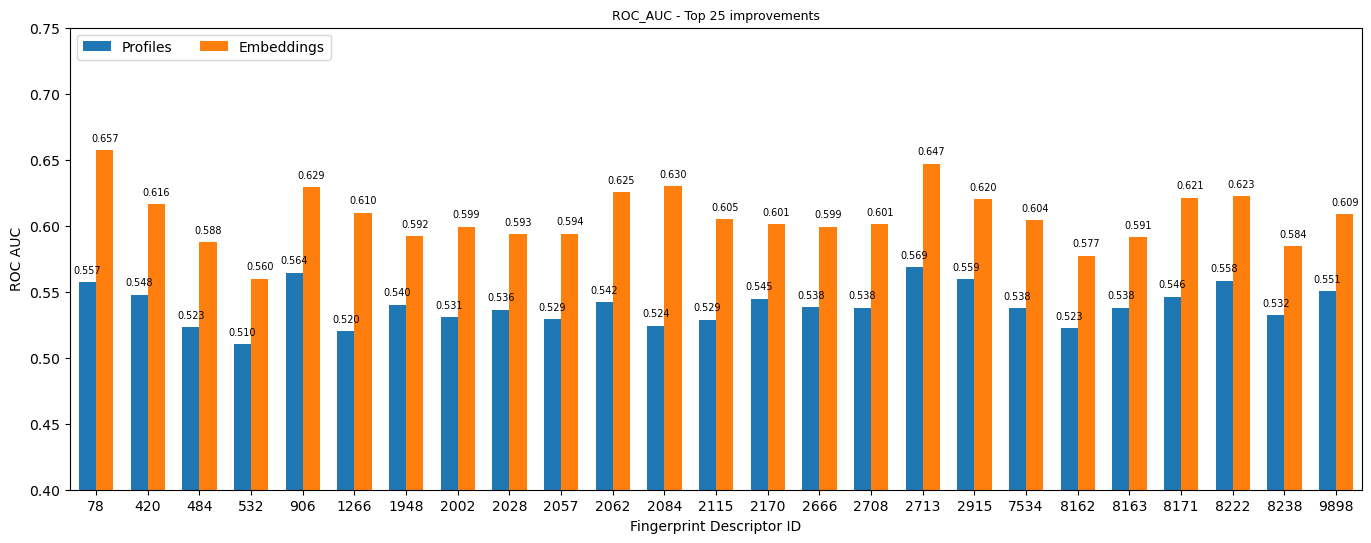

In [96]:
indicies = df_metrics[df_metrics.ms_diff_pct_grp.between(9.0, 25, 'right')].index
len(indicies)
metrics_bar_chart(df_metrics, indicies, column = 'mean_test_score', title = 'Top 25 improvements')

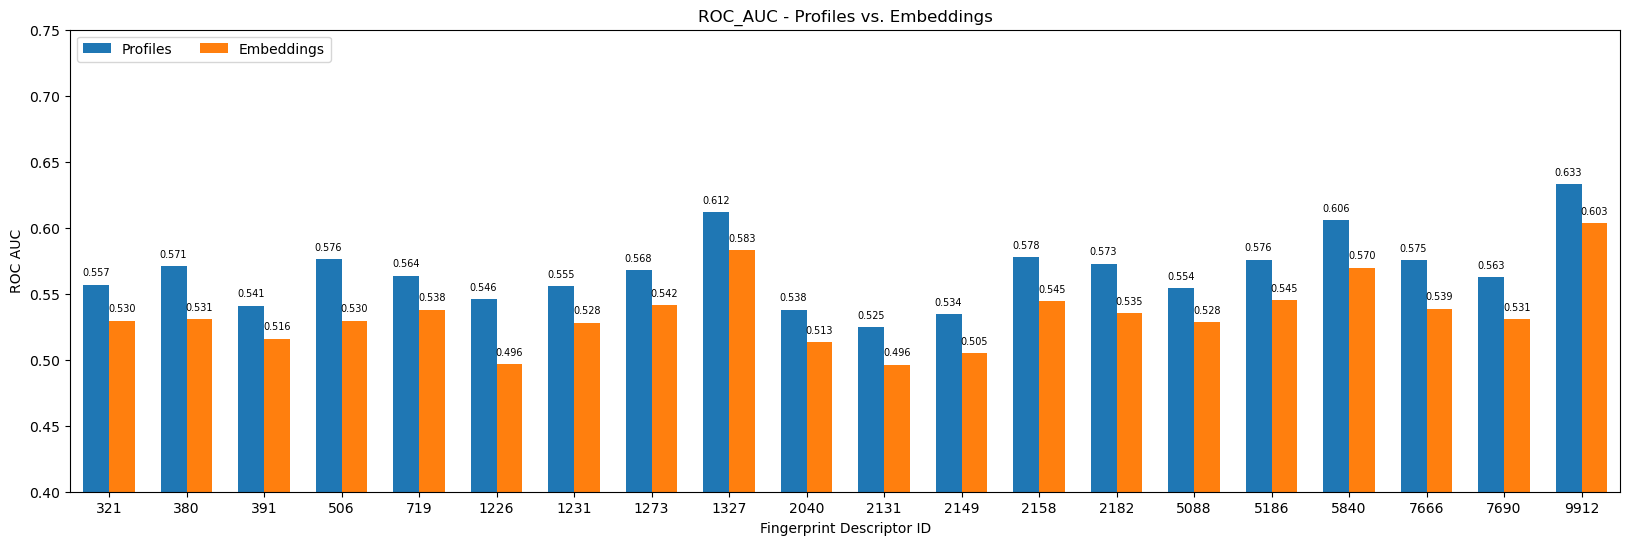

In [68]:
indicies = df_metrics[df_metrics.ms_diff_pct_grp.between(-25, -5, 'right')].index
metrics_bar_chart(df_metrics, indicies, column = 'mean_test_score')

## Comparative Bar charts - 2

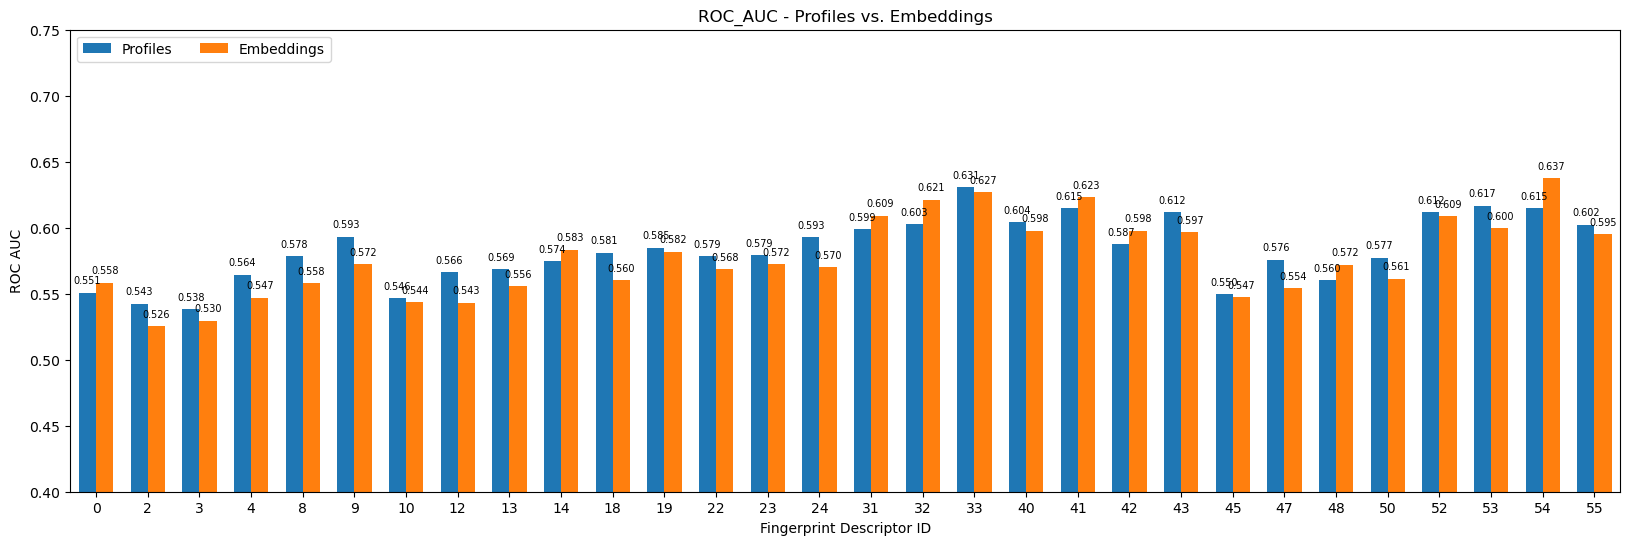

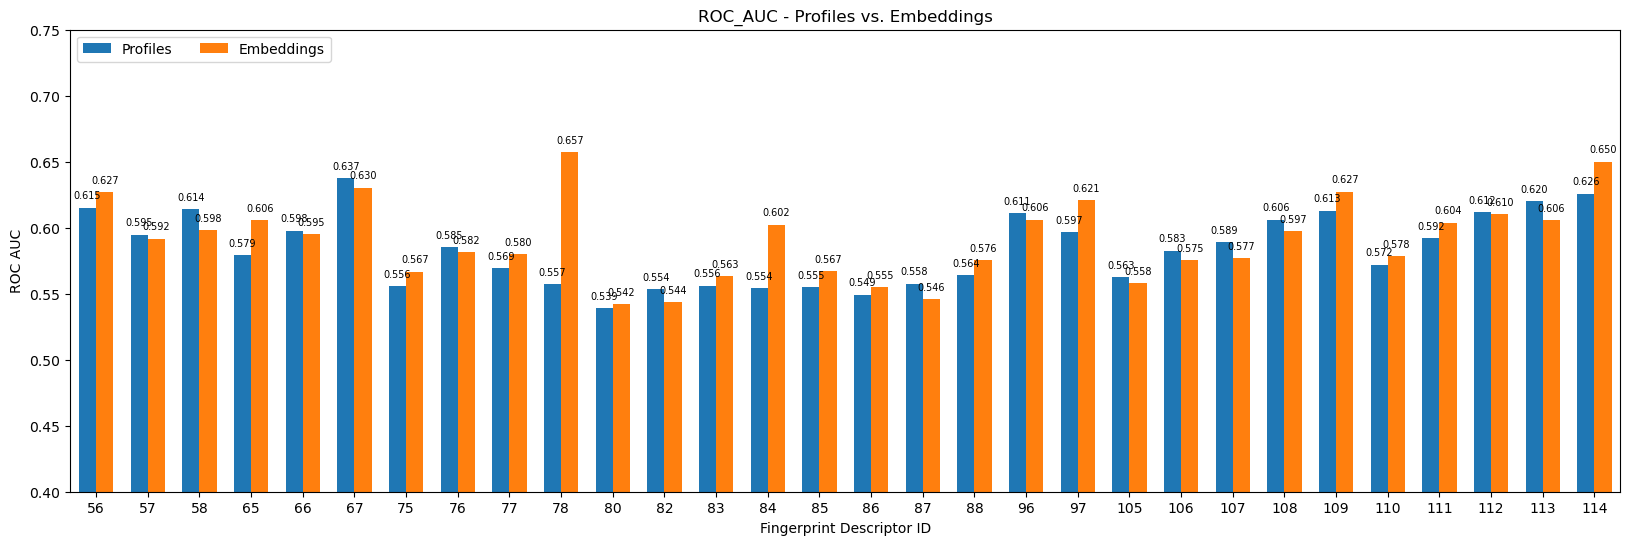

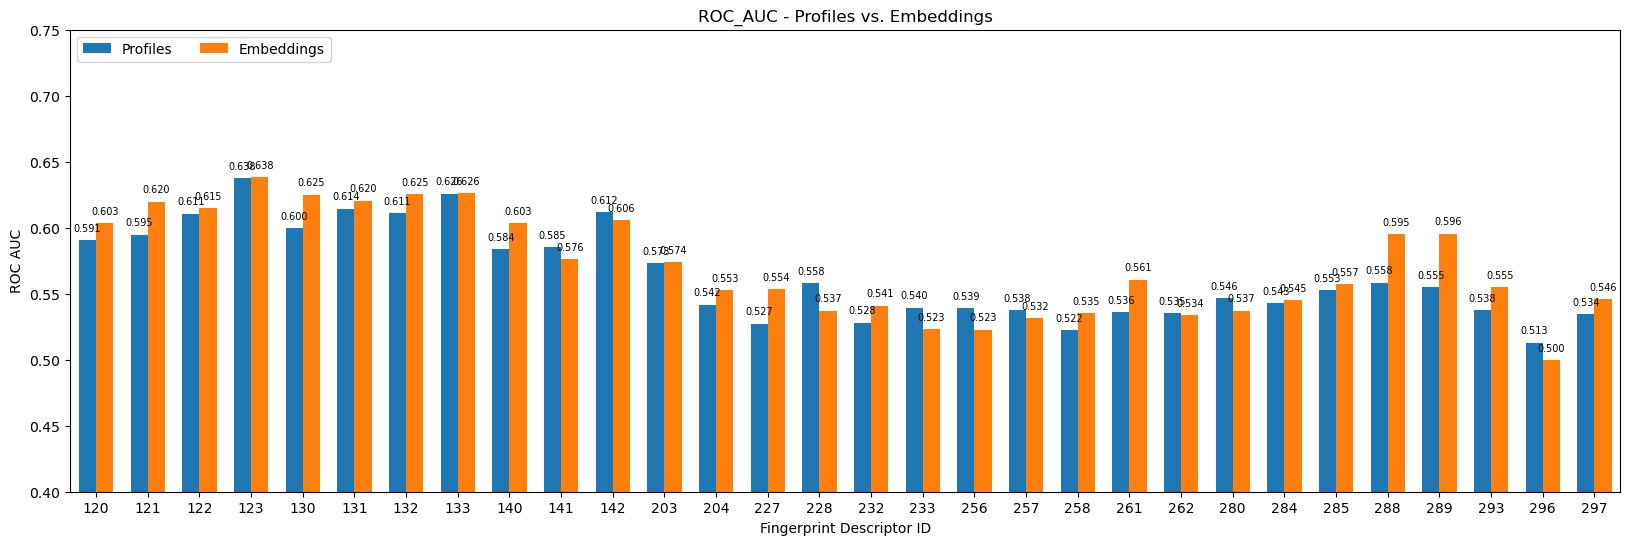

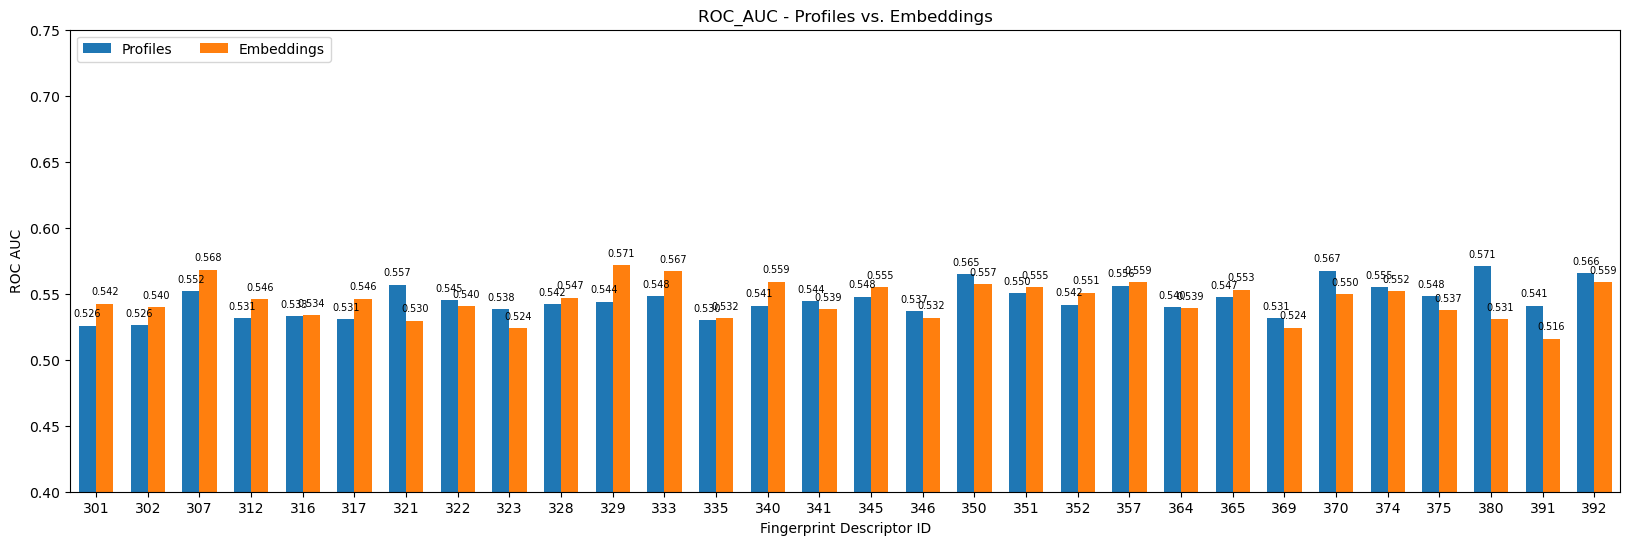

In [66]:
comparative_bar_chart(profile_metrics, embedded_metrics, start=  0, end =30, column = 'mean_test_score')
comparative_bar_chart(profile_metrics, embedded_metrics, start= 30, end =60, column = 'mean_test_score')
comparative_bar_chart(profile_metrics, embedded_metrics, start= 60, end =90, column = 'mean_test_score')
comparative_bar_chart(profile_metrics, embedded_metrics, start= 90, end =120, column = 'mean_test_score')
# comparative_bar_chart(profile_best_metrics, embedded_best_metrics, start= 0, end  =10, column = 'mean_test_score')

## Comparative Bar charts - 3 , Chart Per Group

In [72]:
df_metrics.loc[8]

index_p                                     8
Y_bit                                      13
Y_bit_pct                            0.329307
Y_bit_pct_grp                             3.0
mean_test_score_p                    0.568534
mean_test_score_e                    0.555777
ms_diff                             -0.012758
ms_diff_grp                              -1.0
ms_diff_pct                              -2.2
ms_diff_pct_grp                          -2.0
ms_diff_norm                        -0.133018
fp_groups                      Acceptor Donor
Y_bit_description    Acceptor Donor |0 3|3 0|
precision_p                          0.579646
accuracy_p                           0.683333
recall_p                             0.032538
f1_p                                 0.061618
precision_e                          0.619048
accuracy_e                           0.682857
recall_e                             0.019374
f1_e                                 0.037572
Name: 8, dtype: object

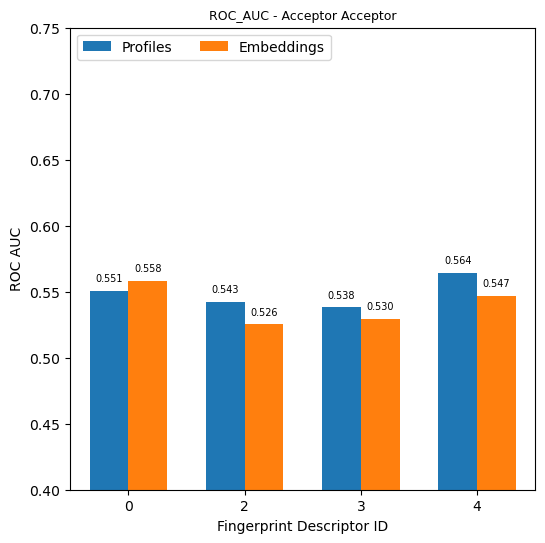

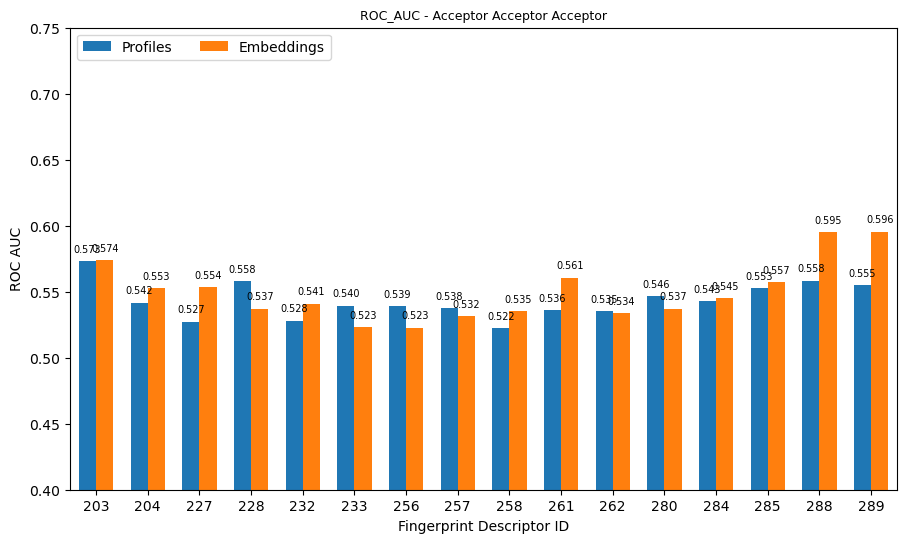

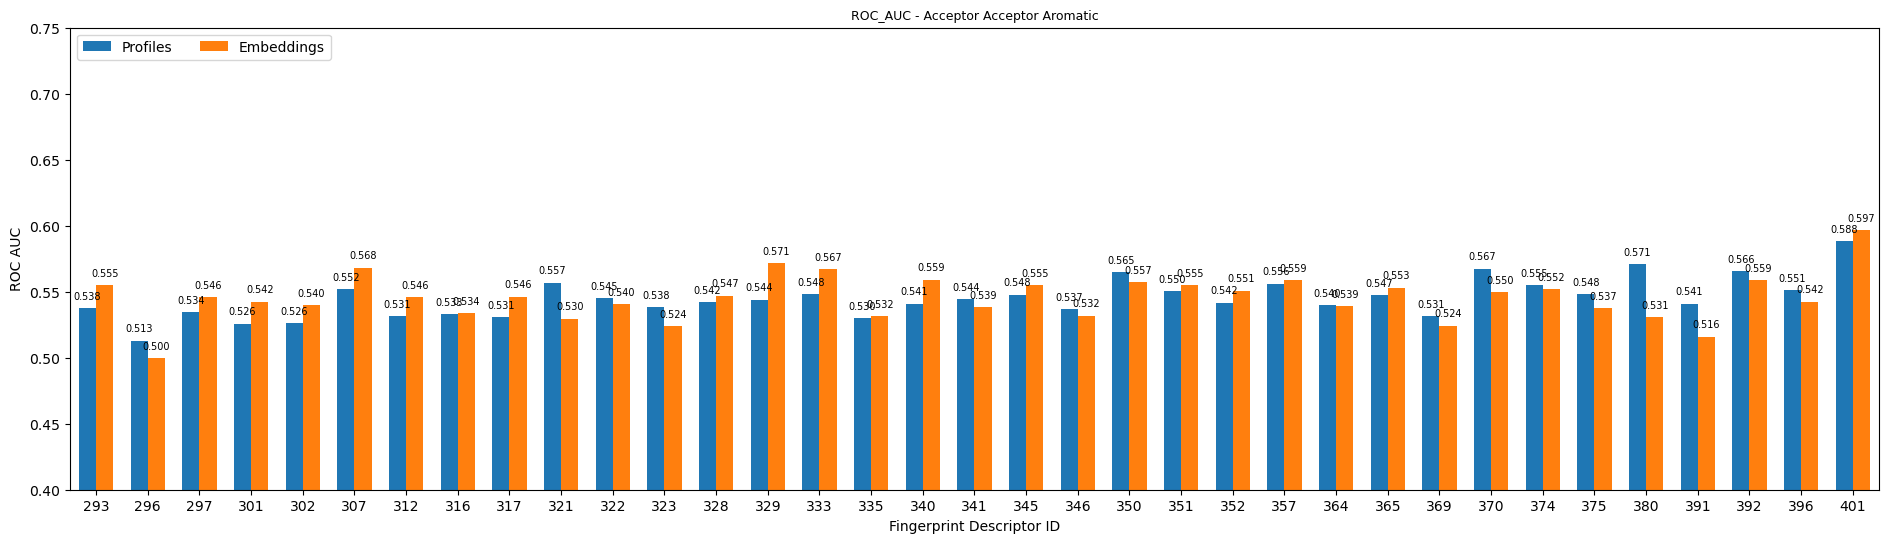

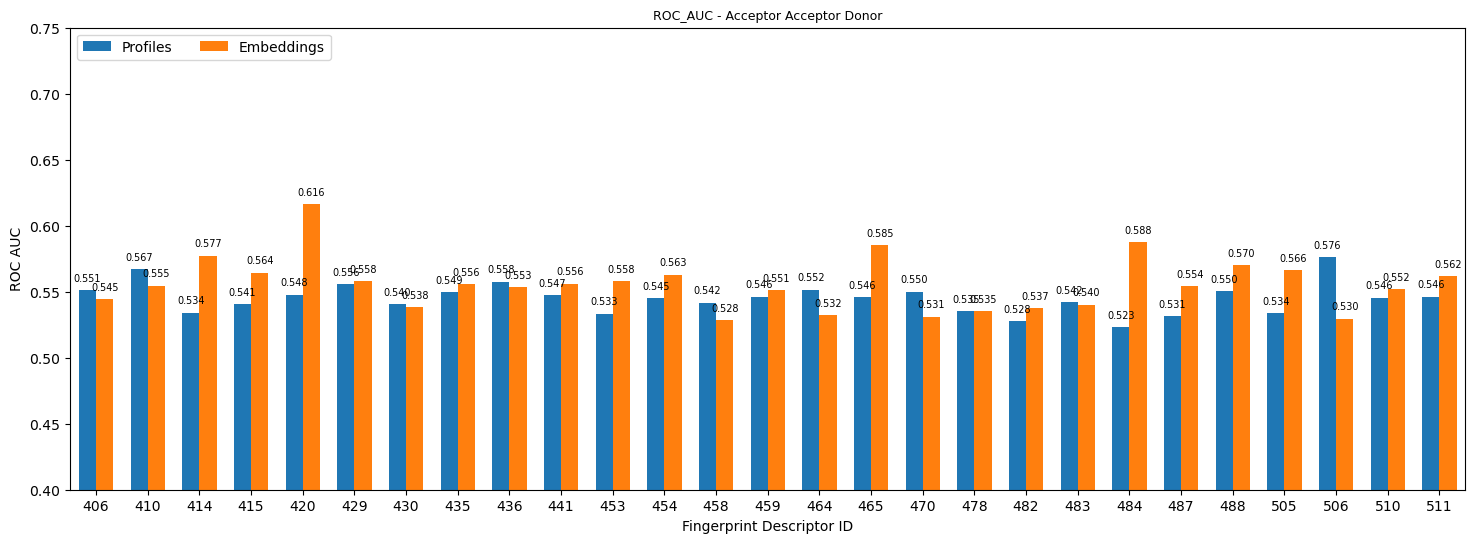

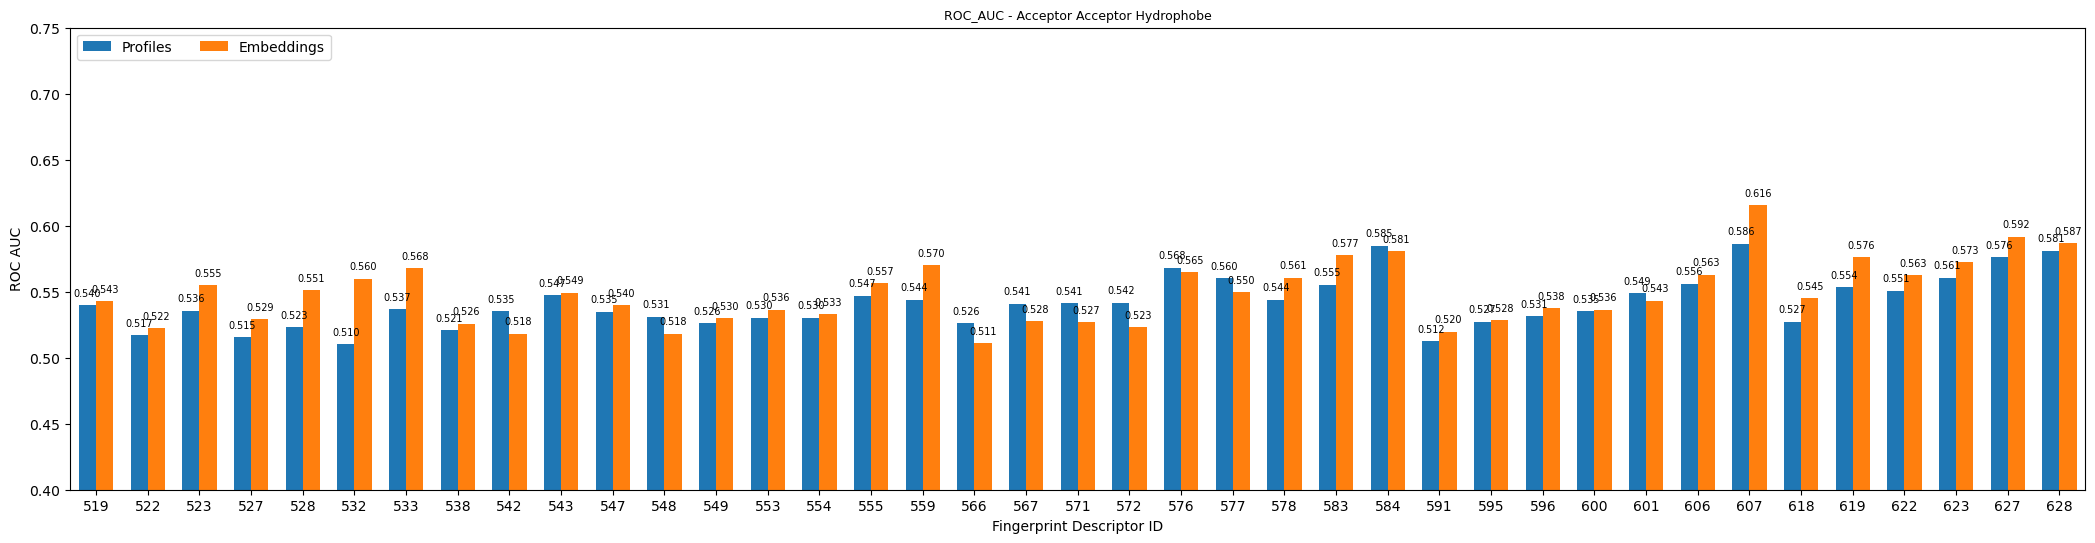

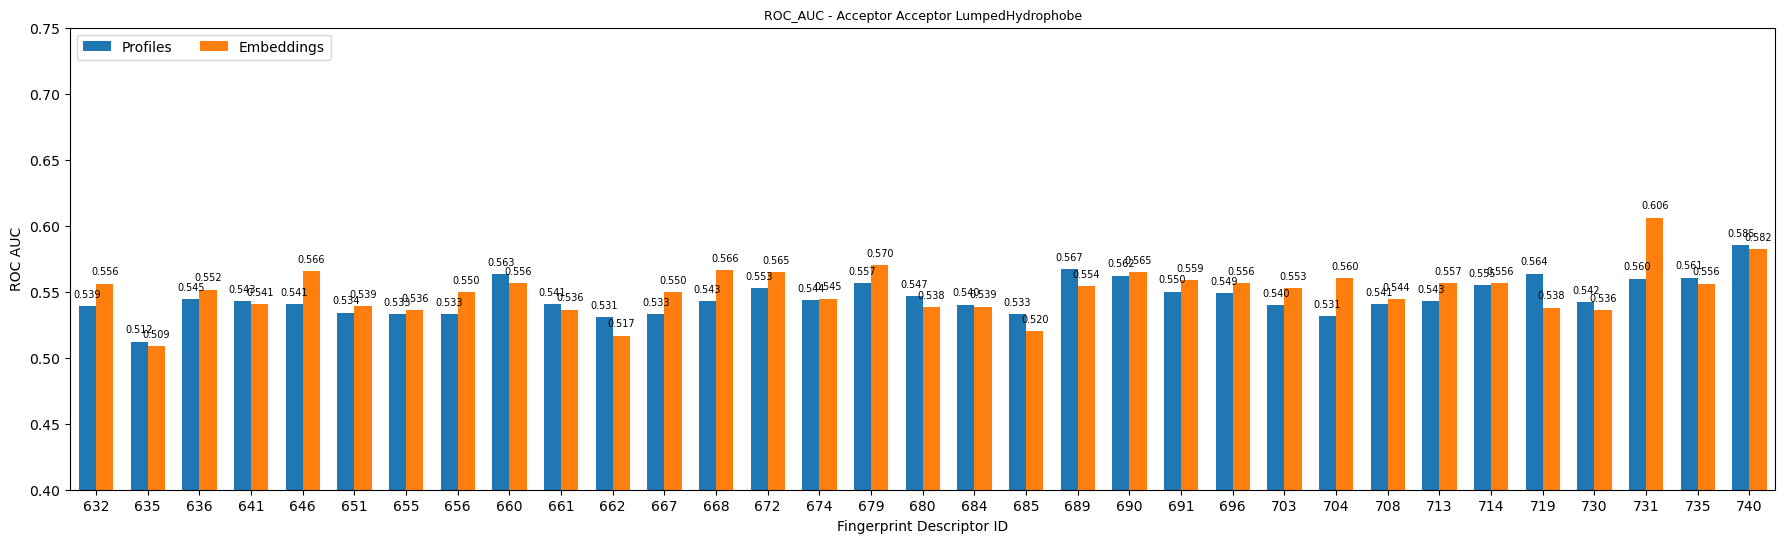

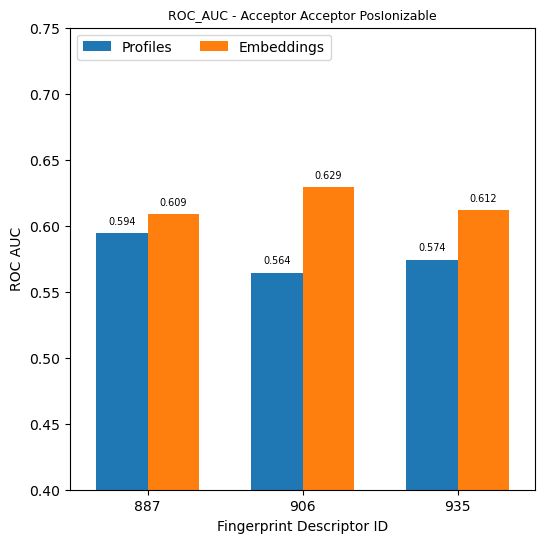

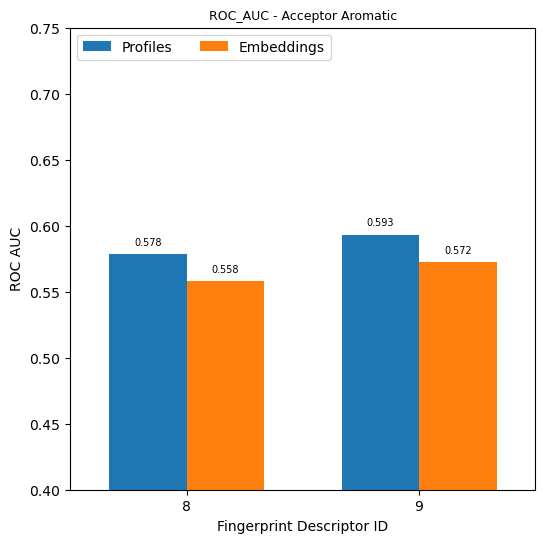

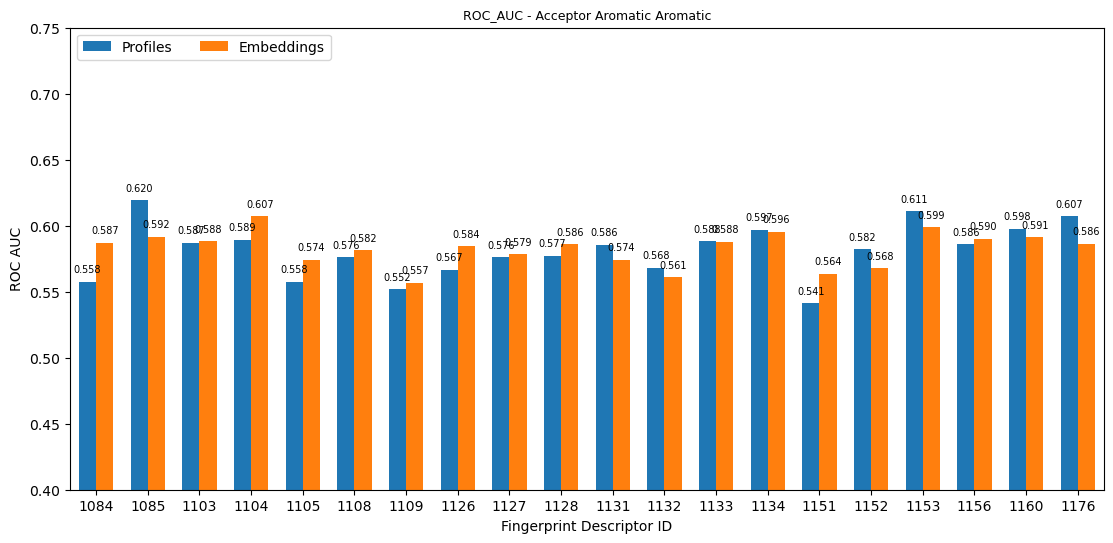

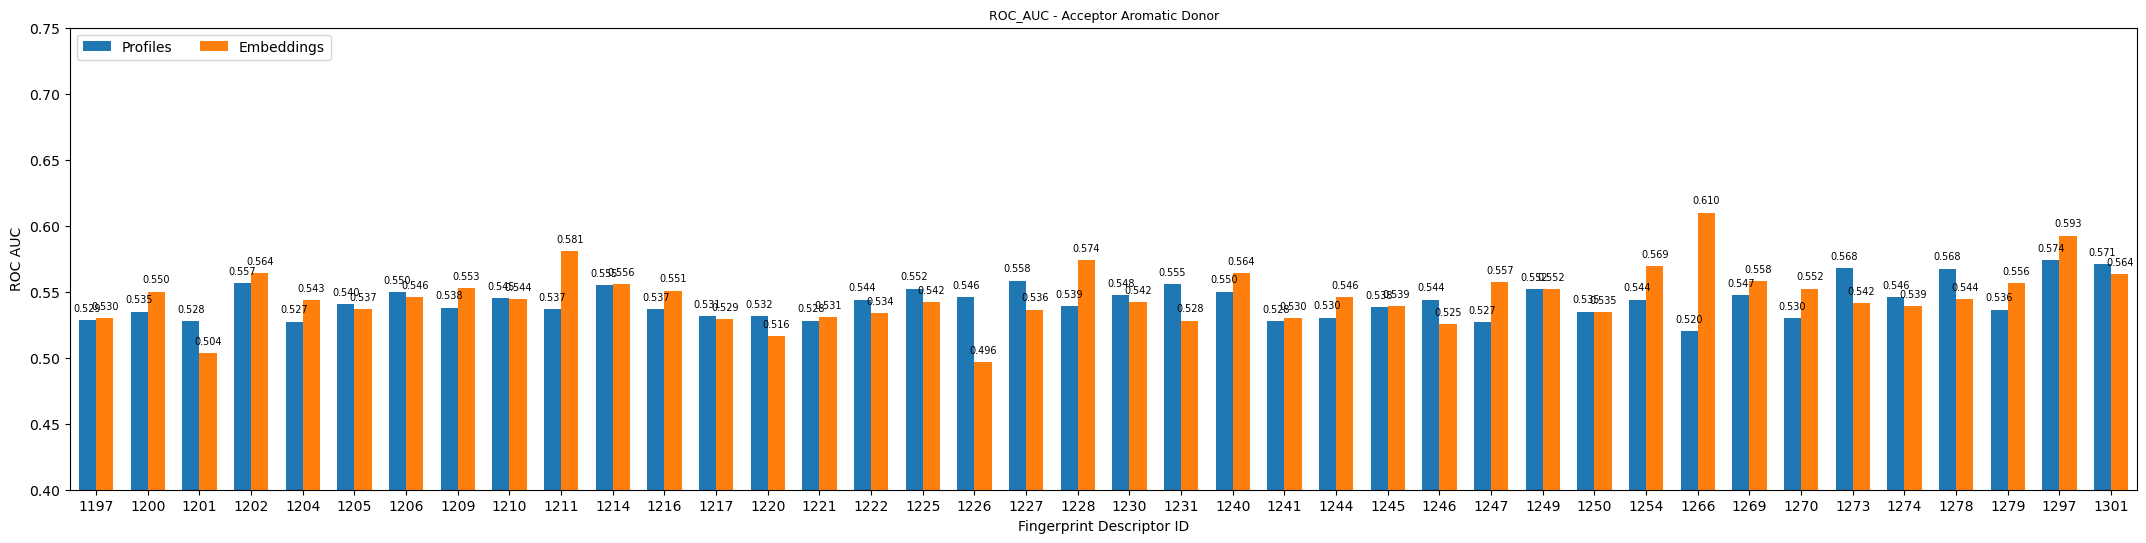

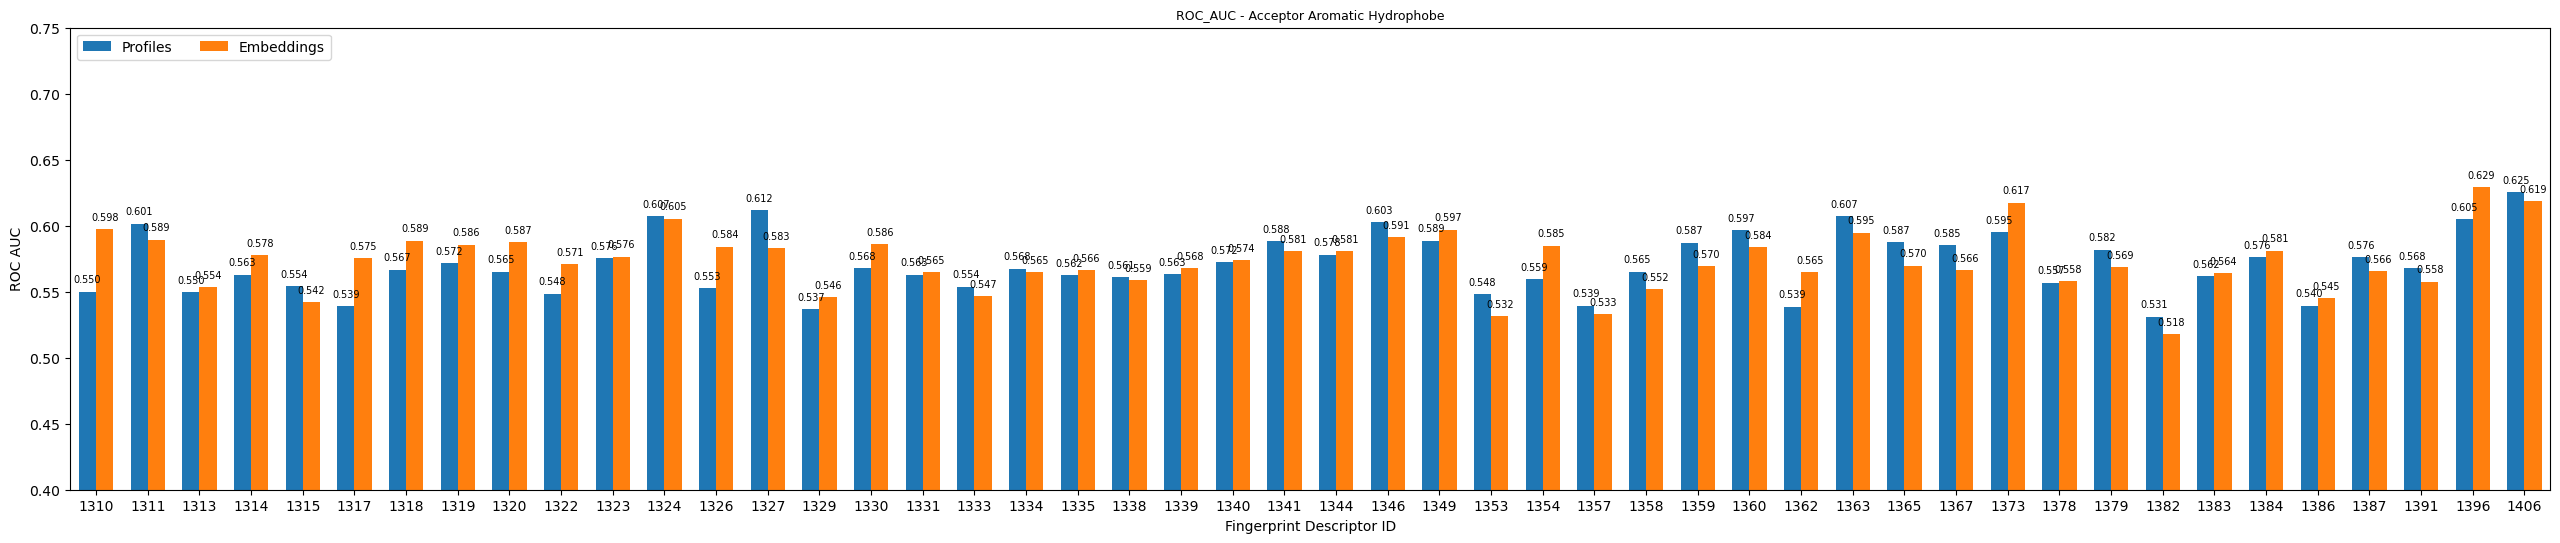

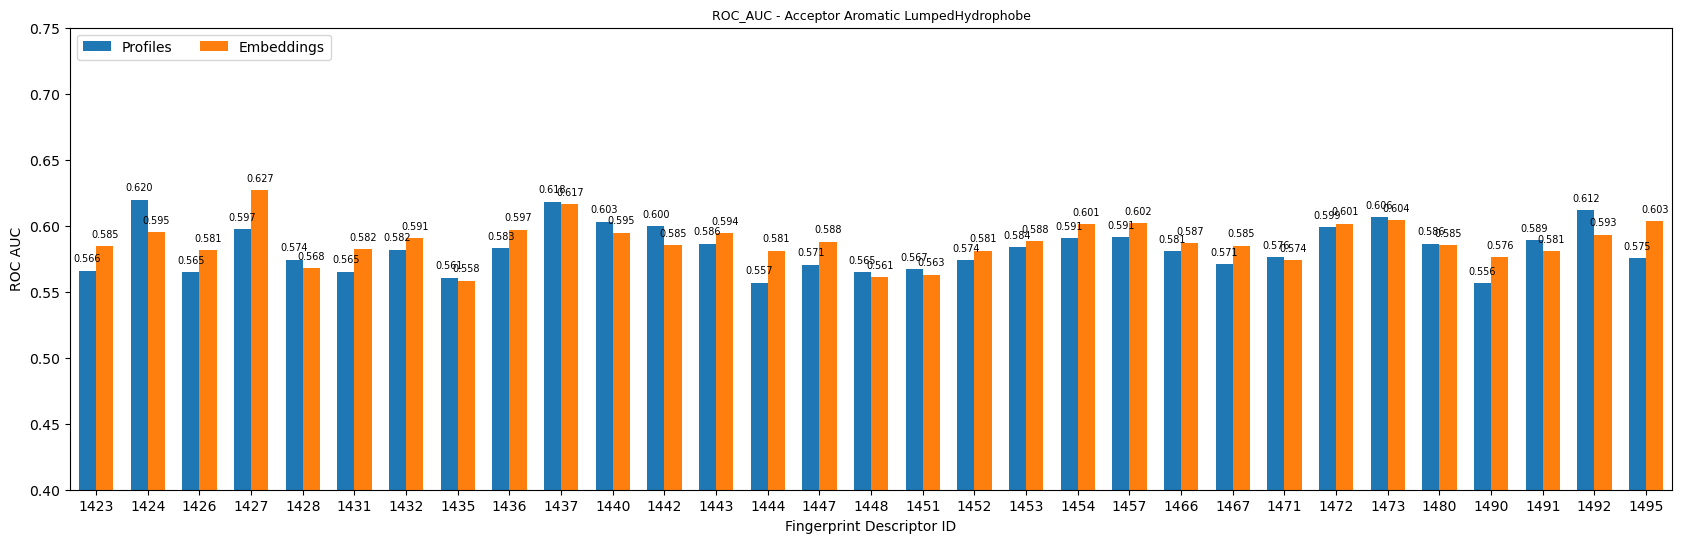

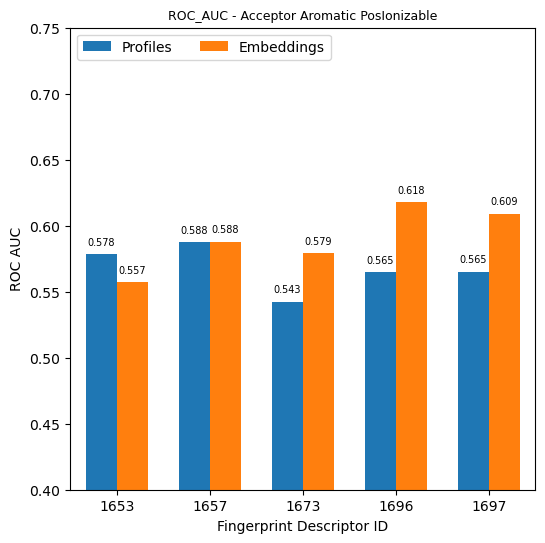

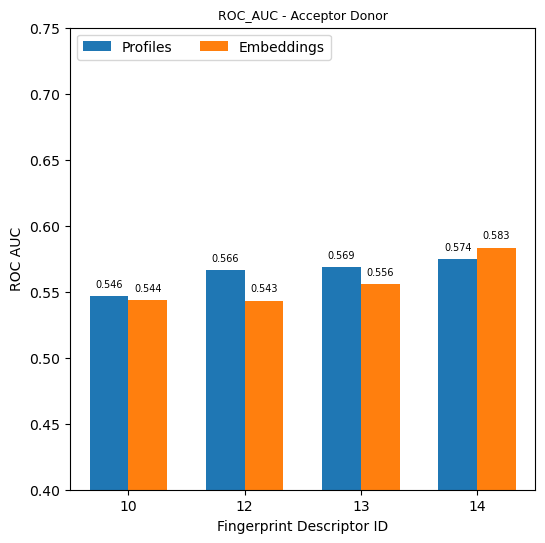

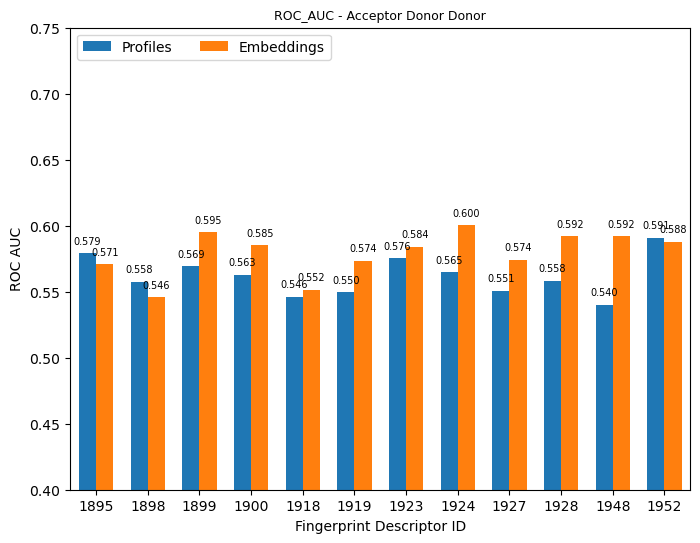

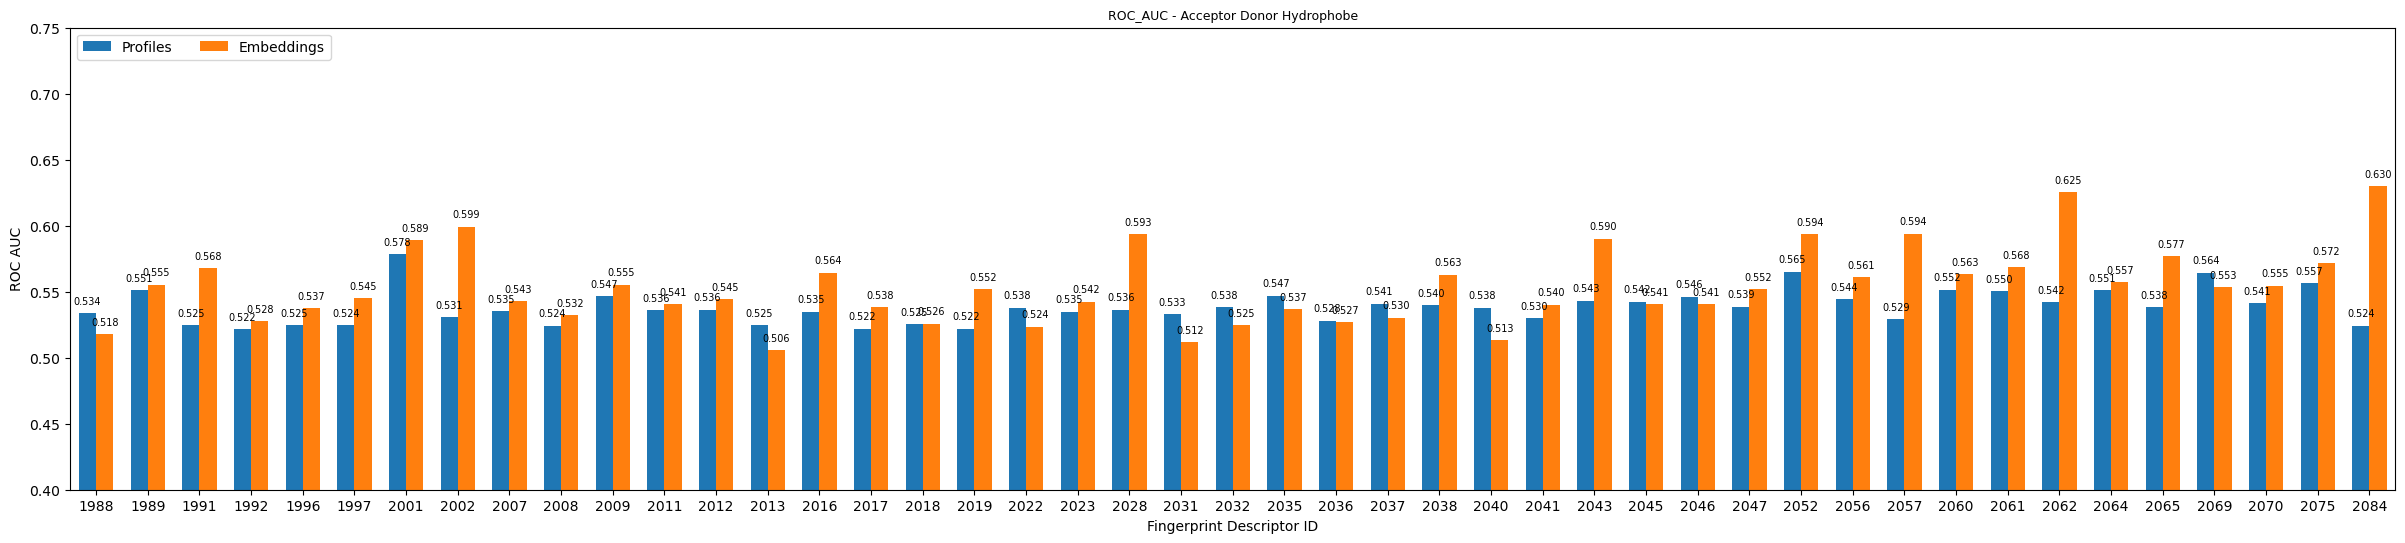

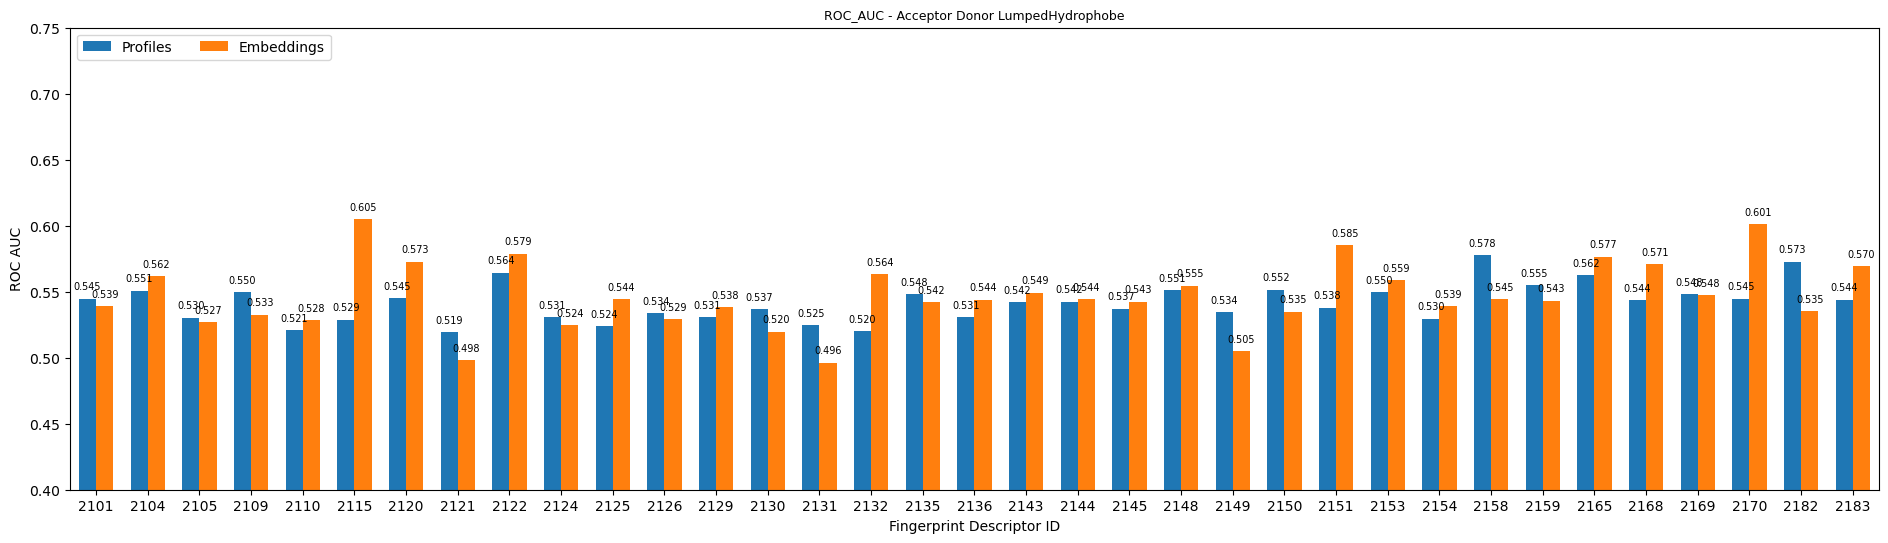

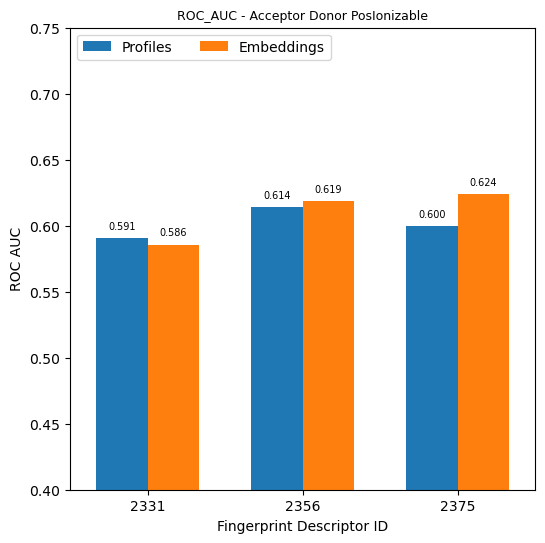

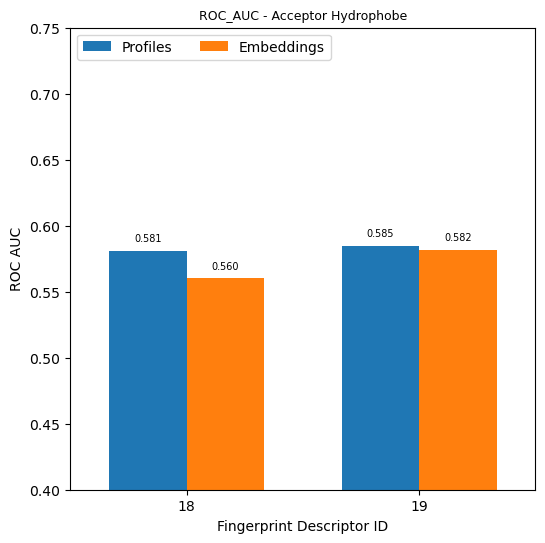

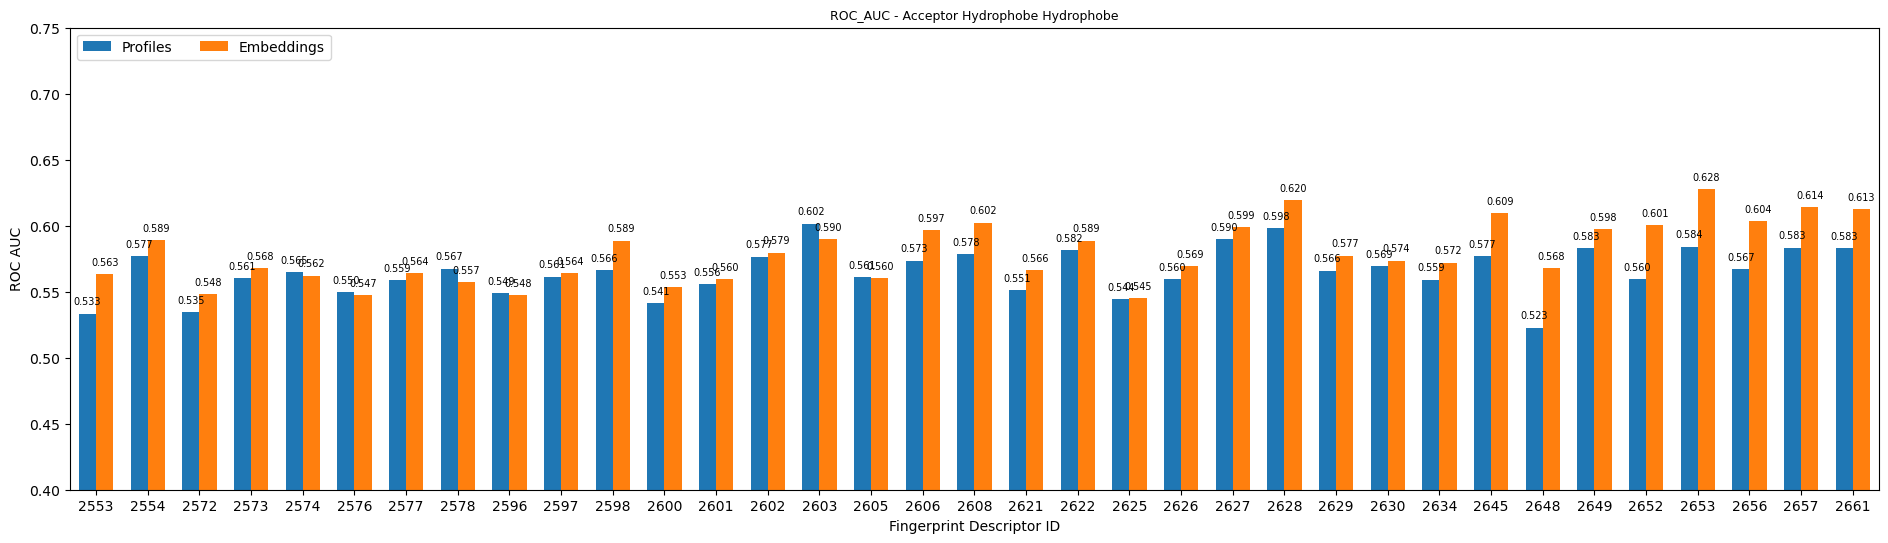

In [81]:
for fp_grp in FP_GROUPS[:20]:
    group_indices = grouped_data_indicies[fp_grp]
    # print(fp_grp, group_indices)
    metrics_bar_chart(df_metrics, group_indices, column = 'mean_test_score', title = fp_grp)

In [82]:
for fp_grp in list(fp_group_indices.keys())[16:]:
    group_indices = grouped_data_indicies[fp_grp]
    metrics_bar_chart(df_metrics, group_indices[fp_grp], column = 'mean_test_score', title = fp_grp)

NameError: name 'fp_group_indices' is not defined

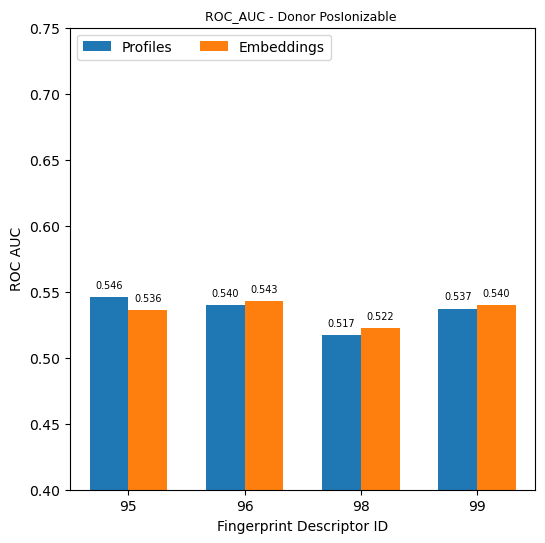

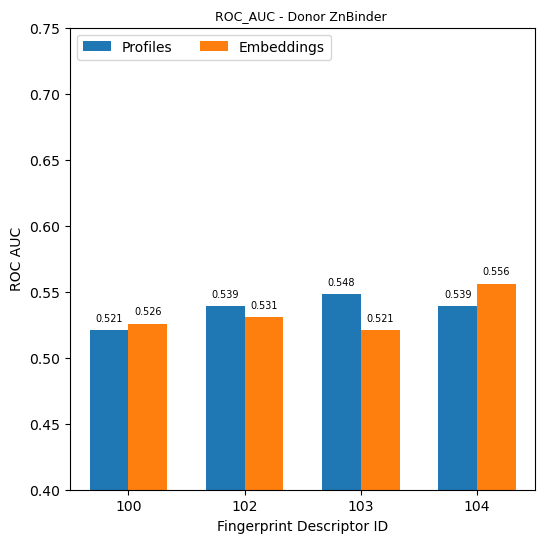

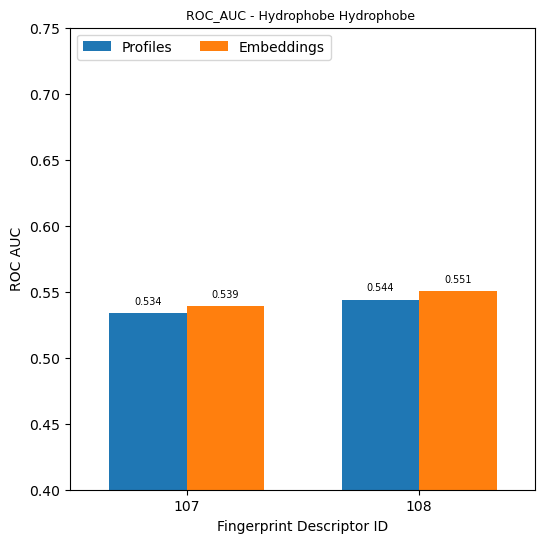

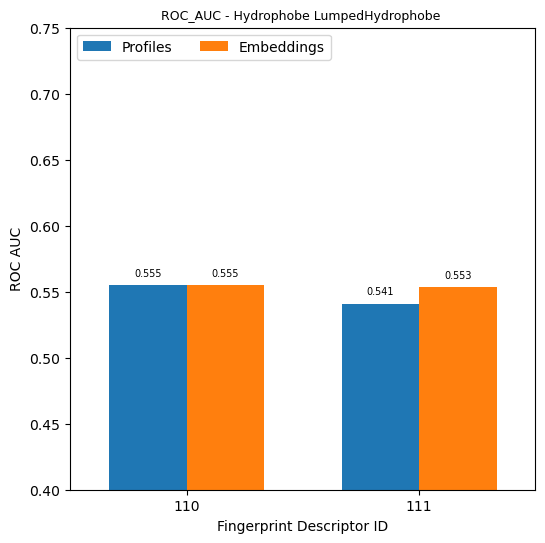

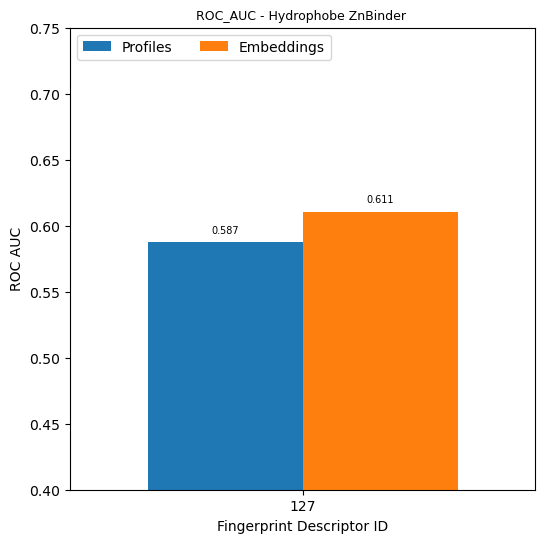

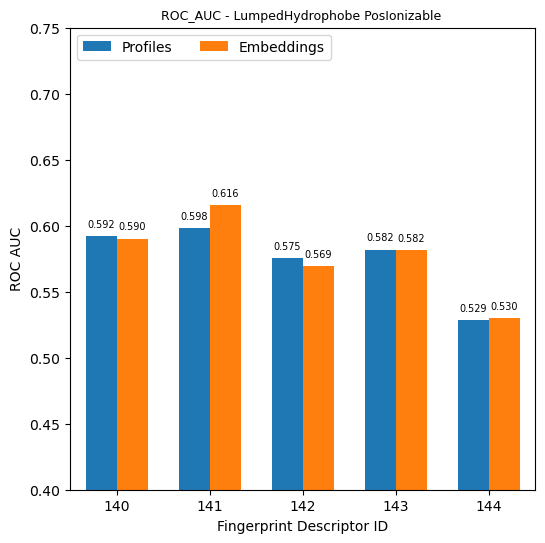

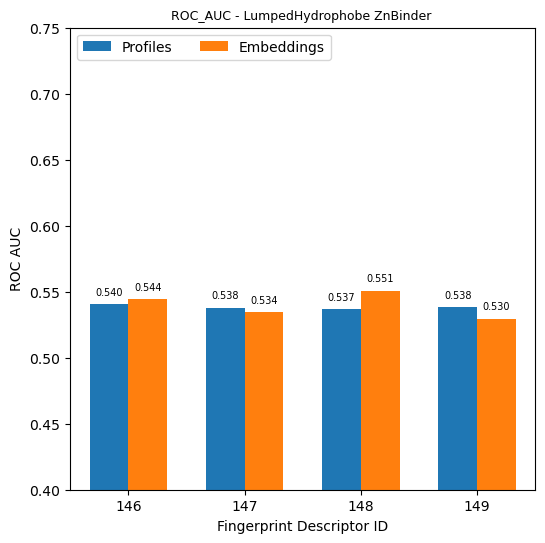

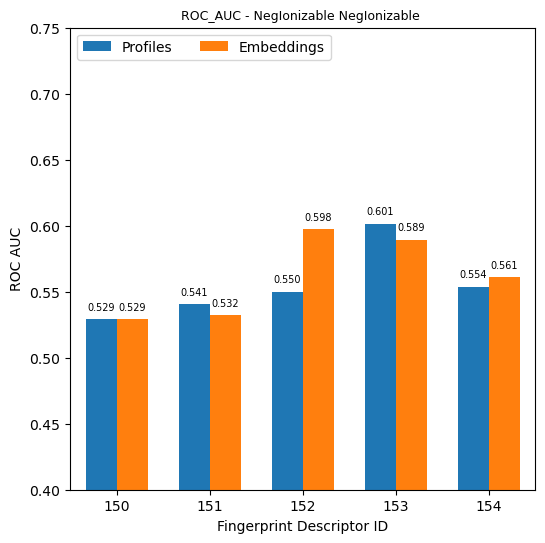

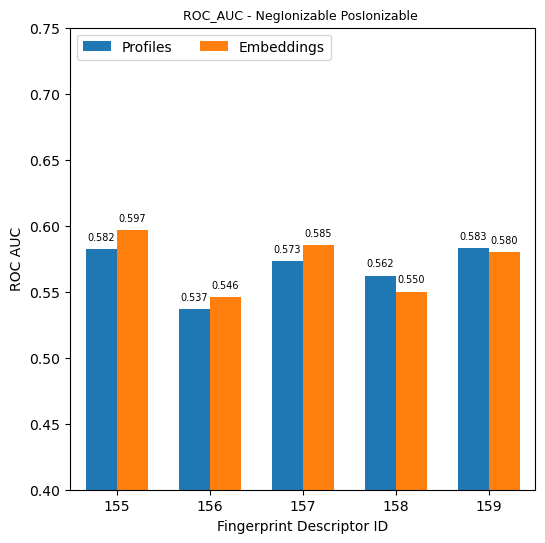

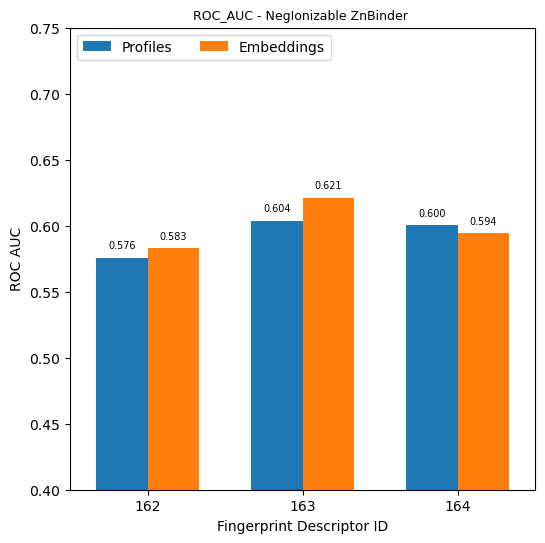

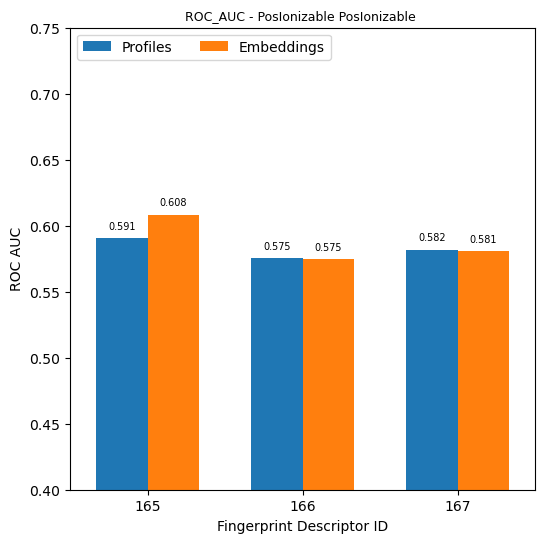

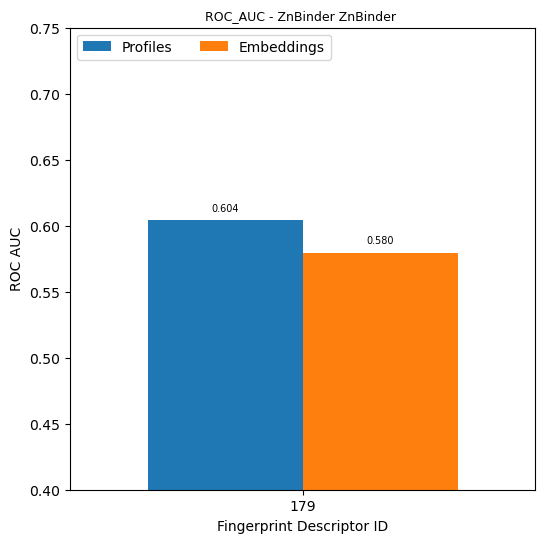

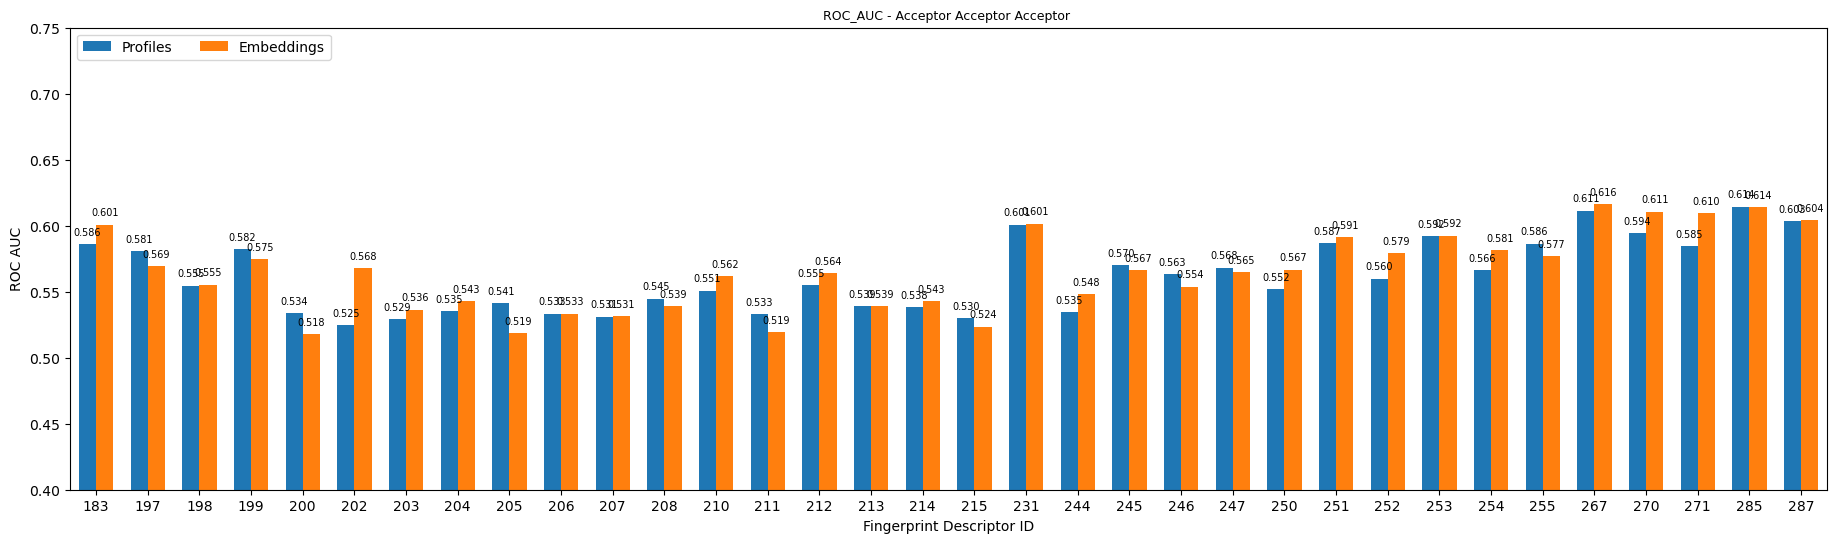

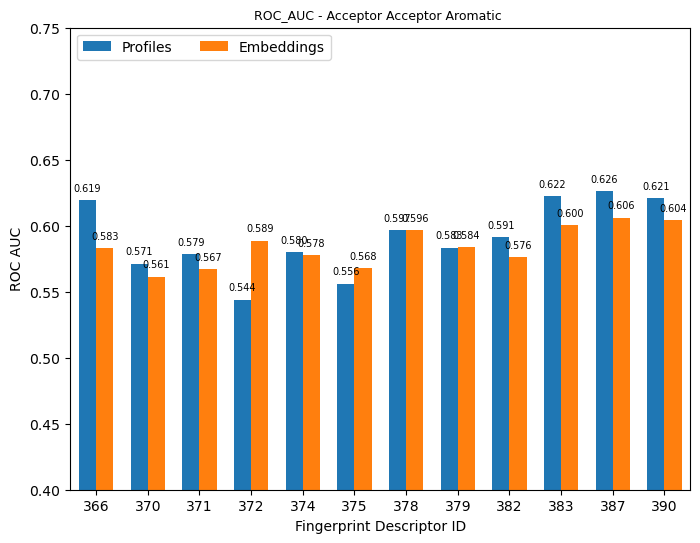

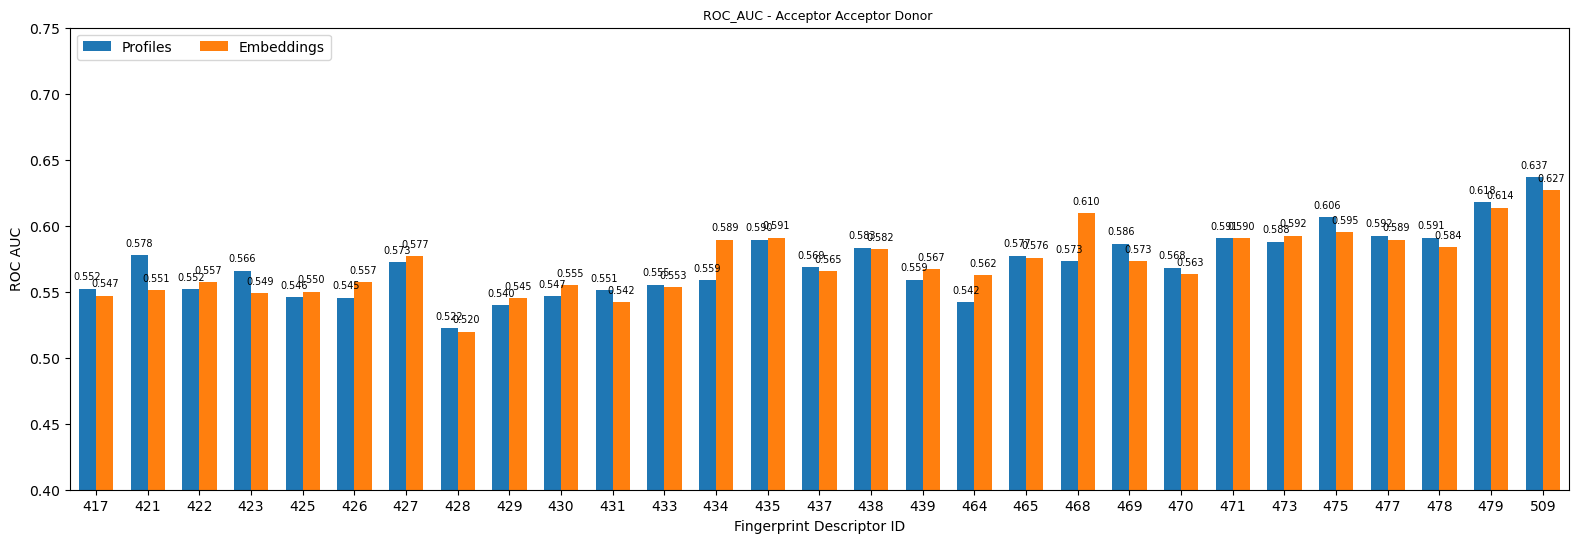

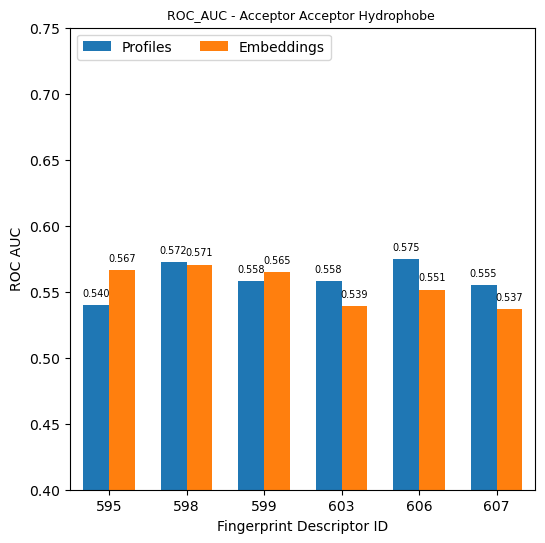

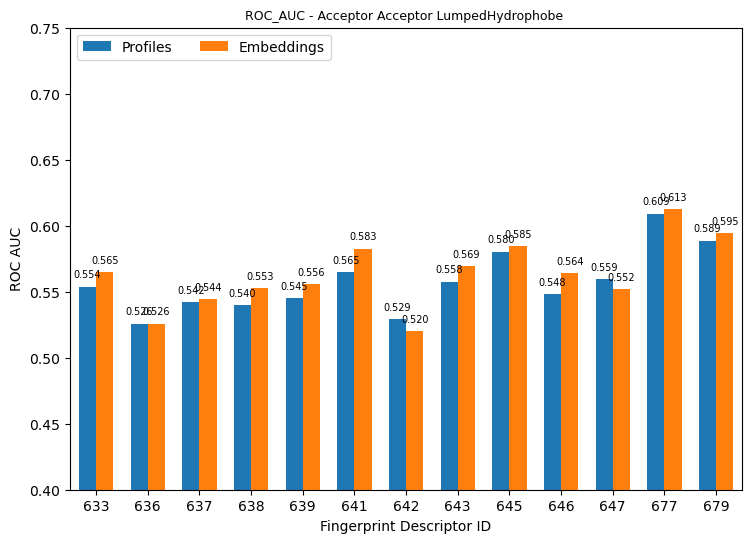

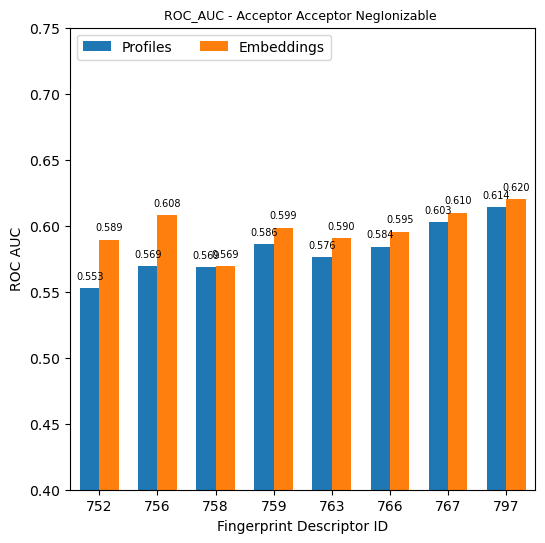

In [160]:
for fp_grp in list(fp_group_indices.keys())[16:]:
    metrics_bar_chart(df_metrics, fp_group_indices[fp_grp], column = 'mean_test_score', title = fp_grp)

## FP Group Box Plots

In [32]:
df1 = pd.DataFrame({'FP_bit':df_metrics.Y_bit, 'FP_Family':df_metrics.fp_groups, 'roc_auc' : df_metrics.mean_test_score_p, 'group': 'profiles'})
df2 = pd.DataFrame({'FP_bit':df_metrics.Y_bit, 'FP_Family':df_metrics.fp_groups, 'roc_auc' : df_metrics.mean_test_score_e, 'group': 'embeddings'})

df1.index
df2.index
df_boxplot = pd.concat([df1,df2])
df_boxplot.sort_values(['FP_bit', 'group'],  inplace = True)
df_boxplot.reset_index(inplace=True)
df_boxplot.info()
df_boxplot


RangeIndex(start=0, stop=803, step=1)

RangeIndex(start=0, stop=803, step=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1606 entries, 0 to 1605
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   index      1606 non-null   int64  
 1   FP_bit     1606 non-null   int64  
 2   FP_Family  1606 non-null   object 
 3   roc_auc    1606 non-null   float64
 4   group      1606 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 62.9+ KB


index  FP_bit                                     FP_Family   roc_auc       group
0         0       0                             Acceptor Acceptor  0.558431  embeddings
1         0       0                             Acceptor Acceptor  0.550693    profiles
2         1       2                             Acceptor Acceptor  0.525606  embeddings
3         1       2                             Acceptor Acceptor  0.542591    profiles
4         2       3                             Acceptor Acceptor  0.529650  embeddings
...     ...     ...                                           ...       ...         ...
1601    800   10127            Hydrophobe Hydrophobe PosIonizable  0.587795    profiles
1602    801   10370  Hydrophobe LumpedHydrophobe LumpedHydrophobe  0.601119  embeddings
1603    801   10370  Hydrophobe LumpedHydrophobe LumpedHydrophobe  0.607160    profiles
1604    802   10375  Hydrophobe LumpedHydrophobe LumpedHydrophobe  0.639403  embeddings
1605    802   10375  Hydrophobe LumpedHydrophobe LumpedHydrophobe  0.623472    profiles

[1606 rows x 5 columns]

In [33]:
sns.__version__
FP_GROUPS_SORTED = sorted(FP_GROUPS)
len(FP_GROUPS_SORTED)

'0.13.0'

60

In [37]:
for idx, grp in enumerate (FP_GROUPS_SORTED):
    print(f"  {idx:4d}  {grp:60s}")

     0  Acceptor Acceptor                                           
     1  Acceptor Acceptor Acceptor                                  
     2  Acceptor Acceptor Aromatic                                  
     3  Acceptor Acceptor Donor                                     
     4  Acceptor Acceptor Hydrophobe                                
     5  Acceptor Acceptor LumpedHydrophobe                          
     6  Acceptor Acceptor PosIonizable                              
     7  Acceptor Aromatic                                           
     8  Acceptor Aromatic Aromatic                                  
     9  Acceptor Aromatic Donor                                     
    10  Acceptor Aromatic Hydrophobe                                
    11  Acceptor Aromatic LumpedHydrophobe                          
    12  Acceptor Aromatic PosIonizable                              
    13  Acceptor Donor                                              
    14  Acceptor Donor Donor      

## Comparative Box Plots - 1 , Chart Per Group

In [84]:
# def plot_boxplots(df_data, indicies, width = 20, height =10, title = ''):
#     # fig_width = max((len(indicies)*5/6) , 10)
#     fig, ax = plt.subplots(1,1, figsize=(width,5))
#     # _ = sns.boxplot(data=df_data.loc[indicies], y="roc_auc", x="FP_Family", width = 0.6, hue = 'group', hue_order =['profiles', 'embeddings'],  ax = ax)
#     _ = sns.boxplot(data = df_data.loc[indicies], y="roc_auc", x="FP_Family", width = 0.6, hue = "group", hue_order =['profiles', 'embeddings'],  ax = ax)
#     _ = ax.set_title(f'ROC distribution by FP group - {title}', size = 9)
#     _ = ax.set_xlabel('')
#     _ = ax.set_xticklabels(ax.get_xticklabels(), fontsize = 8, rotation = 50, ha="right")

In [85]:
indicies_1 = df_boxplot[df_boxplot.FP_Family.isin( FP_GROUPS[:14])].index
indicies_2 = df_boxplot[df_boxplot.FP_Family.isin( FP_GROUPS[14:28])].index
indicies_3 = df_boxplot[df_boxplot.FP_Family.isin( FP_GROUPS[28:42])].index
indicies_4 = df_boxplot[df_boxplot.FP_Family.isin( FP_GROUPS[42:57])].index

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/categorical.p

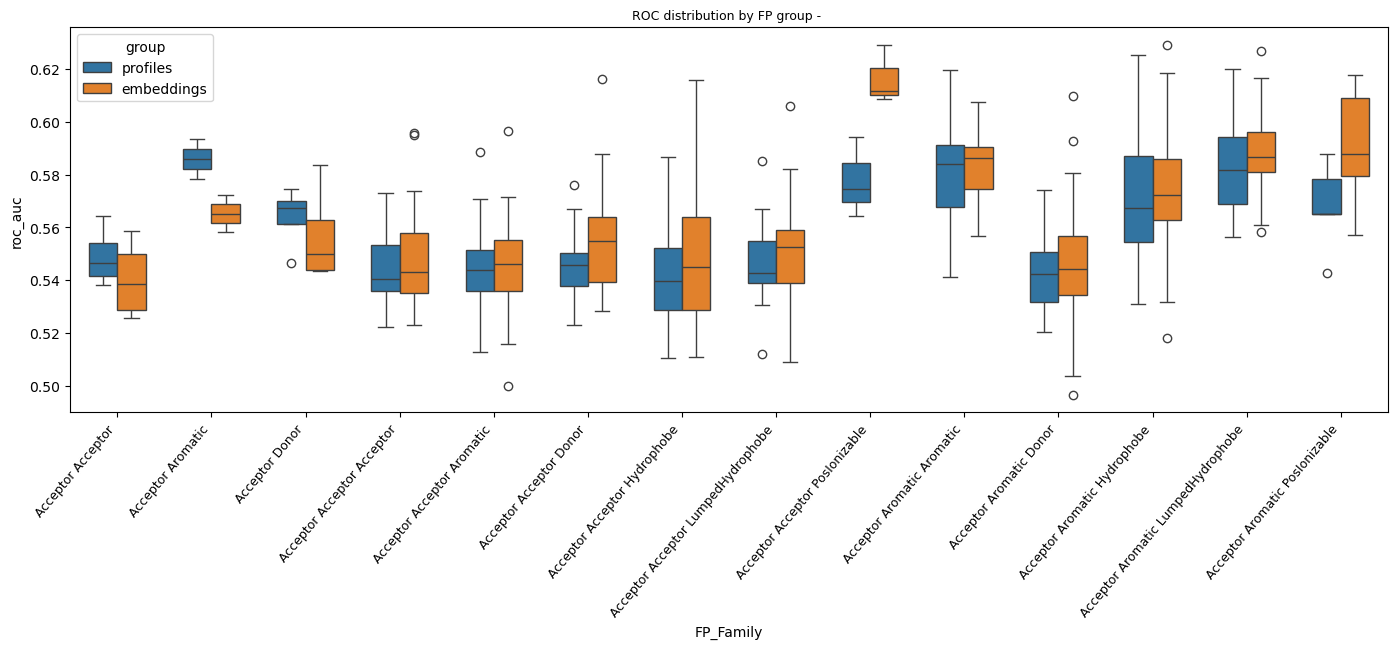

In [86]:
plot_boxplots(df_boxplot, indicies_1)

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/categorical.p

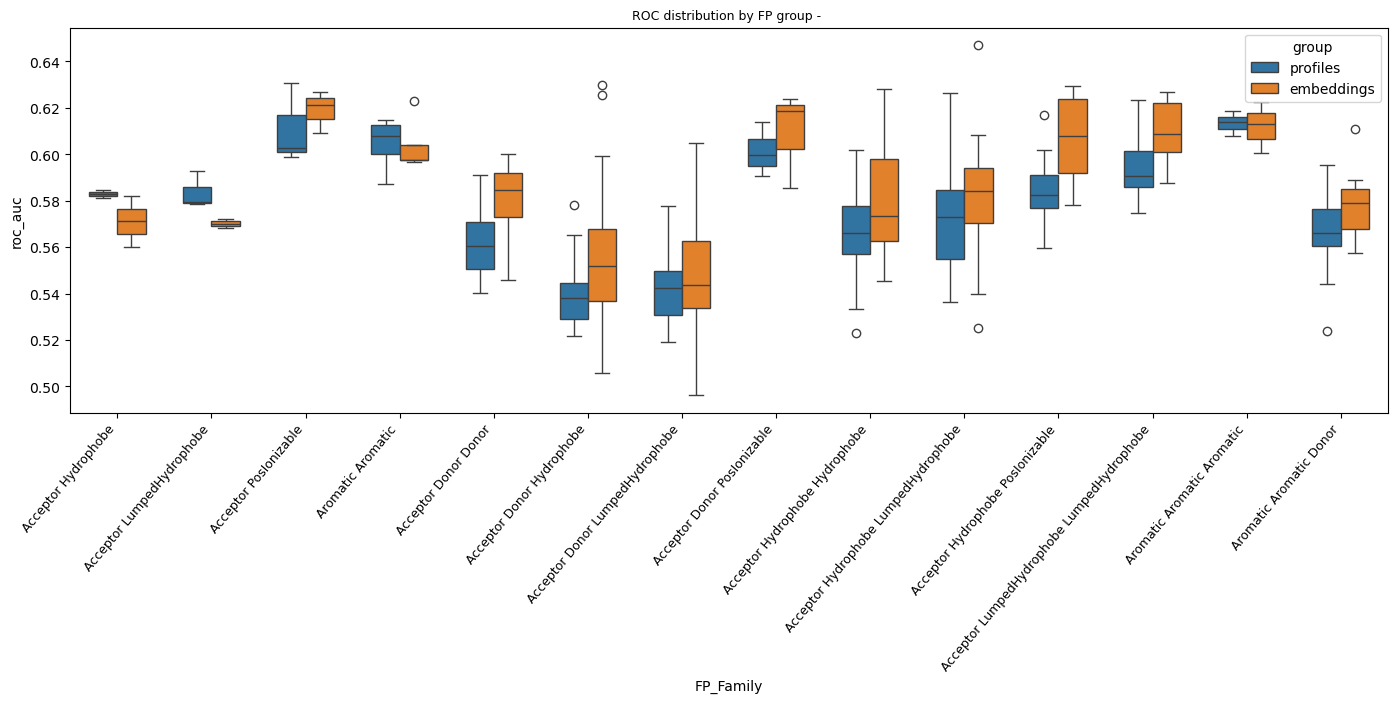

In [87]:
plot_boxplots(df_boxplot, indicies_2)

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/categorical.p

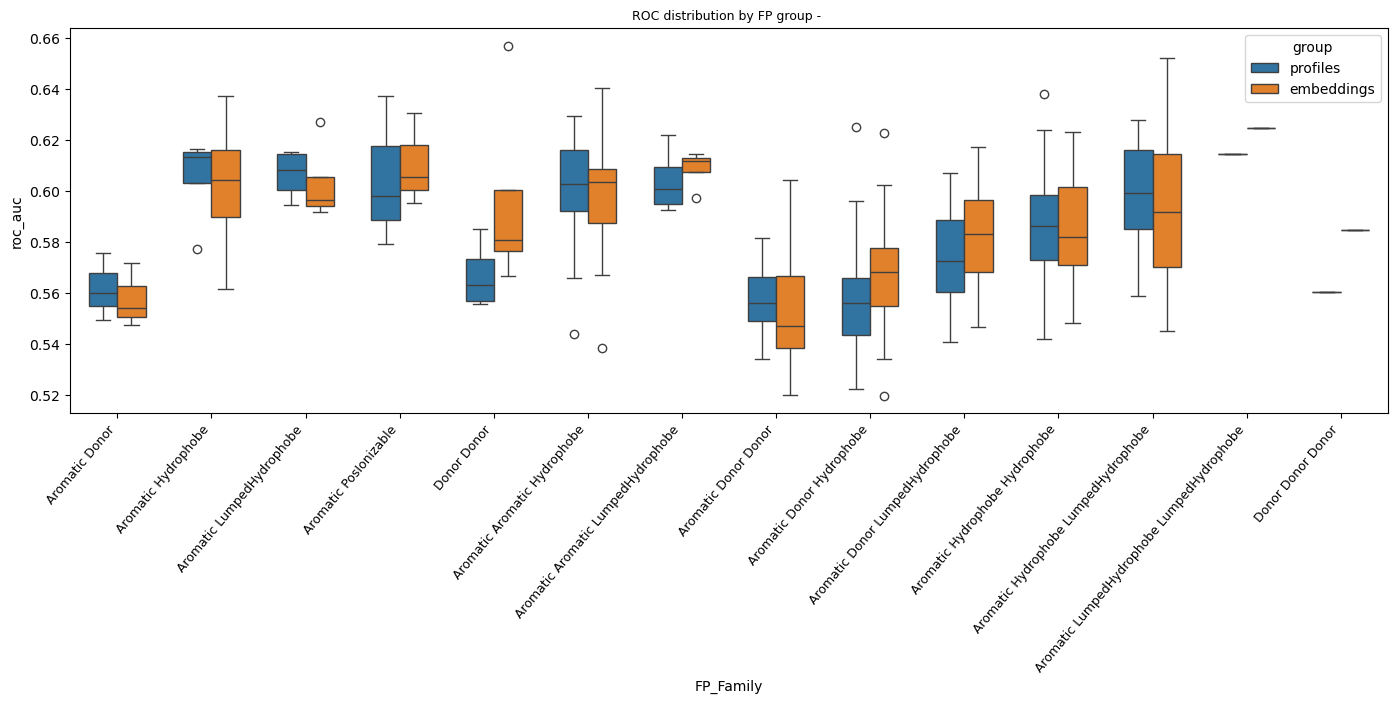

In [88]:
plot_boxplots(df_boxplot, indicies_3)

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/categorical.p

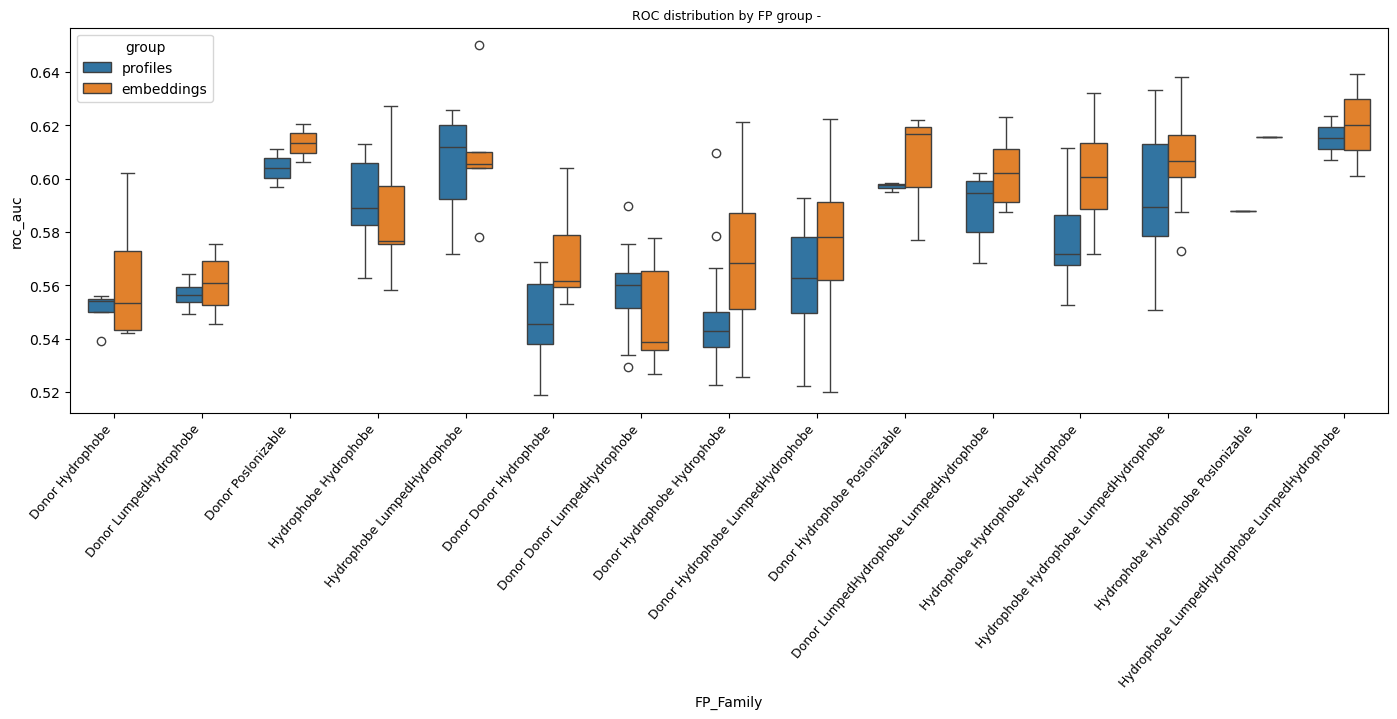

In [89]:
plot_boxplots(df_boxplot, indicies_4)

## Comparative Box Plots - 2 , Chart Per Group

In [51]:
df1 = pd.DataFrame({'FP_bit':df_metrics.Y_bit, 'FP_Family':df_metrics.fp_groups, 'roc_auc' : df_metrics.mean_test_score_p, 'group': 'profiles'})
df2 = pd.DataFrame({'FP_bit':df_metrics.Y_bit, 'FP_Family':df_metrics.fp_groups, 'roc_auc' : df_metrics.mean_test_score_e, 'group': 'embeddings'})

df1.index
df2.index
df_boxplot = pd.concat([df1,df2])
df_boxplot.sort_values(['FP_bit', 'group'],  inplace = True)
df_boxplot.reset_index(inplace=True)
df_boxplot.info()
# df_boxplot


RangeIndex(start=0, stop=803, step=1)

RangeIndex(start=0, stop=803, step=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1606 entries, 0 to 1605
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   index      1606 non-null   int64  
 1   FP_bit     1606 non-null   int64  
 2   FP_Family  1606 non-null   object 
 3   roc_auc    1606 non-null   float64
 4   group      1606 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 62.9+ KB


In [52]:
sns.__version__
FP_GROUPS_SORTED = sorted(FP_GROUPS)
len(FP_GROUPS_SORTED)
FP_GROUPS_SORTED

'0.13.0'

60

['Acceptor Acceptor',
 'Acceptor Acceptor Acceptor',
 'Acceptor Acceptor Aromatic',
 'Acceptor Acceptor Donor',
 'Acceptor Acceptor Hydrophobe',
 'Acceptor Acceptor LumpedHydrophobe',
 'Acceptor Acceptor PosIonizable',
 'Acceptor Aromatic',
 'Acceptor Aromatic Aromatic',
 'Acceptor Aromatic Donor',
 'Acceptor Aromatic Hydrophobe',
 'Acceptor Aromatic LumpedHydrophobe',
 'Acceptor Aromatic PosIonizable',
 'Acceptor Donor',
 'Acceptor Donor Donor',
 'Acceptor Donor Hydrophobe',
 'Acceptor Donor LumpedHydrophobe',
 'Acceptor Donor PosIonizable',
 'Acceptor Hydrophobe',
 'Acceptor Hydrophobe Hydrophobe',
 'Acceptor Hydrophobe LumpedHydrophobe',
 'Acceptor Hydrophobe PosIonizable',
 'Acceptor LumpedHydrophobe',
 'Acceptor LumpedHydrophobe LumpedHydrophobe',
 'Acceptor PosIonizable',
 'Aromatic Aromatic',
 'Aromatic Aromatic Aromatic',
 'Aromatic Aromatic Donor',
 'Aromatic Aromatic Hydrophobe',
 'Aromatic Aromatic LumpedHydrophobe',
 'Aromatic Donor',
 'Aromatic Donor Donor',
 'Aromatic Don

In [53]:
indicies_1 = df_boxplot[df_boxplot.FP_Family.isin( FP_GROUPS_SORTED[:15])].index
indicies_2 = df_boxplot[df_boxplot.FP_Family.isin( FP_GROUPS_SORTED[15:30])].index
indicies_3 = df_boxplot[df_boxplot.FP_Family.isin( FP_GROUPS_SORTED[30:45])].index
indicies_4 = df_boxplot[df_boxplot.FP_Family.isin( FP_GROUPS_SORTED[45:60])].index

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/categorical.p

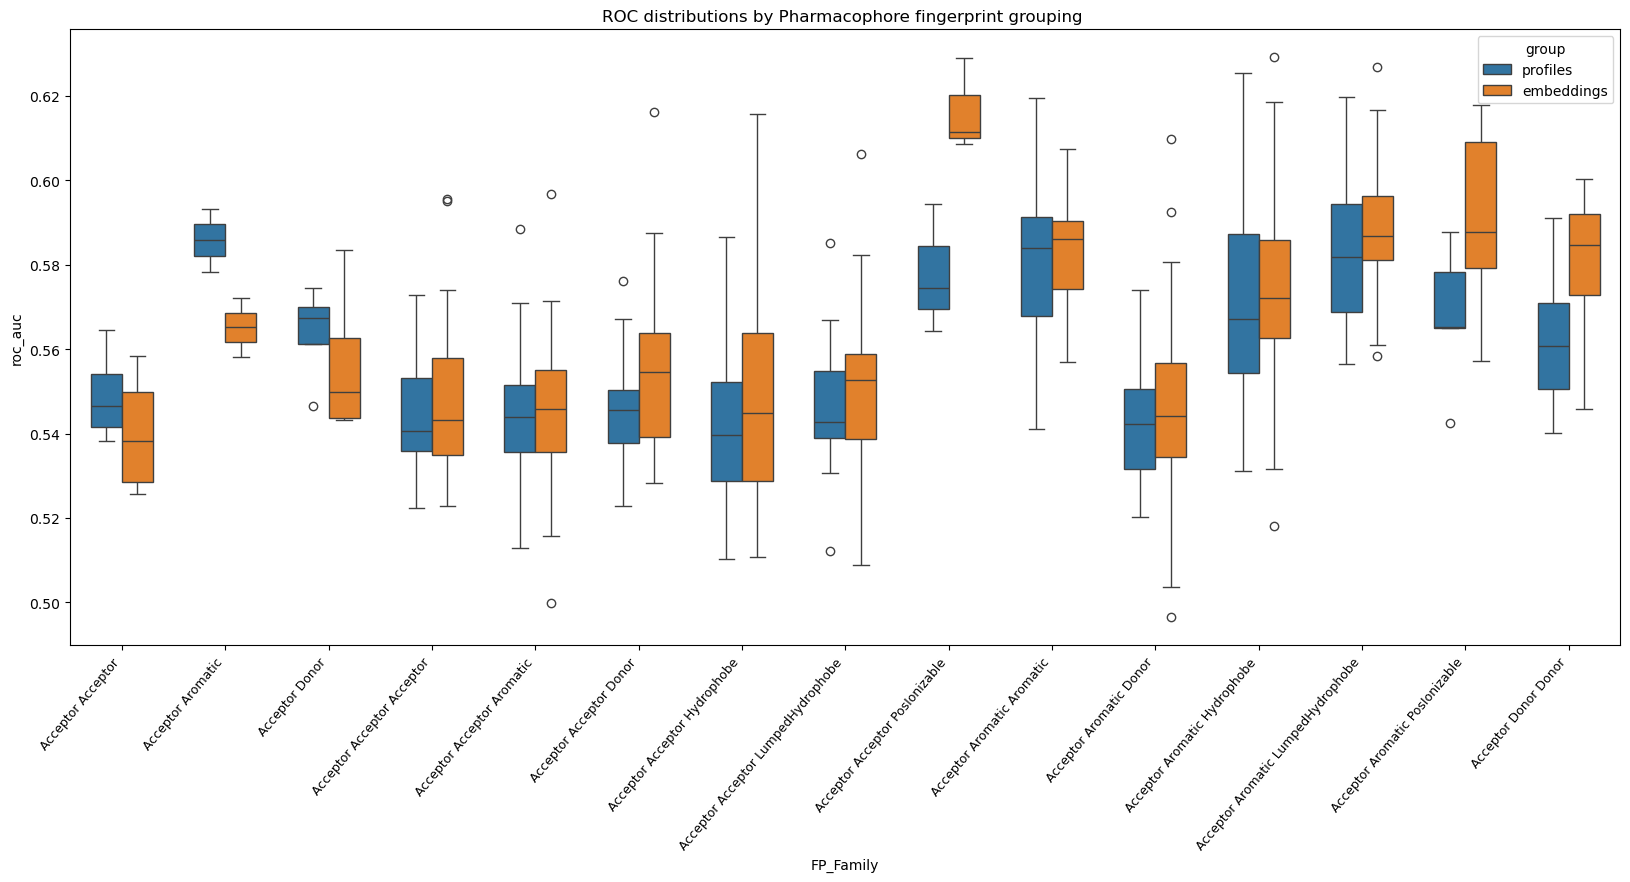

In [55]:
plot_boxplots(indicies_1)

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/categorical.p

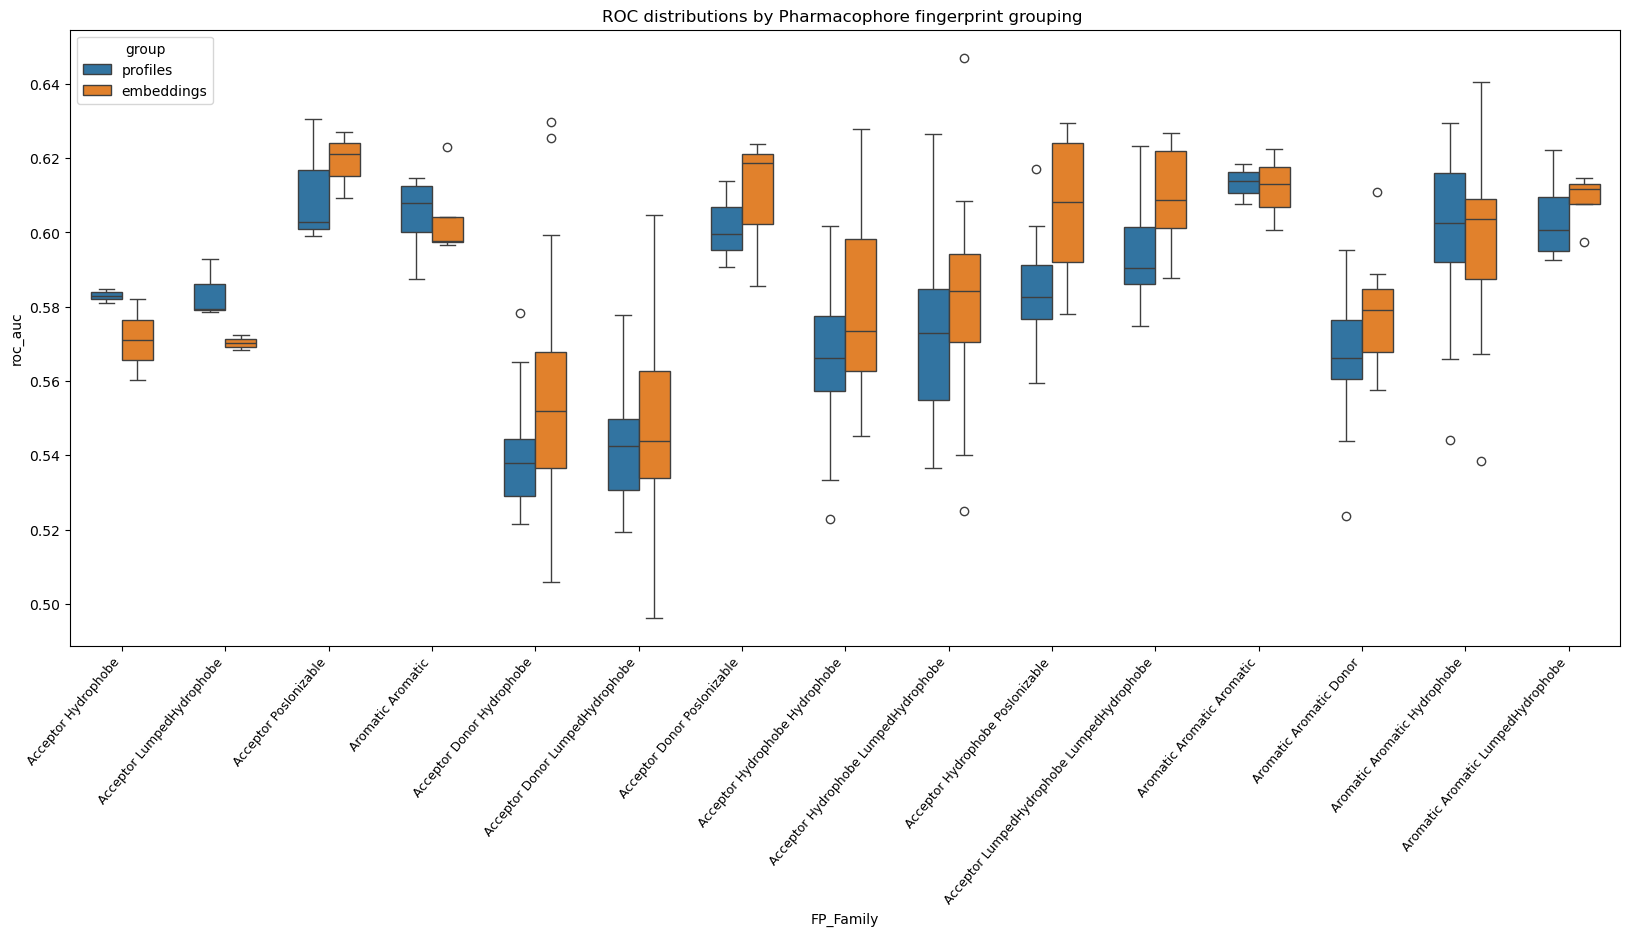

In [56]:
plot_boxplots(indicies_2)

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/categorical.p

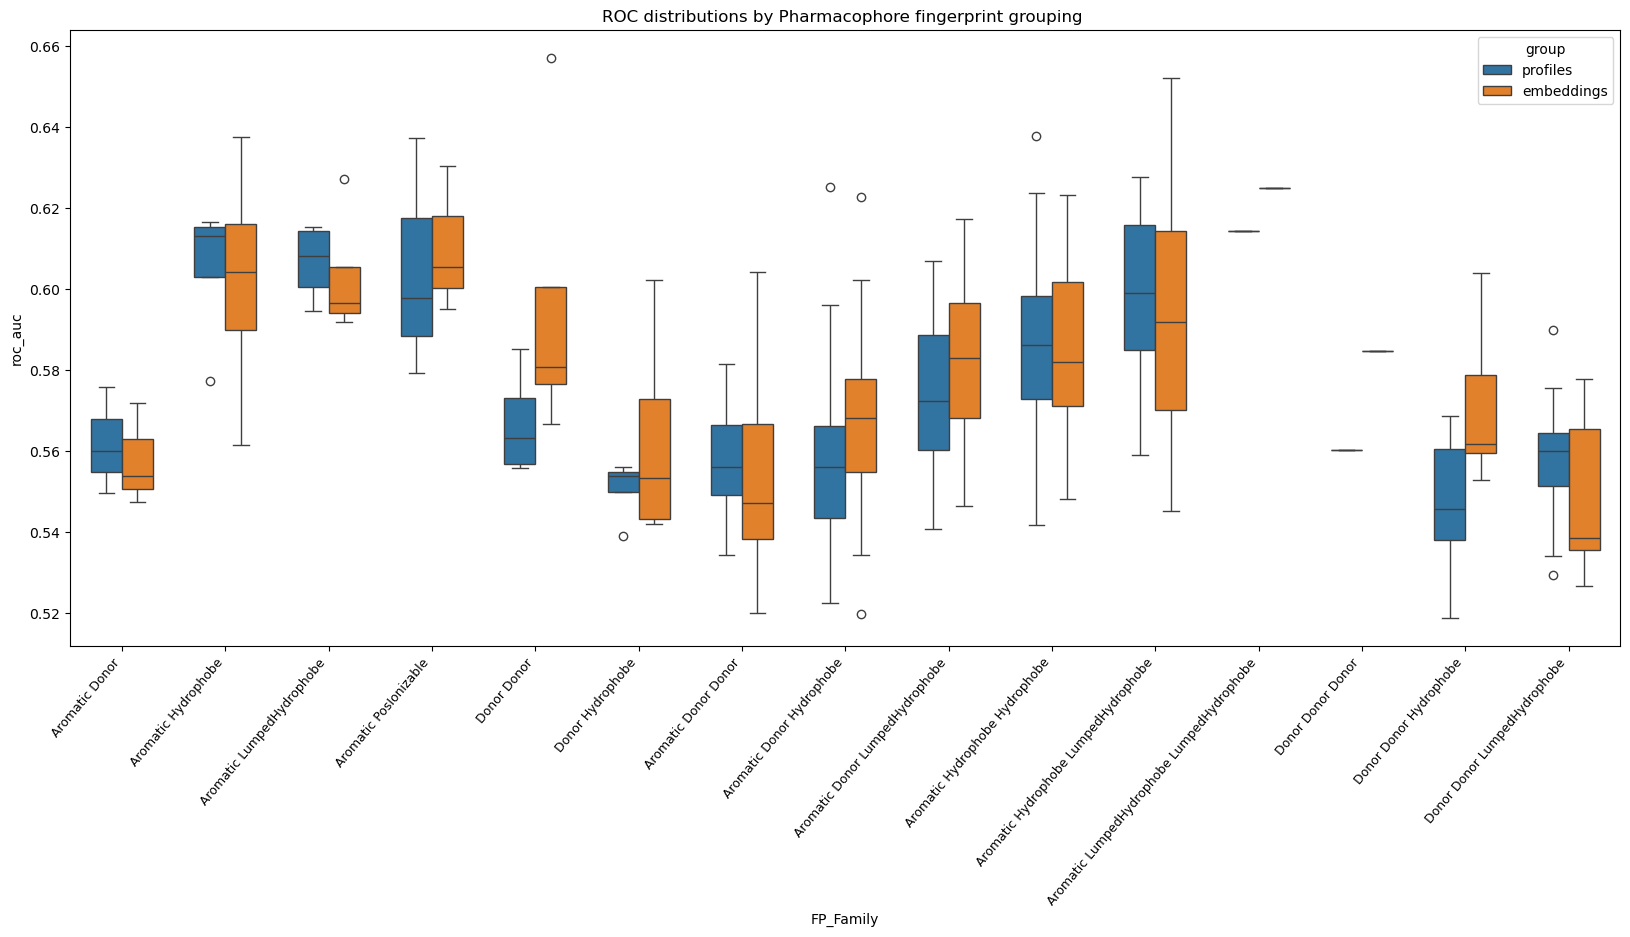

In [57]:
plot_boxplots(indicies_3)

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/categorical.p

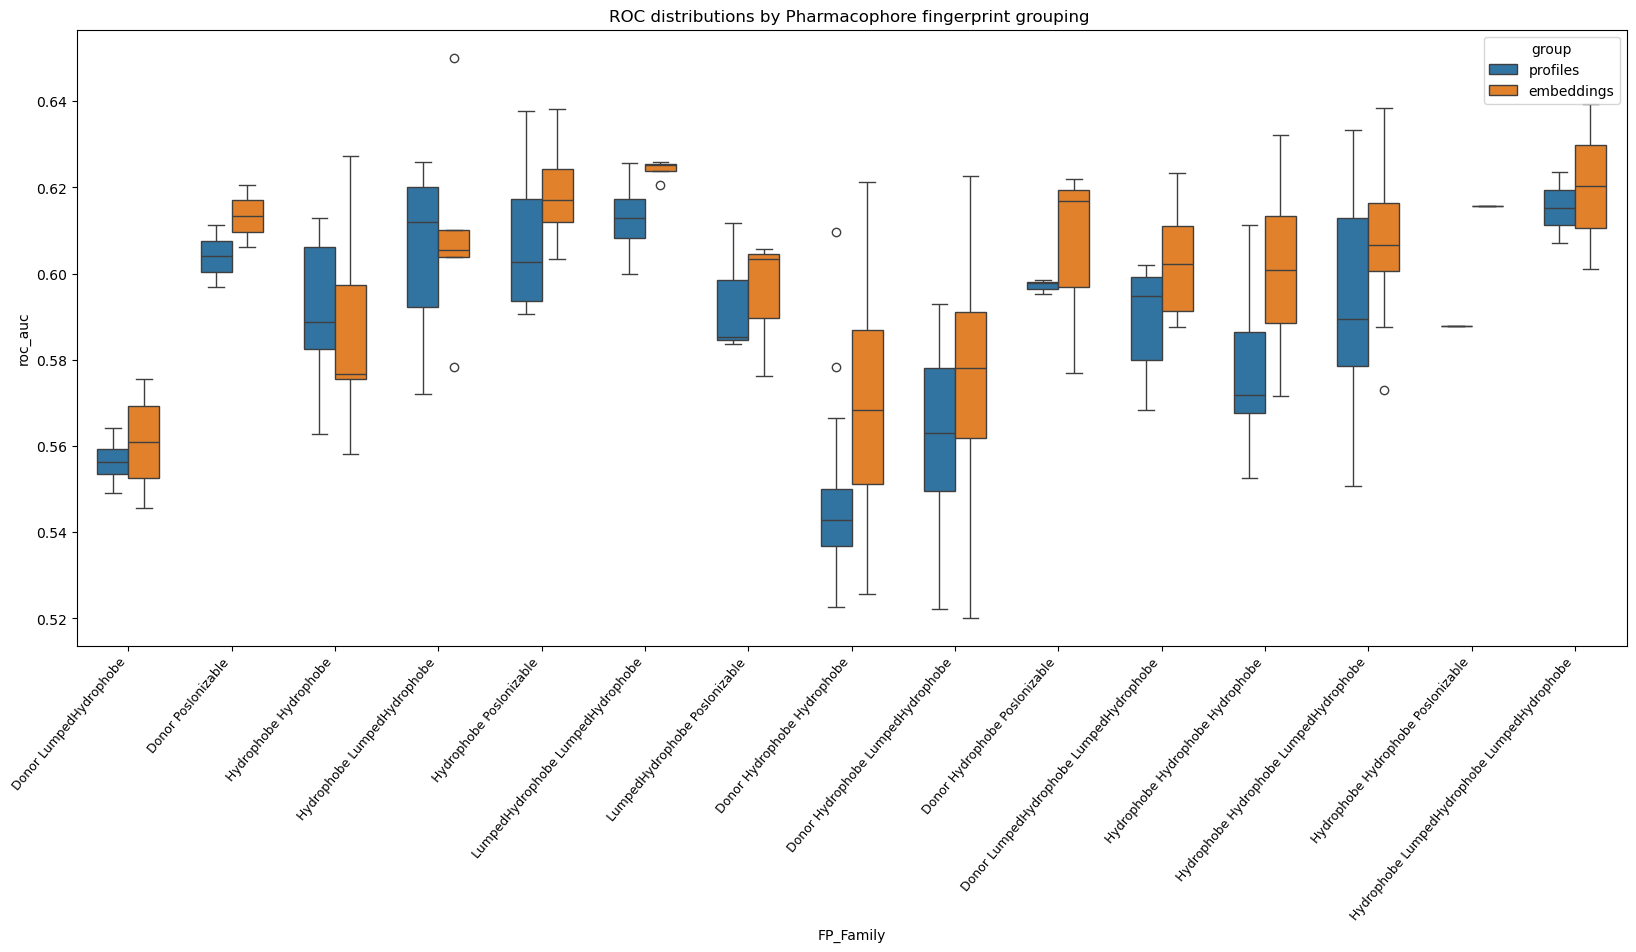

In [58]:
plot_boxplots(indicies_4)

## Adam Selected Groups

In [56]:
# ADAM_SELECTED_IDXS =  [6, 12, 17, 21, 24, 26, 28, 50, 57]
ADAM_SELECTED_IDXS =  [ 17, 21, 24,  57]
# ADAM_SELECTED_IDXS =  [ 29,27,12,40,56,6,17,36,21,25]
sorted(ADAM_SELECTED_IDXS)
ADAM_SELECTED_GRPS = []
for idx in sorted(ADAM_SELECTED_IDXS):
    ADAM_SELECTED_GRPS.append(FP_GROUPS_SORTED[idx])
ADAM_SELECTED_GRPS

[17, 21, 24, 57]

['Acceptor Donor PosIonizable',
 'Acceptor Hydrophobe PosIonizable',
 'Acceptor PosIonizable',
 'Hydrophobe PosIonizable']

In [57]:
adam_indicies = df_boxplot[df_boxplot.FP_Family.isin(ADAM_SELECTED_GRPS)].index
len(adam_indicies)

40

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/categorical.p

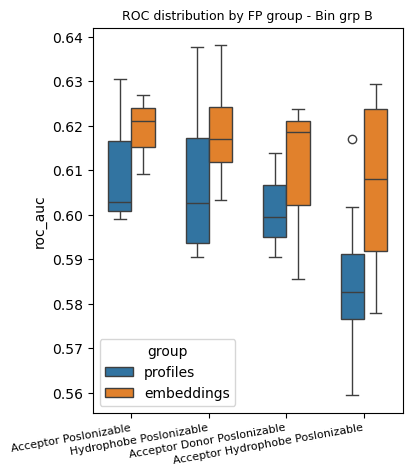

In [62]:
plot_boxplots(df_boxplot, adam_indicies, width =4, height = 6, title='Bin grp B')

# Misc

In [200]:
# data from https://allisonhorst.github.io/palmerpenguins/

# import matplotlib.pyplot as plt
# import numpy as np

# Fingerprint_bits = profile_best_metrics.Y_bit
# scores = {
#     'Profiles': profile_best_metrics.mean_test_score,
#     'Embeddings': embedded_best_metrics.mean_test_score,
# }

# x = np.arange(len(Fingerprint_bits))  # the label locations
# width = 0.3  # the width of the bars
# multiplier = 0

# # fig, ax = plt.subplots(layout='constrained',figsize=(10,4))
# fig, ax = plt.subplots(figsize=(20,6))

# # for attribute, measurement in test_scores.items():
# offset = width * multiplier
# rects = ax.bar(x + offset, scores['Profiles'] , width, label='Profiles')
# _ = ax.bar_label(rects, padding=5, size=6, fmt = '%0.3f');
# multiplier += 1
# offset = width * multiplier
# rects = ax.bar(x + offset, scores['Embeddings'] , width, label='Embeddings')
# _ = ax.bar_label(rects, padding=5, size=6, fmt = '%0.3f');

# # Add some text for labels, title and custom x-axis tick labels, etc.
# _ = ax.set_ylabel('ROC AUC')
# _ = ax.set_xlabel('Fingerprint Descriptor ID')
# _ = ax.set_title('ROC_AUC - Profiles vs. Embeddings')
# _ = ax.set_xticks(x + width/2, Fingerprint_bits)
# _ = ax.legend(loc='upper left', ncols=3)
# _ = ax.set_ylim(0.4, 0.75)
# _ = ax.set_xlim(-1, 37)
 
